# Figures

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [628]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
# PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['BCell', 'TCell']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [5]:
def load_peaks(path, suffix,
               modifications=MODIFICATIONS,
               cells=GSE26320_CELLS,
               replicates=GSE26320_REPS):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [377]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


file modification   cell  \
106  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K27me3  HepG2   
50   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K27me3   HSMM   
220  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K27ac   K562   
180  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K4me1   HSMM   
214  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...     H3K27me3   NHLF   

    replicate  peaks         tool dataset  
106      rep2      0  MACS2 broad  ENCODE  
50       rep1   5126        MACS2  ENCODE  
220      rep1  26929        SICER  ENCODE  
180      rep1  58438        SICER  ENCODE  
214      rep2  38498        SICER  ENCODE

In [378]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, [''])
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 10


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 10


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 10


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 10


file modification   cell  \
29  /home/jetbrains/data/2023_Immune/sicer/TCell_H...      H3K4me1  TCell   
32  /home/jetbrains/data/2023_Immune/span/BCell_H3...     H3K27me3  BCell   
14  /home/jetbrains/data/2023_Immune/macs2/BCell_H...     H3K36me3  BCell   
33  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K4me3  BCell   
9   /home/jetbrains/data/2023_Immune/macs2/BCell_H...     H3K36me3  BCell   

   replicate   peaks         tool  dataset  
29             53056        SICER  Roadmap  
32            102270         SPAN  Roadmap  
14            152502  MACS2 broad  Roadmap  
33             21067         SPAN  Roadmap  
9             177956        MACS2  Roadmap

In [379]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

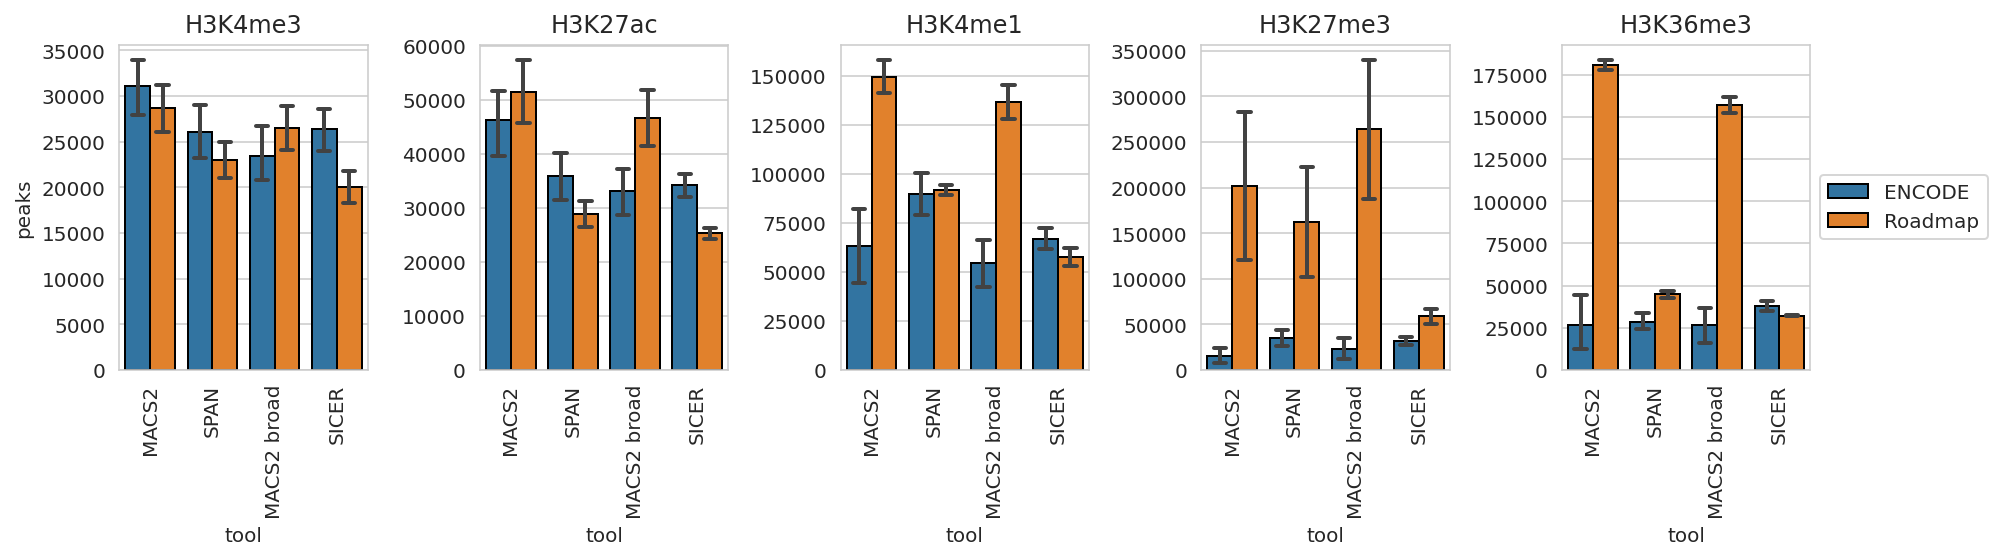

In [10]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'SPAN', 'MACS2 broad', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [11]:
df_peaks[(df_peaks['modification'].isin(['H3K27ac', 'H3K4me1']) & 
          (df_peaks['replicate'].isin(['rep1', '']))) & 
         ((df_peaks['peaks'] > 100_000) | (df_peaks['peaks'] < 10_000))]

file modification   cell  \
25   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   NHEK   
57   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   K562   
261  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me1   NHEK   
340  /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me1  TCell   
343  /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K4me1  BCell   
351  /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K4me1  BCell   
359  /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me1  TCell   

    replicate   peaks         tool  dataset  
25       rep1  110303        MACS2   ENCODE  
57       rep1  119713        MACS2   ENCODE  
261      rep1  107773         SPAN   ENCODE  
340            158205        MACS2  Roadmap  
343            141414        MACS2  Roadmap  
351            127965  MACS2 broad  Roadmap  
359            145437  MACS2 broad  Roadmap

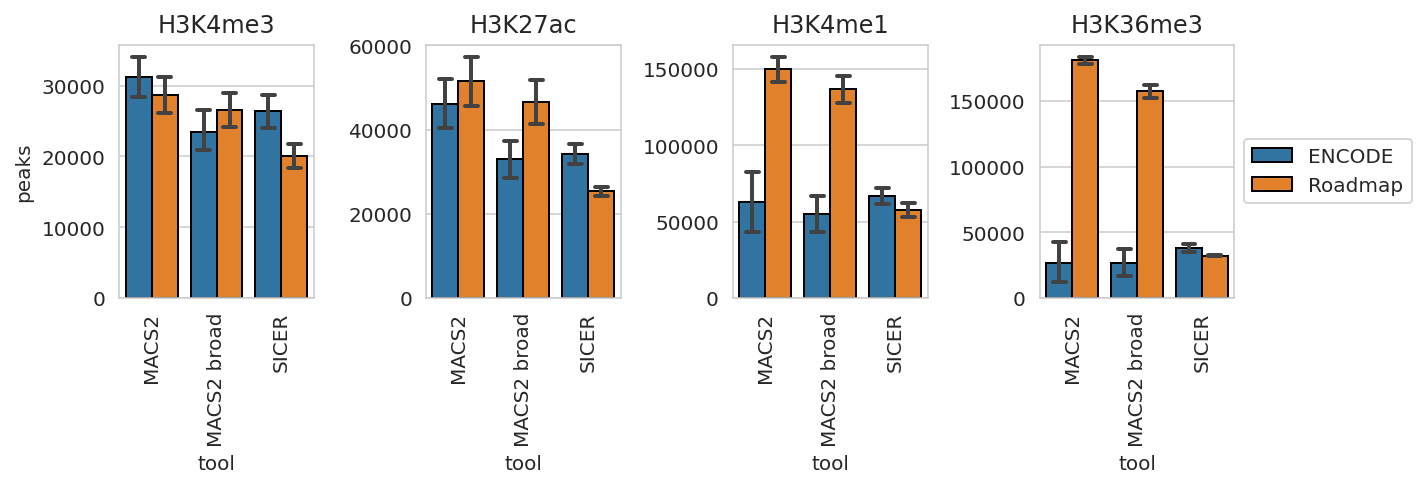

In [12]:
plt.figure(figsize=(10, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

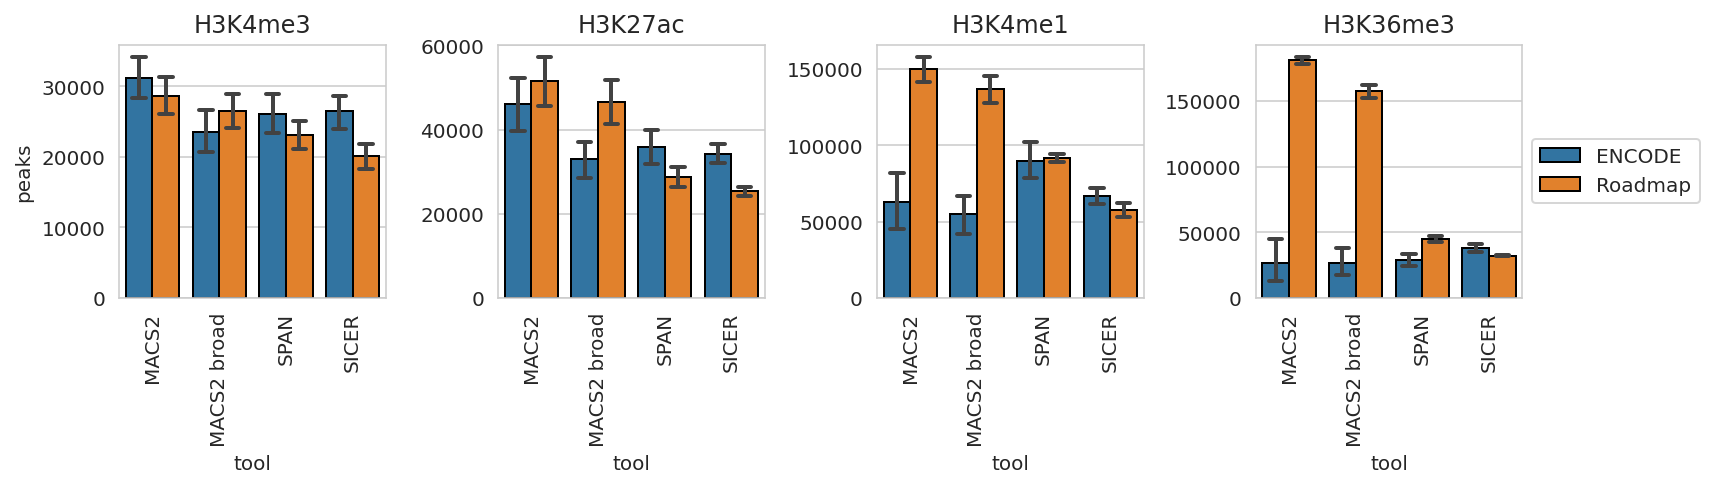

In [13]:
plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [14]:
print('Load lengths')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = dataset
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length  dataset modification     cell replicate         tool
142920    326.0   ENCODE      H3K4me1     NHLF      rep2        MACS2
3435749  6799.0  Roadmap      H3K27ac    BCell                  SICER
3173432   284.0  Roadmap     H3K27me3    BCell                  MACS2
1447909  1051.0   ENCODE     H3K36me3    HepG2      rep2  MACS2 broad
2885531   640.0   ENCODE     H3K36me3       H1      rep2         SPAN
3261279  1284.0  Roadmap      H3K27ac    TCell            MACS2 broad
1732939  2999.0   ENCODE     H3K36me3       H1      rep2        SICER
298891    404.0   ENCODE     H3K27me3       H1      rep2        MACS2
3037995  1144.0   ENCODE      H3K27ac  GM12878      rep1         SPAN
1724694  3399.0   ENCODE      H3K4me1     K562      rep1        SICER

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


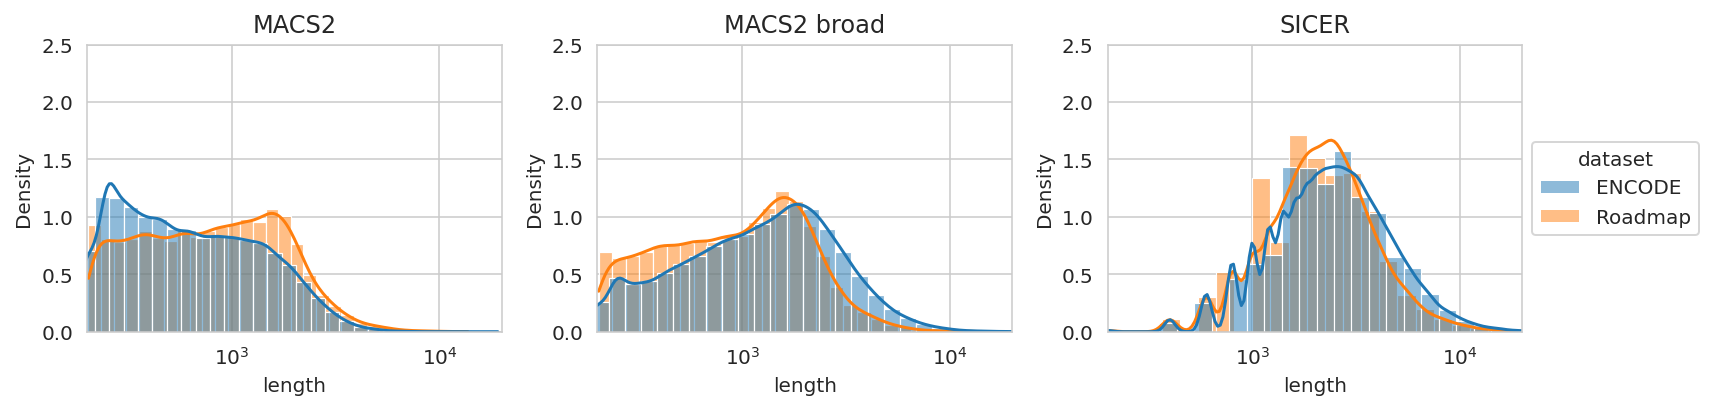

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


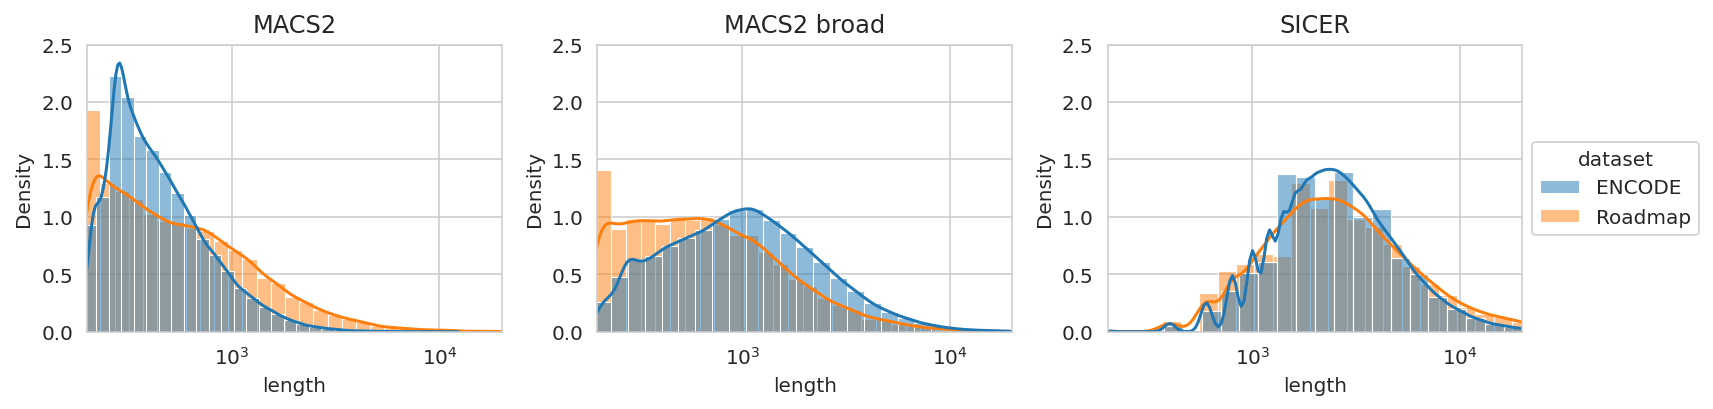

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


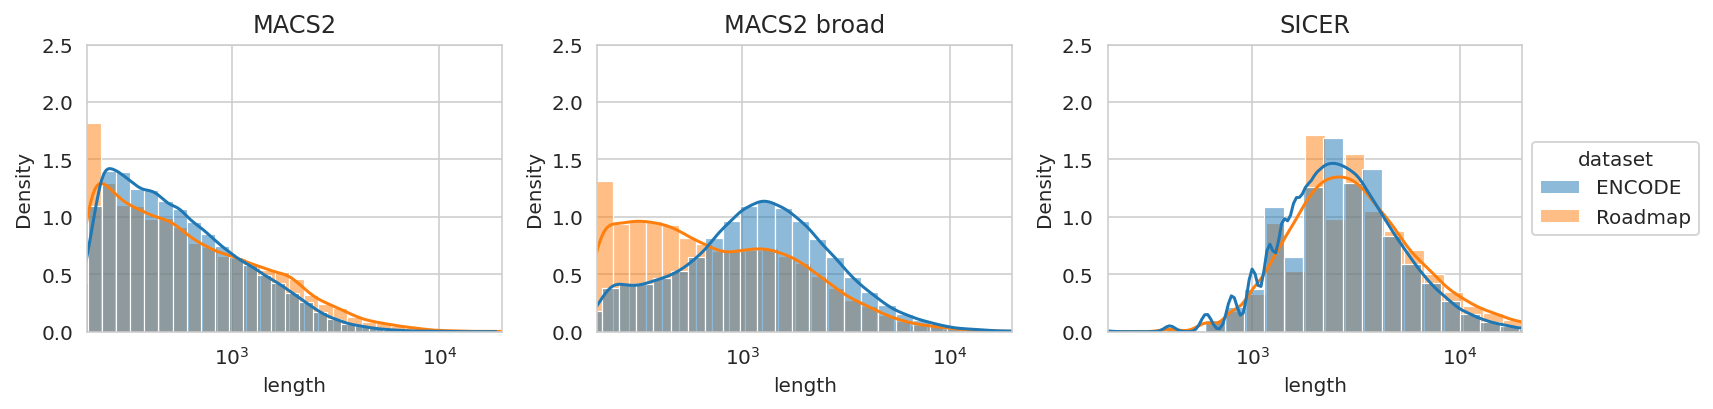

H3K36me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


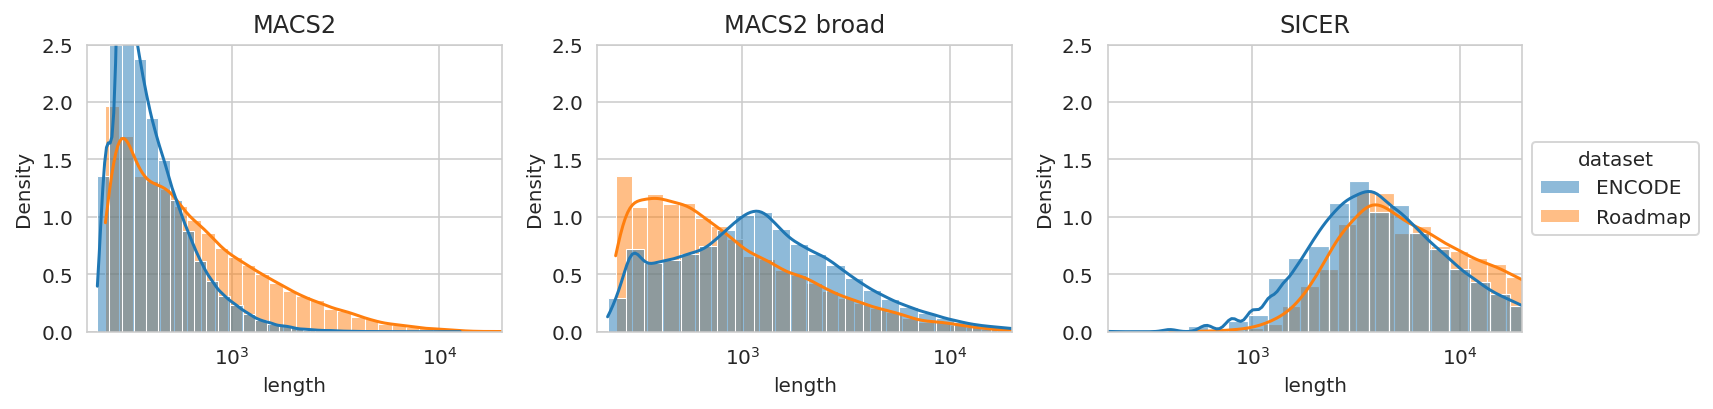

In [15]:
for m in ['H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='dataset', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 # palette=TOOLS_PALETTE,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K36me3


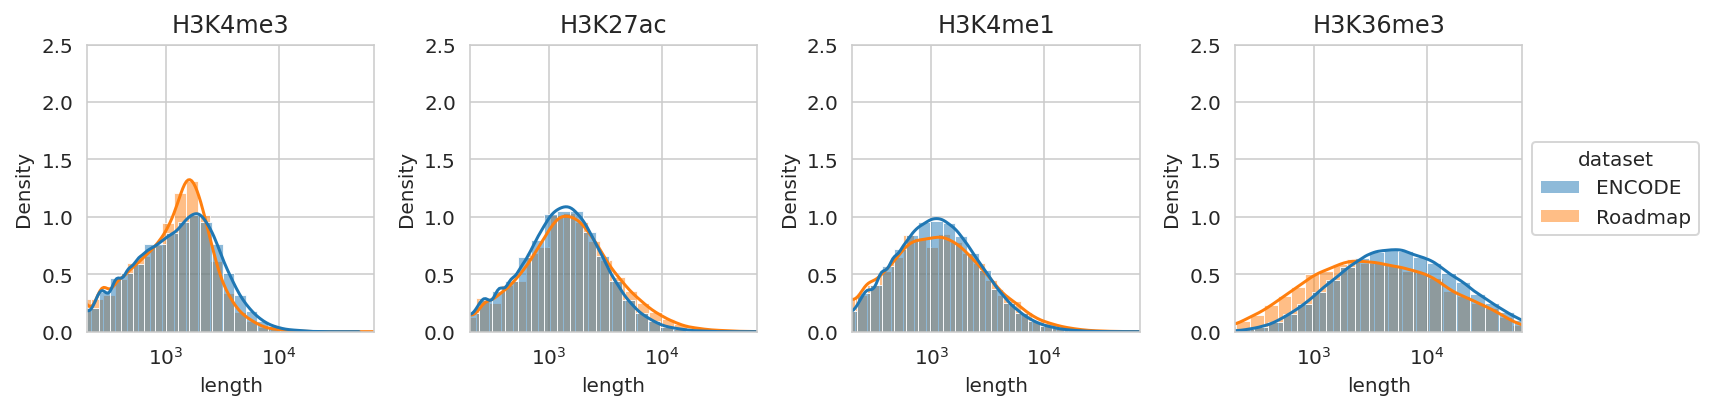

In [16]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # palette=TOOLS_PALETTE,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 7e4)
    ax.title.set_text(m)
    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

In [17]:
t_aggr = t[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index()
t_aggr.sample(3)

dataset modification   cell replicate         tool     length
361  Roadmap      H3K4me1  BCell                   SPAN  1877.0269
119   ENCODE     H3K27me3   K562      rep2  MACS2 broad   268.5833
369  Roadmap      H3K4me3  BCell                   SPAN  1367.8279

H3K4me3
H3K27ac
H3K4me1
H3K36me3


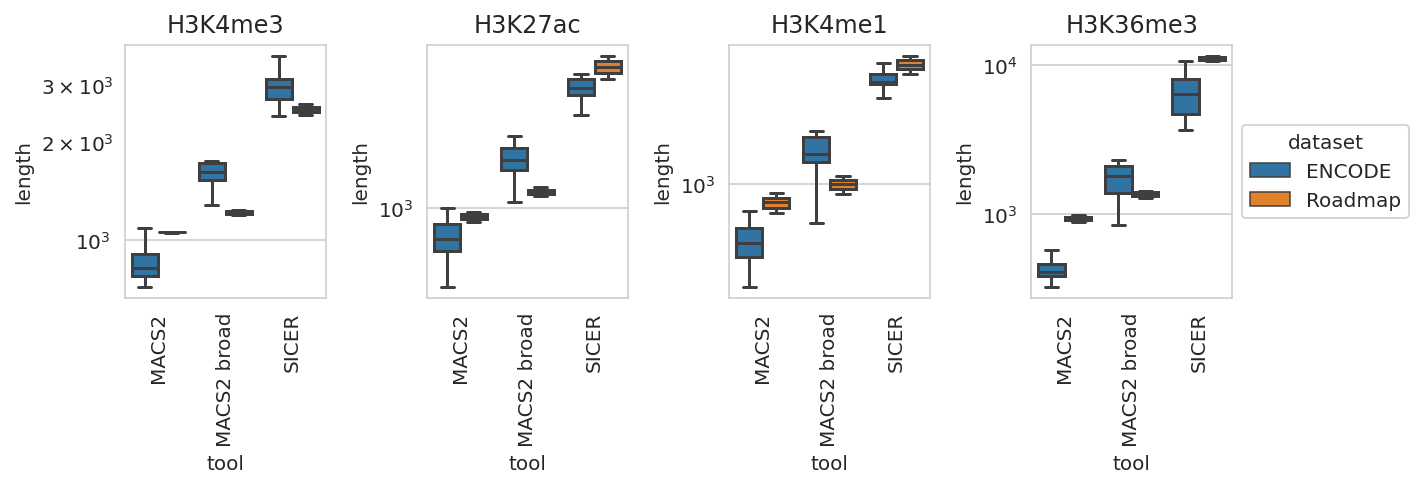

In [18]:
plt.figure(figsize=(10, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.boxplot(data=t_aggr[t_aggr['modification'] == m],
                            x='tool', y='length', ax=ax, hue='dataset',
                            showfliers=False,
                            # capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    ax.set(yscale='log')

    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, )
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Load downsampled peaks

In [19]:
# NOISE_PATH = os.path.expanduser('~/data/2023_Immune_noise')
NOISE_PATH = os.path.expanduser('~/data/2023_Immune_mln_control')

In [20]:
df_peaks_noise = load_peaks_path(NOISE_PATH, MODIFICATIONS, IMMUNE_CELLS, [''])
df_peaks_noise['quality'] = 0
for mln in [15, 10, 5, 2, 1]:
    df_peaks_noise.loc[[f'_{mln}mln' in file for file in df_peaks_noise['file']], 'quality'] = mln
df_peaks_noise.sample(3)

  0%|          | 0/352 [00:00<?, ?it/s]

MACS2 32


  0%|          | 0/352 [00:00<?, ?it/s]

MACS2 broad 32


  0%|          | 0/352 [00:00<?, ?it/s]

SICER 32


  0%|          | 0/45 [00:00<?, ?it/s]

SPAN 32


file modification   cell  \
121  /home/jetbrains/data/2023_Immune_mln_control/s...      H3K4me3  BCell   
75   /home/jetbrains/data/2023_Immune_mln_control/s...      H3K4me3  BCell   
78   /home/jetbrains/data/2023_Immune_mln_control/s...      H3K4me3  TCell   

    replicate  peaks   tool  quality  
121            16239   SPAN       10  
75             16274  SICER       10  
78             13896  SICER        1

In [21]:
t1 = df_peaks_noise[df_peaks_noise['quality'] == 10].copy()
t1['reads'] = 10
t2 = df_immune_peaks.copy()
t2['reads'] = 20
df_downsample = pd.concat([t1, t2]).reset_index(drop=True)
df_downsample['reads'] = df_downsample['reads'].astype(str) + 'M'

df_downsample

file modification   cell  \
0   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  BCell   
1   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  BCell   
2   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  TCell   
3   /home/jetbrains/data/2023_Immune_mln_control/m...     H3K36me3  BCell   
4   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  TCell   
..                                                ...          ...    ...   
67  /home/jetbrains/data/2023_Immune/span/TCell_H3...     H3K27me3  TCell   
68  /home/jetbrains/data/2023_Immune/span/BCell_H3...     H3K36me3  BCell   
69  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K27ac  BCell   
70  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K4me1  BCell   
71  /home/jetbrains/data/2023_Immune/span/TCell_H3...      H3K4me3  TCell   

   replicate   peaks   tool  quality reads  dataset  
0             112650  MACS2     10.0   10M      NaN  
1              23702  MACS2     10.0   10M      NaN  
2              27685  MACS2     10.0   10M      NaN  
3             137165  MACS2     10.0   10M      NaN  
4             124685  MACS2     10.0   10M      NaN  
..       ...     ...    ...      ...   ...      ...  
67            222162   SPAN      NaN   20M  Roadmap  
68             42693   SPAN      NaN   20M  Roadmap  
69             26454   SPAN      NaN   20M  Roadmap  
70             89375   SPAN      NaN   20M  Roadmap  
71             25006   SPAN      NaN   20M  Roadmap  

[72 rows x 9 columns]

H3K27ac
H3K4me1


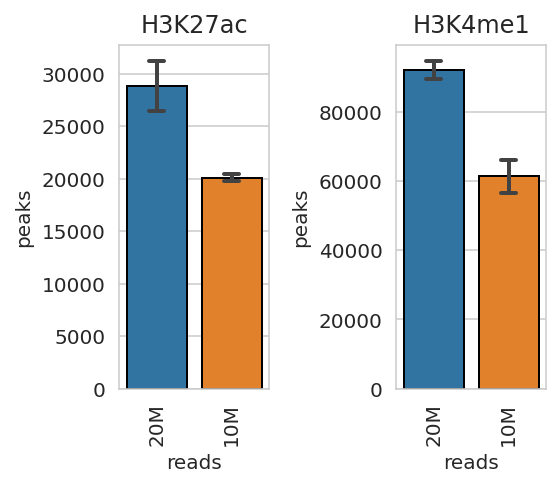

In [22]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=df_downsample[(df_downsample['modification'] == m) & 
                                               (df_downsample['tool'] == 'SPAN')],
                            x='reads', y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['20M', '10M'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


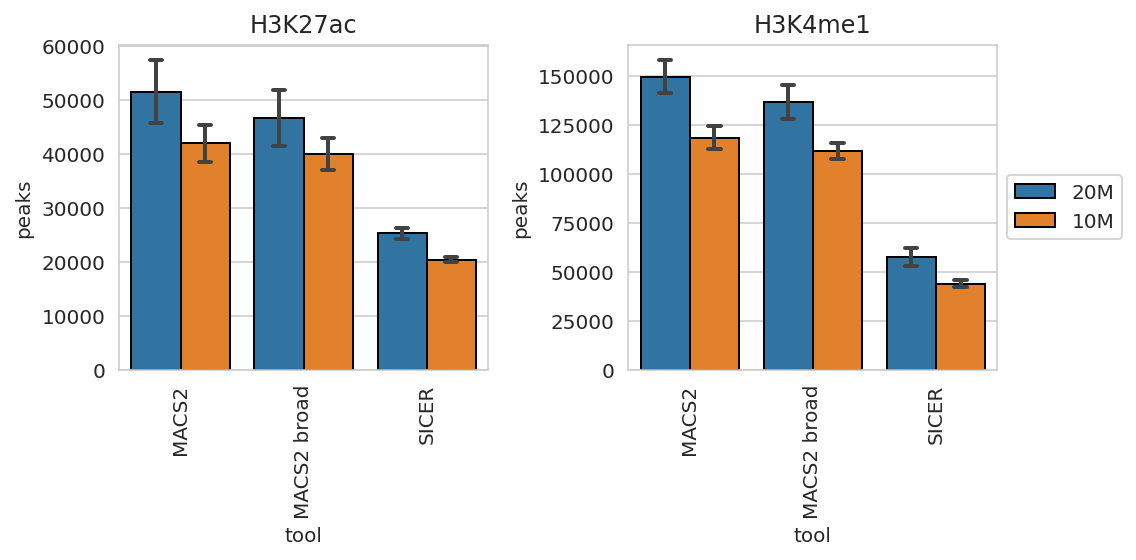

In [23]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=df_downsample[df_downsample['modification'] == m],
                            hue='reads', x='tool', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            hue_order=['20M', '10M'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)
    if i != 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [24]:
df_downsample_fc = pd.DataFrame(columns=['modification', 'cell', 'replicate', 'tool', 
                                         'peaks20M', 'peaks10M', 'fold-change'])
t = df_downsample[df_downsample['reads'] == '20M']
for m, c, r, to, p in tqdm(zip(t['modification'], t['cell'], t['replicate'], t['tool'], t['peaks'])):
    print(m, c, r, to, p)
    t10 = df_downsample[(df_downsample['reads'] == '10M') &
                        (df_downsample['modification'] == m) &
                        (df_downsample['cell'] == c) &
                        (df_downsample['replicate'] == r) &
                        (df_downsample['tool'] == to)]
    if len(t10) == 0:
        continue
    p10 = t10['peaks'].values[0]
    df_downsample_fc.loc[len(df_downsample_fc)] = (m, c, r, to, p, p10, d(p10, p))
df_downsample_fc.sample(3)

0it [00:00, ?it/s]

H3K4me1 TCell  MACS2 158205
H3K27me3 BCell  MACS2 120947
H3K27me3 TCell  MACS2 283089
H3K4me1 BCell  MACS2 141414
H3K27ac TCell  MACS2 57350
H3K4me3 TCell  MACS2 31242
H3K36me3 TCell  MACS2 183613
H3K4me3 BCell  MACS2 26066
H3K27ac BCell  MACS2 45626
H3K36me3 BCell  MACS2 177956
H3K27ac TCell  MACS2 broad 51740
H3K4me1 BCell  MACS2 broad 127965
H3K27ac BCell  MACS2 broad 41460
H3K27me3 TCell  MACS2 broad 339795
H3K36me3 BCell  MACS2 broad 152502
H3K27me3 BCell  MACS2 broad 187656
H3K4me3 BCell  MACS2 broad 24118
H3K36me3 TCell  MACS2 broad 161765
H3K4me3 TCell  MACS2 broad 28929
H3K4me1 TCell  MACS2 broad 145437
H3K4me3 TCell  SICER 21785
H3K36me3 BCell  SICER 31862
H3K27ac TCell  SICER 26338
H3K27me3 BCell  SICER 50127
H3K4me1 BCell  SICER 62076
H3K27me3 TCell  SICER 67477
H3K36me3 TCell  SICER 32491
H3K27ac BCell  SICER 24342
H3K4me3 BCell  SICER 18342
H3K4me1 TCell  SICER 53056
H3K27ac TCell  SPAN 31192
H3K36me3 TCell  SPAN 47042
H3K27me3 BCell  SPAN 102270
H3K4me3 BCell  SPAN 21067

modification   cell replicate         tool  peaks20M  peaks10M  fold-change
4      H3K36me3  TCell                  MACS2    183613    134346     0.731680
21      H3K27ac  BCell                  SICER     24342     19973     0.820516
13     H3K36me3  TCell            MACS2 broad    161765    127137     0.785936

H3K27ac
H3K4me1


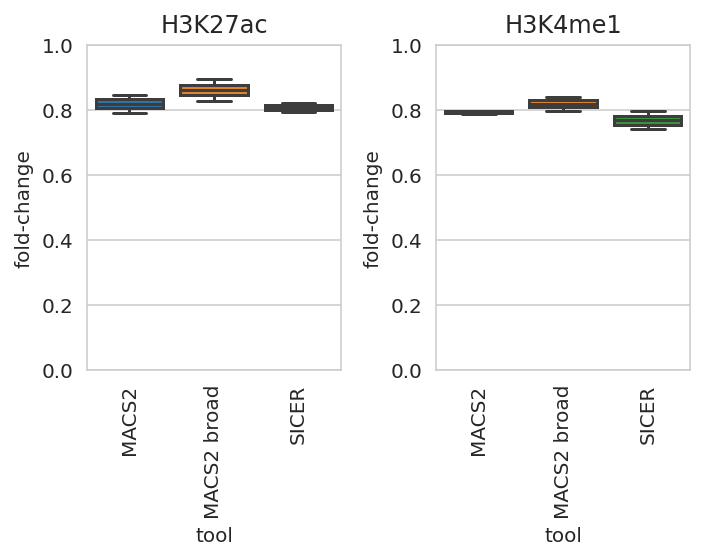

In [25]:
plt.figure(figsize=(5, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.boxplot(data=df_downsample_fc[df_downsample_fc['modification'] == m],
                            x='tool', y='fold-change', ax=ax,
                            # capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)
    # if i != 1:
    #     ax.legend().set_visible(False)
    # else:
        # Put a legend to the right of the current axis
        # g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [26]:
print('Load lengths')
ts = []
for mod, signal_reads, file, tool in tqdm(zip(
        df_downsample['modification'], df_downsample['reads'], df_downsample['file'], df_downsample['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['modification'] = mod
    t['reads'] = signal_reads
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length modification reads         tool
470657    1938     H3K27me3   20M  MACS2 broad
233402    3599      H3K27ac   10M        SICER
40514     1053      H3K4me1   10M        MACS2
463905    1256     H3K36me3   20M  MACS2 broad
326070     927      H3K4me1   20M        MACS2
389620     278     H3K36me3   20M        MACS2
427674    1235      H3K27ac   20M  MACS2 broad
346507     204     H3K27me3   20M        MACS2
369902     200      H3K27ac   20M        MACS2
377301     203      H3K4me3   20M        MACS2

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


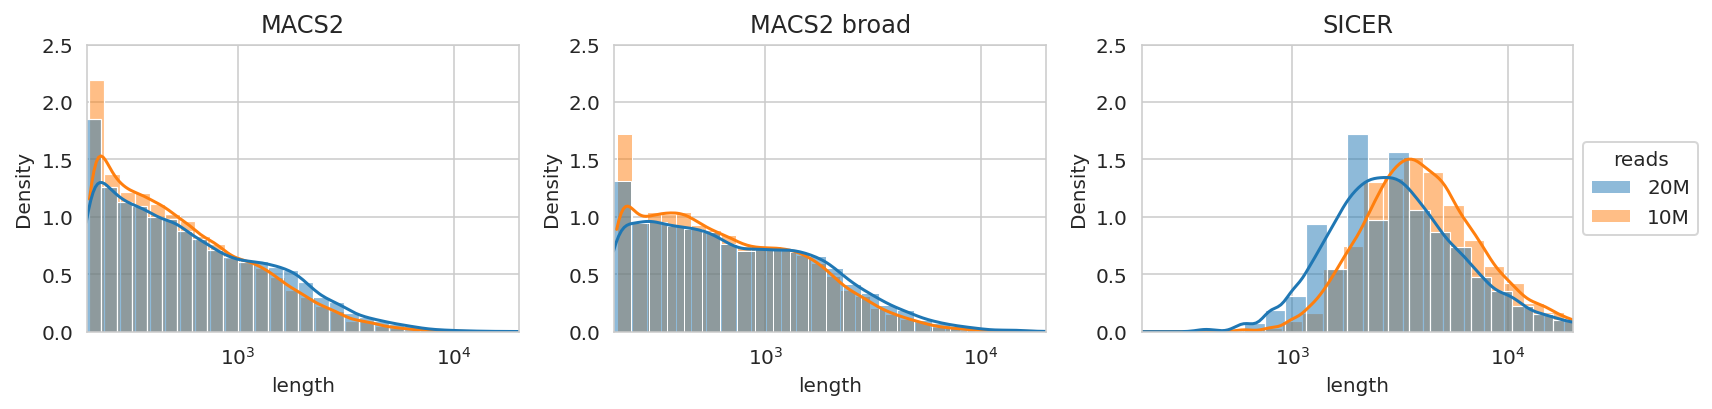

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


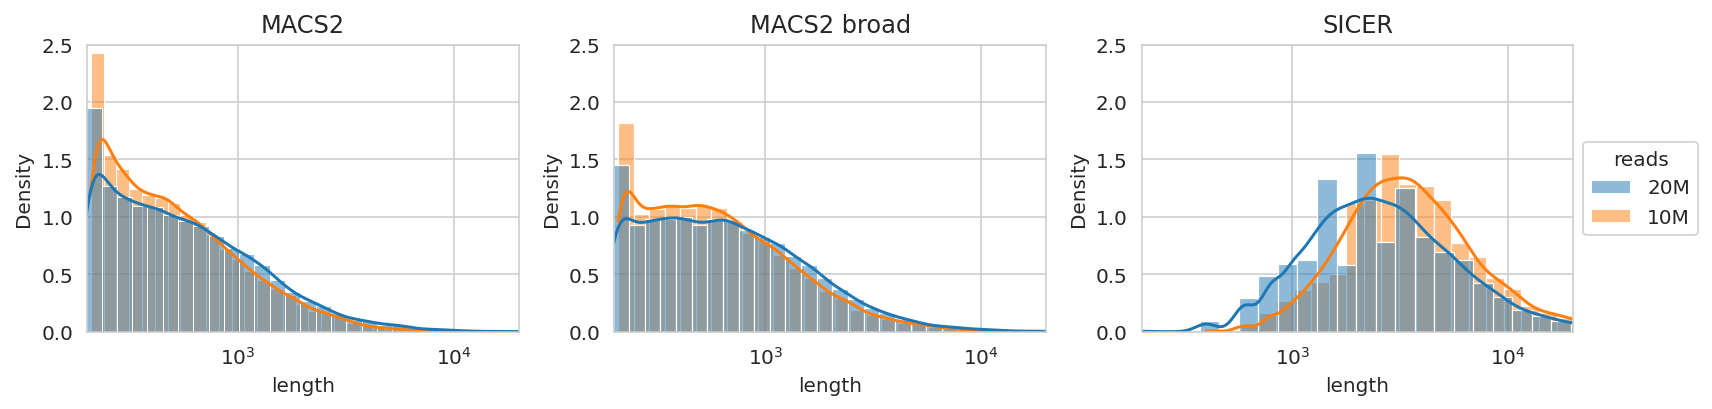

In [27]:
palette = plt.cm.get_cmap('tab10')
READS_PALETTE = {'20M': palette(0), '10M': palette(1)}

t['dataset'] = t['modification'] + ' ' + t['reads']

for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='reads', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 hue_order=['20M', '10M'],
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.tight_layout()
    plt.show()


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


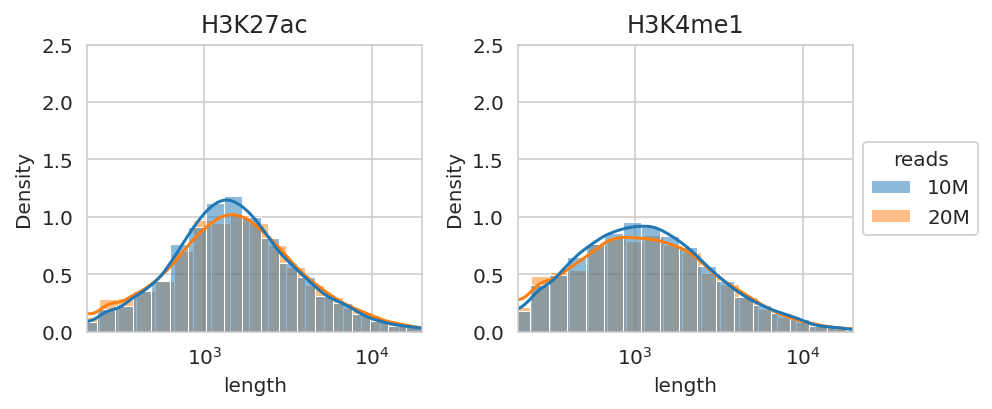

In [28]:
palette = plt.cm.get_cmap('tab10')
READS_PALETTE = {'20M': palette(0), '10M': palette(1)}

t['dataset'] = t['modification'] + ' ' + t['reads']

plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='reads', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # hue_order=['20M', '10M'],
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


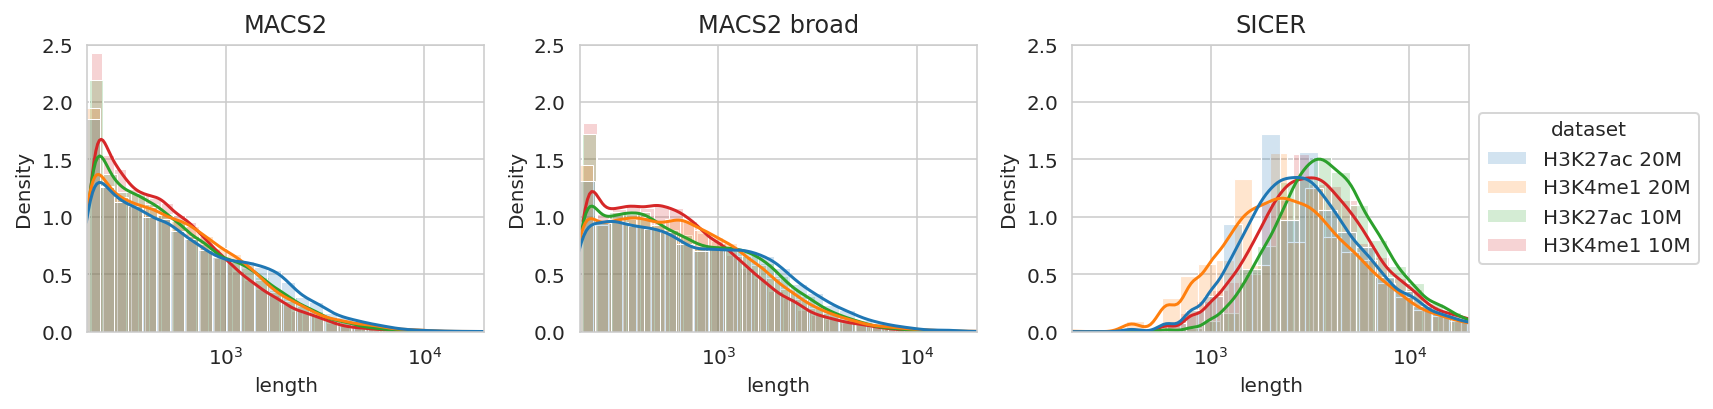

In [29]:
t['dataset'] = t['modification'] + ' ' + t['reads']

plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(
        data=t[((t['modification'] == 'H3K27ac') | (t['modification'] == 'H3K4me1')) & (t['tool'] == tool)],
        x='length', hue='dataset', ax=ax,
        stat='density', common_bins=False, common_norm=False,
        bins=30, kde=True, log_scale=True, alpha=0.2,
        hue_order=['H3K27ac 20M', 'H3K4me1 20M', 'H3K27ac 10M', 'H3K4me1 10M'],
        # palette=READS_PALETTE,
        )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 2:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


## Jaccard original vs downsampled

In [30]:
df_downsample

file modification   cell  \
0   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  BCell   
1   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  BCell   
2   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me3  TCell   
3   /home/jetbrains/data/2023_Immune_mln_control/m...     H3K36me3  BCell   
4   /home/jetbrains/data/2023_Immune_mln_control/m...      H3K4me1  TCell   
..                                                ...          ...    ...   
67  /home/jetbrains/data/2023_Immune/span/TCell_H3...     H3K27me3  TCell   
68  /home/jetbrains/data/2023_Immune/span/BCell_H3...     H3K36me3  BCell   
69  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K27ac  BCell   
70  /home/jetbrains/data/2023_Immune/span/BCell_H3...      H3K4me1  BCell   
71  /home/jetbrains/data/2023_Immune/span/TCell_H3...      H3K4me3  TCell   

   replicate   peaks   tool  quality reads  dataset  
0             112650  MACS2     10.0   10M      NaN  
1              23702  MACS2     10.0   10M      NaN  
2              27685  MACS2     10.0   10M      NaN  
3             137165  MACS2     10.0   10M      NaN  
4             124685  MACS2     10.0   10M      NaN  
..       ...     ...    ...      ...   ...      ...  
67            222162   SPAN      NaN   20M  Roadmap  
68             42693   SPAN      NaN   20M  Roadmap  
69             26454   SPAN      NaN   20M  Roadmap  
70             89375   SPAN      NaN   20M  Roadmap  
71             25006   SPAN      NaN   20M  Roadmap  

[72 rows x 9 columns]

In [31]:
bench_df = pd.DataFrame(
    columns=['modification', 'cell', 'replicate', 'name', 'quality',
             'original_peaks', 'original_peaks_len',
             'peaks', 'peaks_len', 'overlap1', 'overlap2', 'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for m, c, r, tool in tqdm(product(['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, [''], TOOLS)):
    print(m, c, r, tool)
    t = df_downsample[
        (df_downsample['modification'] == m) &
        (df_downsample['cell'] == c) &
        (df_downsample['replicate'] == r) &
        (df_downsample['tool'] == tool) &
        (df_downsample['reads'] == '20M')]
    if len(t) == 0:
        print('-')
        continue
    original_file = sorted_file(t['file'].values[0])
    original_peaks = lines(original_file)
    original_peaks_len = int(bedl(original_file).sum())
    t = df_downsample[
        (df_downsample['modification'] == m) &
        (df_downsample['cell'] == c) &
        (df_downsample['replicate'] == r) &
        (df_downsample['tool'] == tool) &
        (df_downsample['reads'] == '10M')]
    if len(t) == 0:
        continue
    file = sorted_file(t['file'].values[0])
    peaks_len = int(bedl(file).sum())
    !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
    overlap1 = lines(tf)
    !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
    overlap2 = lines(tf)
    !bedtools intersect -a {original_file} -b {file} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    bench_df.loc[len(bench_df)] = \
        (m, c, r, tool, '10M',
         original_peaks, original_peaks_len,
         (lines(file)), peaks_len, overlap1, overlap2, overlap_len)

display(bench_df.sample(3))


0it [00:00, ?it/s]

H3K27ac BCell  MACS2
H3K27ac BCell  MACS2 broad
H3K27ac BCell  SPAN
H3K27ac BCell  SICER
H3K27ac TCell  MACS2
H3K27ac TCell  MACS2 broad
H3K27ac TCell  SPAN
H3K27ac TCell  SICER
H3K4me1 BCell  MACS2
H3K4me1 BCell  MACS2 broad
H3K4me1 BCell  SPAN
H3K4me1 BCell  SICER
H3K4me1 TCell  MACS2
H3K4me1 TCell  MACS2 broad
H3K4me1 TCell  SPAN
H3K4me1 TCell  SICER


modification   cell replicate         name quality  original_peaks  \
1      H3K27ac  BCell            MACS2 broad     10M           41460   
6      H3K27ac  TCell                   SPAN     10M           31192   
9      H3K4me1  BCell            MACS2 broad     10M          127965   

   original_peaks_len   peaks  peaks_len  overlap1  overlap2  overlap_len  
1            46789660   37017   36345943     30175     35461     35246812  
6            84894994   20408   51357646     18724     20398     51230543  
9           141202454  107461   99905329     87816    105096     97527225

In [32]:
bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['original_peaks_len'], bench_df['peaks_len'], bench_df['overlap_len'])
]
bench_df.sample(1)


modification   cell replicate   name quality  original_peaks  \
11      H3K4me1  BCell            SICER     10M           62076   

    original_peaks_len  peaks  peaks_len  overlap1  overlap2  overlap_len  \
11           213196724  45928  206911472     47192     45858    181733164   

     jaccard  
11  0.762383

H3K27ac
H3K4me1


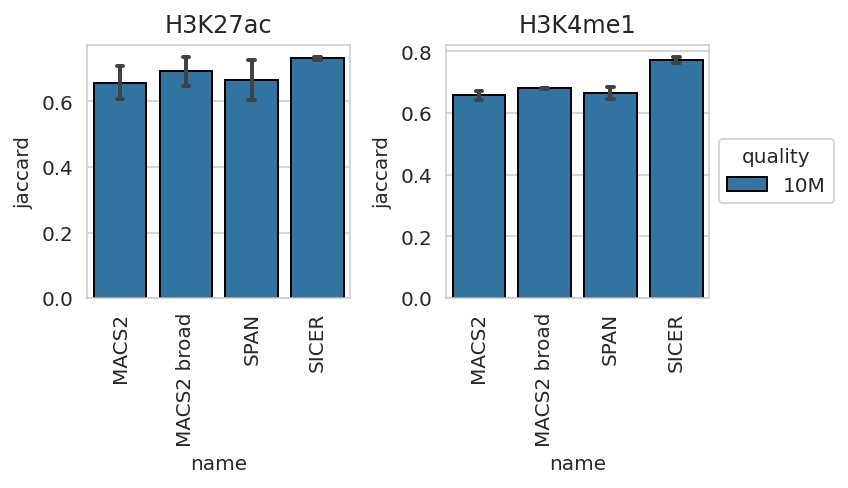

In [33]:
plt.figure(figsize=(6, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['modification'] == m],
                            x='name', hue='quality', y='jaccard', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            # hue_order=['wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

## Compute BAM coverage

In [104]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams


In [35]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_encode_bams.sample(3)

  0%|          | 0/206 [00:00<?, ?it/s]

bam_file modification     cell  \
18  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  GM12878   
60  /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3     K562   
63  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     K562   

   replicate    reads dataset  
18      rep2  5783112  ENCODE  
60      rep2  7439053  ENCODE  
63      rep2  6056281  ENCODE

In [36]:
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, [''], 'Control')
df_immune_bams['dataset'] = 'Roadmap'
df_immune_bams.sample(3)

  0%|          | 0/35 [00:00<?, ?it/s]

bam_file modification   cell  \
7   /home/jetbrains/data/2023_Immune/bams/BCell_H3...     H3K27me3  BCell   
2   /home/jetbrains/data/2023_Immune/bams/TCell_H3...      H3K4me3  TCell   
10  /home/jetbrains/data/2023_Immune/bams/TCell_H3...      H3K27ac  TCell   

   replicate     reads  dataset  
7             26056228  Roadmap  
2             28746534  Roadmap  
10            30425955  Roadmap

In [37]:
df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)

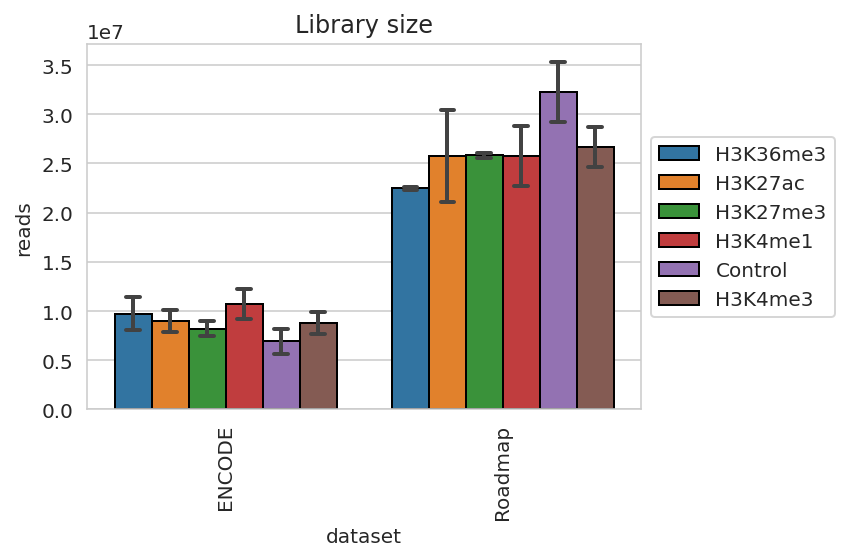

In [38]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams,
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.05, errwidth=2, edgecolor="black",
                        )
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

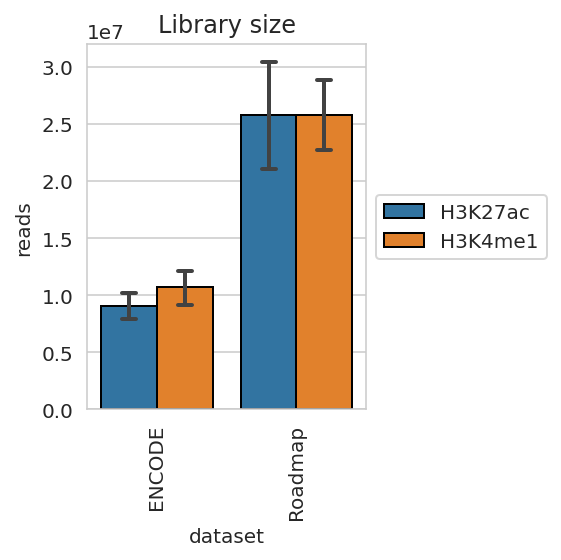

In [39]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams[(df_bams['modification'] == 'H3K27ac') | (df_bams['modification'] == 'H3K4me1')],
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.1, errwidth=2, edgecolor="black",
                        )
# ax.set_ylim(0, 160_000)
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Prepare datasets with wiggling and mixing control data into signal track

In [418]:
# Prepare BAM files

WD = os.path.expanduser('~/data/2023_GSE26320_wiggle_mix')
! mkdir -p {WD}/bed

df_bam_beds = df_bams[(df_bams['modification'].isin(['H3K27ac', 'H3K4me1', 'Control'])) & 
                      # (df_bams['cell'].isin(['GM12878', 'K562', 'Huvec', 'HMEC', 'NHEK'])) & # LIMIT number of peaks
                      (df_bams['replicate'] == 'rep1') &
                      (df_bams['dataset'] == 'ENCODE')].copy()
df_bam_beds

bam_file modification     cell  \
2   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     NHEK   
5   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     K562   
10  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     HMEC   
12  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     HMEC   
13  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  GM12878   
14  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     HSMM   
15  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control       H1   
16  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     HMEC   
17  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac    Huvec   
23  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     NHLF   
25  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1       H1   
26  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac    HepG2   
28  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     NHLF   
29  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     HSMM   
41  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     HSMM   
49  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     NHEK   
51  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac       H1   
53  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control    HepG2   
55  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     K562   
58  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     K562   
59  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHEK   
70  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1    HepG2   
71  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     NHLF   
72  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  GM12878   
78  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control    Huvec   
95  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1    Huvec   
98  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control  GM12878   

   replicate     reads dataset  
2       rep1   9377615  ENCODE  
5       rep1  10381382  ENCODE  
10      rep1   3750119  ENCODE  
12      rep1  10940745  ENCODE  
13      rep1  11008158  ENCODE  
14      rep1   8080332  ENCODE  
15      rep1  10076569  ENCODE  
16      rep1  16351916  ENCODE  
17      rep1  12283487  ENCODE  
23      rep1   3235572  ENCODE  
25      rep1   8443445  ENCODE  
26      rep1   7474026  ENCODE  
28      rep1   7915513  ENCODE  
29      rep1  11291330  ENCODE  
41      rep1  10745462  ENCODE  
49      rep1   8094298  ENCODE  
51      rep1  13632742  ENCODE  
53      rep1   9110760  ENCODE  
55      rep1   9537695  ENCODE  
58      rep1  11704712  ENCODE  
59      rep1   8817516  ENCODE  
70      rep1  13707399  ENCODE  
71      rep1   4554228  ENCODE  
72      rep1   7049058  ENCODE  
78      rep1  10247593  ENCODE  
95      rep1  10460235  ENCODE  
98      rep1   5699825  ENCODE

In [419]:
beds = []
for _, (bam_file, m, c, r, _, _) in df_bam_beds.iterrows():
    bed_file = f'{WD}/bed/{os.path.basename(bam_file).replace(".bam", ".bed")}'
    print(bed_file)
    beds.append(bed_file)
    if not os.path.exists(bed_file):
        ! bamToBed -i {bam_file} > {bed_file}
df_bam_beds['bed_file'] = beds
df_bam_beds.sample(3)

/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646456_NHEK_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646452_K562_Input_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646390_HMEC_Input_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646374_HMEC_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646322_GM12878_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646400_HSMM_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646351_H1_Input_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646380_HMEC_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646414_Huvec_H3K27ac_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646492_NHLF_Input_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646341_H1_H3K4me1_rep1.bed
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646355_HepG2_H3K27ac_rep1.bed
/home/jetbrains/data/20

bam_file modification  cell  \
59  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  NHEK   
16  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  HMEC   
12  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  HMEC   

   replicate     reads dataset  \
59      rep1   8817516  ENCODE   
16      rep1  16351916  ENCODE   
12      rep1  10940745  ENCODE   

                                             bed_file  
59  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...  
16  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...  
12  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...

## Wiggle

In [420]:
! mkdir -p {WD}/bams

tf1 = tempfile.mktemp()
tf2 = tempfile.mktemp()
tf3 = tempfile.mktemp()
tf4 = tempfile.mktemp()

# NUPSCALE = 100
NUPSCALE = 20

# for var_upscale, var_wiggle in tqdm(product([1, 1.5, 2], [0, 5000, 2000])):
for var_upscale, var_wiggle in tqdm(product([1, 2], [0, 5000])):
    if var_upscale == 1 and var_wiggle == 0:
        continue
    var_name = '' if var_upscale == 1 else f'x{var_upscale}_N{NUPSCALE}'
    if var_wiggle != 0:
        if var_name != '':
            var_name += '_'
        var_name += f'w80_20_N{var_wiggle}'
    print('upscale', var_upscale, 'wiggle', var_wiggle, 'Type', var_name)

    wiggles = []
    for _, row in tqdm(df_bam_beds.iterrows()):
        bam_file, m, c, r, bed_file = row['bam_file'], row['modification'], row['cell'], row['replicate'], row['bed_file']
        print(var_name, m, c, r, bed_file)
        if m == 'Control':
            wiggles.append(None)
            ! ln -sf {bam_file} {WD}/bams/{os.path.basename(bam_file)} 
            continue
        cs = 0.8 
        cw = 1.0 - cs    
        print('Signal', cs, 'wiggle', cw)
        result_file = f'{WD}/bams/{m}_{c}_{r}_{var_name}.bam'
        wiggles.append(result_file)
        print(result_file)
        if os.path.exists(result_file):
            continue
        t = pd.read_csv(bed_file, sep='\t', header=None)
        print('Reads', len(t))
    
        if var_upscale != 1:
            print('Upscale coverage')
            if var_upscale == 2:
                t_copy = t.copy()  # Double coverage
            elif var_upscale == 1.5:
                t_copy = t.sample(int(len(t) * 0.5)).copy() # +50% coverage
            else:
                raise Exception(f'Unknown var_upscale {var_upscale}')
            delta_small = [int(x) for x in np.random.normal(0, NUPSCALE, size=len(t_copy))]
            t_copy[1] += delta_small
            t_copy[2] += delta_small
            del delta_small
            # Ensure generated reads have proper coordinates
            t_copy.loc[t_copy[1] < 1, 1] = 1
            t_copy.loc[t_copy[2] < 1, 2] = 1
            t = pd.concat([t, t_copy]).reset_index(drop=True) 
            print('Upscaled coverage', len(t))
        
        if var_wiggle != 0:
            print('wiggle')
            signal = t.sample(int(len(t) * cs))
            noise = t.sample(int(len(t) * cw))
            delta = [int(x) for x in np.random.normal(0, var_wiggle, size=len(noise))]
            noise[1] += delta
            noise[2] += delta
            # Ensure generated reads have proper coordinates
            noise.loc[noise[1] < 1, 1] = 1
            noise.loc[noise[2] < 1, 2] = 1
            signal.to_csv(tf1, sep='\t', index=False, header=None)
            noise.to_csv(tf2, sep='\t', index=False, header=None)
            del t, signal, noise, delta
            ! cat {tf1} > {tf3}
            ! cat {tf2} >> {tf3}
            ! rm {tf1} {tf2}
        else:
            t.to_csv(tf3, sep='\t', index=False, header=None)
            del t
        ! cat {tf3} | sort -k1,1 -k2,2n -k3,3n > {tf4}
        ! rm {tf3}
        ! bedToBam -i {tf4} -g {WD}/hg38.chrom.sizes > {result_file}
        ! rm {tf4}
        print('Done', result_file)
    df_bam_beds[var_name] = wiggles
df_bam_beds.sample(3)

0it [00:00, ?it/s]

upscale 1 wiggle 5000 Type w80_20_N5000


0it [00:00, ?it/s]

w80_20_N5000 H3K27ac NHEK rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646456_NHEK_H3K27ac_rep1.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_NHEK_rep1_w80_20_N5000.bam
w80_20_N5000 Control K562 rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646452_K562_Input_rep1.bed
w80_20_N5000 Control HMEC rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646390_HMEC_Input_rep1.bed
w80_20_N5000 H3K27ac HMEC rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646374_HMEC_H3K27ac_rep1.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HMEC_rep1_w80_20_N5000.bam
w80_20_N5000 H3K4me1 GM12878 rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646322_GM12878_H3K4me1_rep1.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K4me1_GM12878_rep1_w80_20_N5000.bam
w80_20_N5000 H3K4me1 HSMM rep1 /home/jetbrains/data/2023_G

0it [00:00, ?it/s]

x2_N20 H3K27ac NHEK rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646456_NHEK_H3K27ac_rep1.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_NHEK_rep1_x2_N20.bam
Reads 9377615
Upscale coverage
Upscaled coverage 18755230
Done /home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_NHEK_rep1_x2_N20.bam
x2_N20 Control K562 rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646452_K562_Input_rep1.bed
x2_N20 Control HMEC rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646390_HMEC_Input_rep1.bed
x2_N20 H3K27ac HMEC rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646374_HMEC_H3K27ac_rep1.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HMEC_rep1_x2_N20.bam
Reads 10940745
Upscale coverage
Upscaled coverage 21881490
Done /home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HMEC_rep1_x2_N20.bam
x2_N20 H3K4me1 GM12878 rep1 /home/jetbrains/data/2023

0it [00:00, ?it/s]

x2_N20_w80_20_N5000 H3K27ac NHEK rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646456_NHEK_H3K27ac_rep1.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_NHEK_rep1_x2_N20_w80_20_N5000.bam
Reads 9377615
Upscale coverage
Upscaled coverage 18755230
wiggle
Done /home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_NHEK_rep1_x2_N20_w80_20_N5000.bam
x2_N20_w80_20_N5000 Control K562 rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646452_K562_Input_rep1.bed
x2_N20_w80_20_N5000 Control HMEC rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646390_HMEC_Input_rep1.bed
x2_N20_w80_20_N5000 H3K27ac HMEC rep1 /home/jetbrains/data/2023_GSE26320_wiggle_mix/bed/GSM646374_HMEC_H3K27ac_rep1.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bams/H3K27ac_HMEC_rep1_x2_N20_w80_20_N5000.bam
Reads 10940745
Upscale coverage
Upscaled coverage 21881490
wiggle
Done /home/jetbrains/data/2023_GS

bam_file modification  cell  \
23  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control  NHLF   
2   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac  NHEK   
55  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1  K562   

   replicate    reads dataset  \
23      rep1  3235572  ENCODE   
2       rep1  9377615  ENCODE   
55      rep1  9537695  ENCODE   

                                             bed_file  \
23  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
2   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
55  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   

                                         w80_20_N5000  \
23                                               None   
2   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
55  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   

                                               x2_N20  \
23                                               None   
2   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   
55  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...   

                                  x2_N20_w80_20_N5000  
23                                               None  
2   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...  
55  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...

## Mix control

In [91]:
# mixtures = []
# for _, row in tqdm(df_bam_beds.iterrows()):
#     bam_file, m, c, r, bed_file = row['bam_file'], row['modification'], row['cell'], row['replicate'], row['bed_file']
#     if m == 'Control':
#         mixtures.append(None)
#         continue
#     print('Mix', m, c, r)
#     result_file = f'{WD}/bams/{m}_{c}_{r}_mix.bam'
#     mixtures.append(result_file)
#     print(result_file)
#     if os.path.exists(result_file):
#         continue
#     control_file = df_bam_beds[(df_bam_beds['cell'] == c) & 
#                                (df_bam_beds['replicate'] == r) & 
#                                (df_bam_beds['modification'] == 'Control')]['bed_file'].values[0]
#     signal = pd.read_csv(bed_file, sep='\t', header=None)
#     noise = pd.read_csv(control_file, sep='\t', header=None)
#     signal_reads = len(signal)
#     control_reads = len(noise)
#     print('Signal', bed_file, signal_reads)
#     print('Control', control_file, control_reads)
#     signal = signal.sample(int(signal_reads * 0.5))
#     noise = noise.sample(min(signal_reads, int(control_reads * 0.5)))
#     signal.to_csv(tf1, sep='\t', index=False, header=None)
#     noise.to_csv(tf2, sep='\t', index=False, header=None)
#     ! cat {tf1} > {tf3}
#     ! cat {tf2} >> {tf3}
#     ! rm {tf1} {tf2}
#     ! cat {tf3} | sort -k1,1 -k2,2n -k3,3n > {tf4}
#     ! rm {tf3}
#     ! bedToBam -i {tf4} -g {WD}/hg38.chrom.sizes > {result_file}
#     ! rm {tf4}
#     del signal, noise
#     print('Done')
# 
# df_bam_beds['mix'] = mixtures 
# df_bam_beds.sample(3)

In [670]:
df_wiggle_bams = load_bams(WD + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
df_wiggle_bams.sample(3)

  0%|          | 0/126 [00:00<?, ?it/s]

bam_file modification     cell  \
52  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHLF   
38  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  GM12878   
5   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HSMM   

   replicate     reads  
52      rep1  15831026  
38      rep1  22016316  
5       rep1  22582659

In [671]:
df_wiggle_bams['type'] = [re.sub('.*rep1_|\.bam|_q.*|-W.*|_broad.*|_100_.*', '', os.path.basename(f)) for f in df_wiggle_bams['bam_file']]
df_wiggle_bams['upscale'] = [None if 'x' not in ty else float(re.sub('x|_N.*', '', ty)) for ty in df_wiggle_bams['type']]
df_wiggle_bams['wiggle'] = [None if 'w' not in ty else int(re.sub('.*_N', '', ty)) for ty in df_wiggle_bams['type']]
# Limit to x2_N20 and wiggle 5000
df_wiggle_bams = df_wiggle_bams[(df_wiggle_bams['upscale'] != 1.5) &
                                (~df_wiggle_bams['type'].str.contains('N100')) &
                                (df_wiggle_bams['wiggle'] != 2000)]

df_wiggle_bams

bam_file modification     cell  \
0   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
1   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    HepG2   
2   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
3   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1       H1   
4   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  GM12878   
5   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HSMM   
6   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HSMM   
7   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HSMM   
8   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HMEC   
9   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHLF   
10  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac       H1   
11  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHEK   
12  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
13  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
14  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
15  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     K562   
16  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     K562   
17  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
18  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HSMM   
19  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    HepG2   
20  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     K562   
21  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     K562   
22  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    HepG2   
23  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac       H1   
24  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HMEC   
25  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHEK   
26  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac    HepG2   
27  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HMEC   
28  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
29  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHEK   
30  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac    Huvec   
31  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1       H1   
32  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
33  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
34  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHEK   
35  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HSMM   
36  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HSMM   
37  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     K562   
38  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  GM12878   
39  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac    HepG2   
40  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     K562   
41  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  GM12878   
42  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac    Huvec   
43  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac    HepG2   
44  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHEK   
45  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
46  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac    Huvec   
47  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHLF   
48  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac       H1   
49  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     NHLF   
50  /home/jetbra

In [672]:
df_immune_10m_bams = load_bams(IMMUNE_PATH + '_mln_control/bams', ['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, [''], None)
df_immune_10m_bams.sample(3)

  0%|          | 0/10 [00:00<?, ?it/s]

bam_file modification   cell  \
3  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  BCell   
0  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  BCell   
2  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  TCell   

  replicate     reads  
3             9999314  
0             9998693  
2            10002191

In [673]:
t = df_wiggle_bams.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
t['scale'] = t['upscale']

t2 = df_bams[df_bams['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t2['scale'] = [0.5 if ds == 'ENCODE' else 2.5 for ds in t2['dataset']]
t2['wiggle'] = 0.0

t3 = df_immune_10m_bams.copy()
t3['scale'] = 2.2
t3['wiggle'] = 0.0

t = pd.concat([t, t2, t3]).reset_index(drop=True)

H3K27ac
H3K4me1


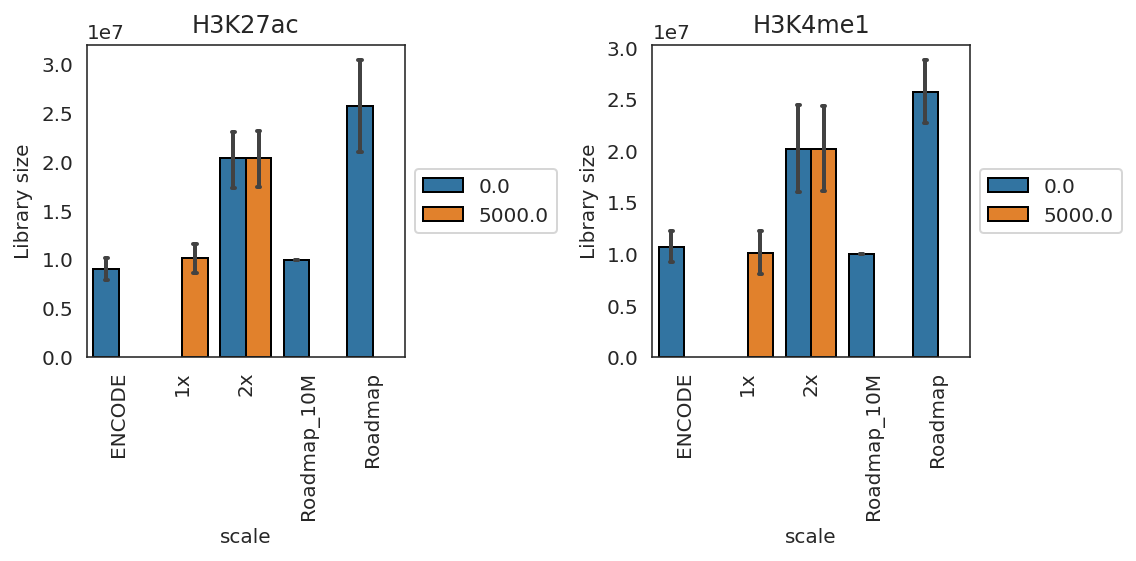

In [675]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]

    g_results = sns.barplot(data=t[t['modification'] == m],
                            hue='wiggle', x='scale', y='reads', ax=ax,
                            capsize=.05, errwidth=2, edgecolor="black",
                        )
    # ax.set_xticklabels(['ENCODE',  '1x', '1.5x', '2x', 'Roadmap_10M', 'Roadmap'])
    ax.set_xticklabels(['ENCODE',  '1x', '2x', 'Roadmap_10M', 'Roadmap'])
    ax.set_title(m)
    ax.set_ylabel('Library size')
    # Put a legend to the right of the current axis
    g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=True sicer=True --rerun-trigger mtime && \
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 

```

# Analyze wiggle and scaling

In [635]:
wiggle_mix_peaks = load_peaks_path(WD, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)

  0%|          | 0/992 [00:00<?, ?it/s]

MACS2 124


  0%|          | 0/992 [00:00<?, ?it/s]

MACS2 broad 124


  0%|          | 0/124 [00:00<?, ?it/s]

SICER 124


  0%|          | 0/127 [00:00<?, ?it/s]

SPAN 124


In [636]:
wiggle_mix_peaks['type'] = [re.sub('.*rep1_|_q.*|-W.*|_broad.*|_100_.*', '', os.path.basename(f)) for f in wiggle_mix_peaks['file']]
wiggle_mix_peaks['upscale'] = [None if 'x' not in ty else float(re.sub('x|_N.*', '', ty)) for ty in wiggle_mix_peaks['type']]
wiggle_mix_peaks['wiggle'] = [None if 'w' not in ty else int(re.sub('.*_N', '', ty)) for ty in wiggle_mix_peaks['type']]
# Limit to x2_N20 and wiggle 5000
wiggle_mix_peaks = wiggle_mix_peaks[(wiggle_mix_peaks['upscale'] != 1.5) & 
                                    (~wiggle_mix_peaks['type'].str.contains('N100')) &
                                    (wiggle_mix_peaks['wiggle'] != 2000)]
wiggle_mix_peaks.sample(5)

file modification  cell  \
386  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    H1   
121  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  HMEC   
243  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  NHEK   
148  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  NHLF   
66   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  HSMM   

    replicate   peaks         tool                 type  upscale  wiggle  
386      rep1   85352         SPAN  x2_N20_w80_20_N5000      2.0  5000.0  
121      rep1   33000        MACS2  x2_N20_w80_20_N5000      2.0  5000.0  
243      rep1  121127  MACS2 broad               x2_N20      2.0     NaN  
148      rep1   32754  MACS2 broad               x2_N20      2.0     NaN  
66       rep1   56033        MACS2               x2_N20      2.0     NaN

In [773]:
t = wiggle_mix_peaks.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
t['scale'] = t['upscale']
t2 = df_peaks[(df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])) & 
              (df_peaks['dataset'] == 'ENCODE') &
              (df_peaks['replicate'] == 'rep1')].copy()
t2['scale'] = 0.5
t2['upscale'] = 1.0
t2['wiggle'] = 0.0
t2['type'] = 'ENCODE'
wiggle_mix_original_peaks = pd.concat([t2, t]).reset_index(drop=True)
wiggle_mix_original_peaks

file modification     cell  \
0    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac       H1   
1    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac    HepG2   
2    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     HMEC   
3    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac     K562   
4    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     HSMM   
..                                                 ...          ...      ...   
283  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
284  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
285  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    HepG2   
286  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
287  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HSMM   

    replicate  peaks   tool dataset  scale  upscale  wiggle  \
0        rep1  17497  MACS2  ENCODE    0.5      1.0     0.0   
1        rep1  48652  MACS2  ENCODE    0.5      1.0     0.0   
2        rep1  10256  MACS2  ENCODE    0.5      1.0     0.0   
3        rep1  53699  MACS2  ENCODE    0.5      1.0     0.0   
4        rep1  58144  MACS2  ENCODE    0.5      1.0     0.0   
..        ...    ...    ...     ...    ...      ...     ...   
283      rep1  74982   SPAN     NaN    2.0      2.0  5000.0   
284      rep1  34906   SPAN     NaN    2.0      2.0  5000.0   
285      rep1  81440   SPAN     NaN    2.0      2.0  5000.0   
286      rep1  80085   SPAN     NaN    2.0      2.0     0.0   
287      rep1  46020   SPAN     NaN    2.0      2.0  5000.0   

                    type  
0                 ENCODE  
1                 ENCODE  
2                 ENCODE  
3                 ENCODE  
4                 ENCODE  
..                   ...  
283  x2_N20_w80_20_N5000  
284  x2_N20_w80_20_N5000  
285  x2_N20_w80_20_N5000  
286               x2_N20  
287  x2_N20_w80_20_N5000  

[288 rows x 11 columns]

H3K27ac HepG2
H3K27ac K562
H3K27ac H1
H3K27ac NHEK
H3K27ac GM12878
H3K27ac NHLF
H3K27ac Huvec
H3K27ac HSMM
H3K27ac HMEC
H3K4me1 HepG2
H3K4me1 K562
H3K4me1 H1
H3K4me1 NHEK
H3K4me1 GM12878
H3K4me1 NHLF
H3K4me1 Huvec
H3K4me1 HSMM
H3K4me1 HMEC


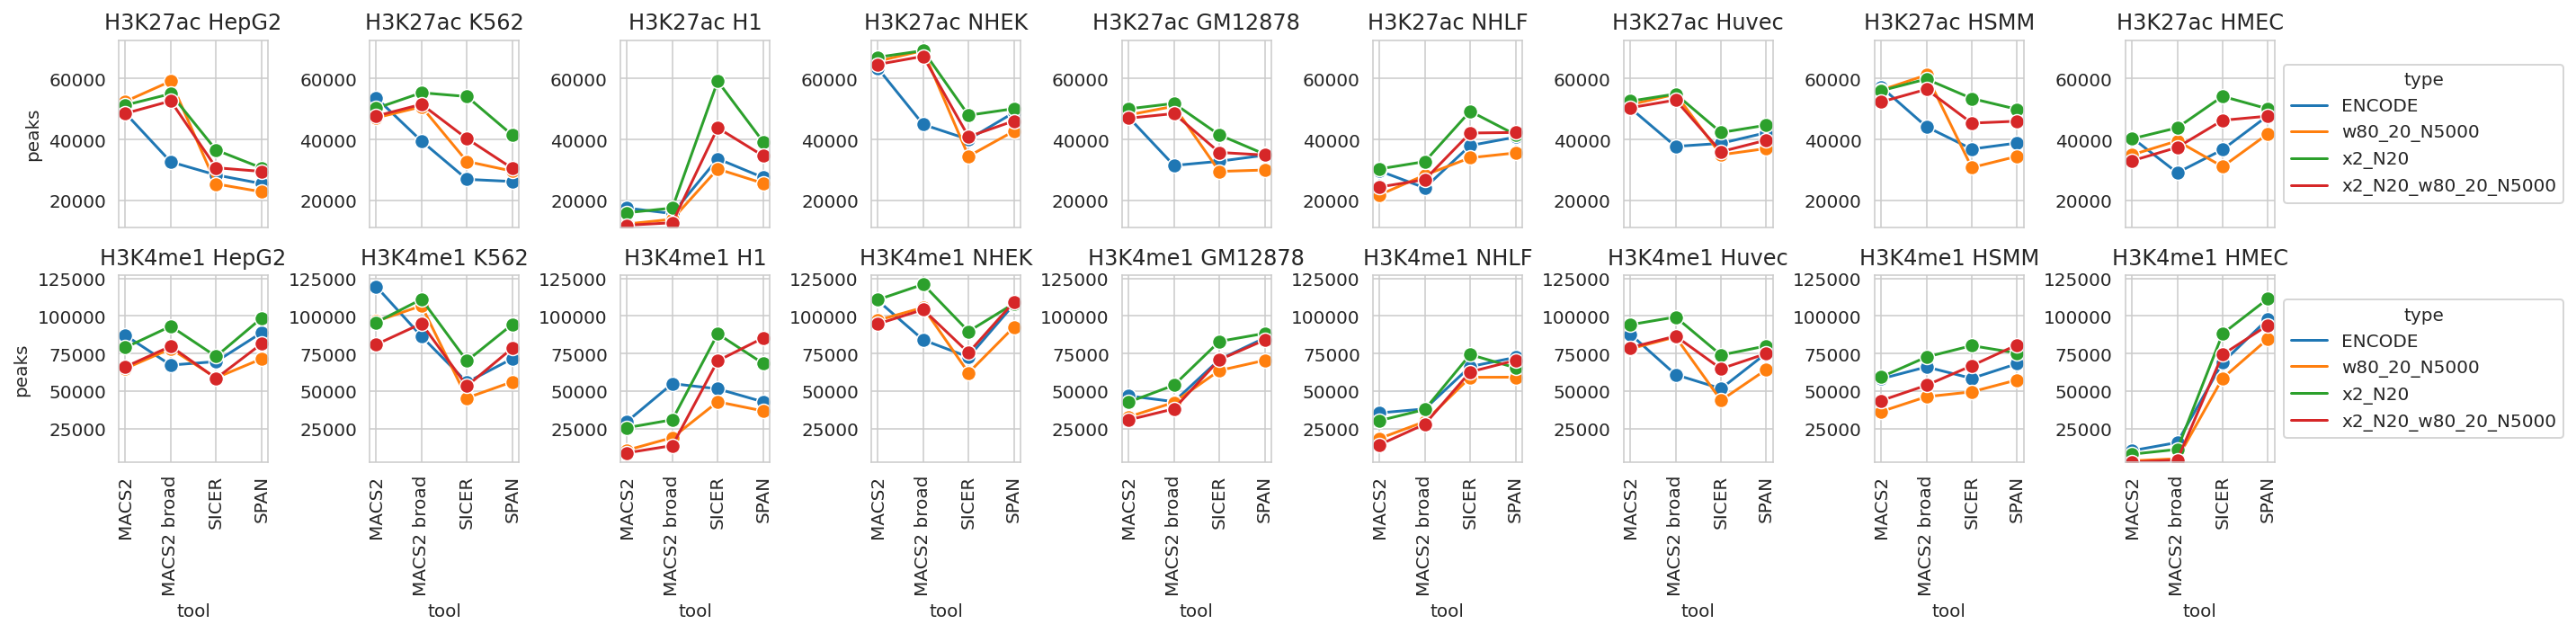

In [700]:
plt.figure(figsize=(20, 5))
CELLS = list(wiggle_mix_peaks['cell'].unique())
# CELLS = ['GM12878', 'K562', 'Huvec'] 
axs = [plt.subplot(2, len(CELLS), i + 1) for i in range(2 * len(CELLS))]

for i, (m, c) in enumerate(product(['H3K27ac', 'H3K4me1'], CELLS)):
    print(m, c)
    ax = axs[i]
    g_results = sns.lineplot(data=wiggle_mix_original_peaks[(wiggle_mix_original_peaks['modification']==m) &
                                                            (wiggle_mix_original_peaks['cell'].isin([c]))],
                             x='tool', y='peaks', hue='type',
                             hue_order=list(sorted(wiggle_mix_original_peaks['type'].unique())),
                             ax=ax,
                             # errorbar='se', 
                             marker='o', markersize=8
                             )
    if (i + 1) % len(CELLS) != 0:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if i % len(CELLS) != 0:
        ax.set_ylabel(None)
    if i < len(CELLS):
        # ax.set_xticks([], minor=False)
        g_results.axes.set_xticklabels([])   
        ax.set_xlabel(None)
    else:
        ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{m} {c}')
    ax.set_ylim(bottom = 0.95 * wiggle_mix_original_peaks[wiggle_mix_original_peaks['modification']==m]['peaks'].min(),
                top = 1.05 * wiggle_mix_original_peaks[wiggle_mix_original_peaks['modification']==m]['peaks'].max())
plt.tight_layout()
plt.show()

## Peaks lengths

In [735]:
print('Load lengths')
ts = []
for file, m, c, r, ty, tool in tqdm(zip(
        wiggle_mix_original_peaks['file'],
        wiggle_mix_original_peaks['modification'],
        wiggle_mix_original_peaks['cell'],
        wiggle_mix_original_peaks['replicate'],
        wiggle_mix_original_peaks['type'],
        wiggle_mix_original_peaks['tool']
)):
    # if c in ['H1', 'GM12878', 'HSMM', 'NHLF', 'HMEC']:
    #     continue
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 1000)).copy()
    t['modification'] = m
    t['cell'] = c
    t['replicate'] = r
    t['type'] = ty
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length modification   cell replicate                 type         tool
62242      300      H3K4me1  HepG2      rep1  x2_N20_w80_20_N5000  MACS2 broad
2351       672      H3K4me1   NHEK      rep1               ENCODE        MACS2
72640      405      H3K27ac  HepG2      rep1         w80_20_N5000  MACS2 broad
73342     2826      H3K27ac  Huvec      rep1         w80_20_N5000  MACS2 broad
122701    2604      H3K4me1   K562      rep1  x2_N20_w80_20_N5000         SPAN
33349      209      H3K4me1   K562      rep1               x2_N20        MACS2
123371     869      H3K27ac   NHEK      rep1         w80_20_N5000         SPAN
27070      976      H3K27ac  Huvec      rep1               ENCODE         SPAN
30971      442      H3K27ac   NHEK      rep1               ENCODE         SPAN
21366     1999      H3K27ac  Huvec      rep1               ENCODE        SICER

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac MACS2
H3K27ac MACS2 broad


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac SPAN
H3K27ac SICER


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 MACS2
H3K4me1 MACS2 broad


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 SPAN
H3K4me1 SICER


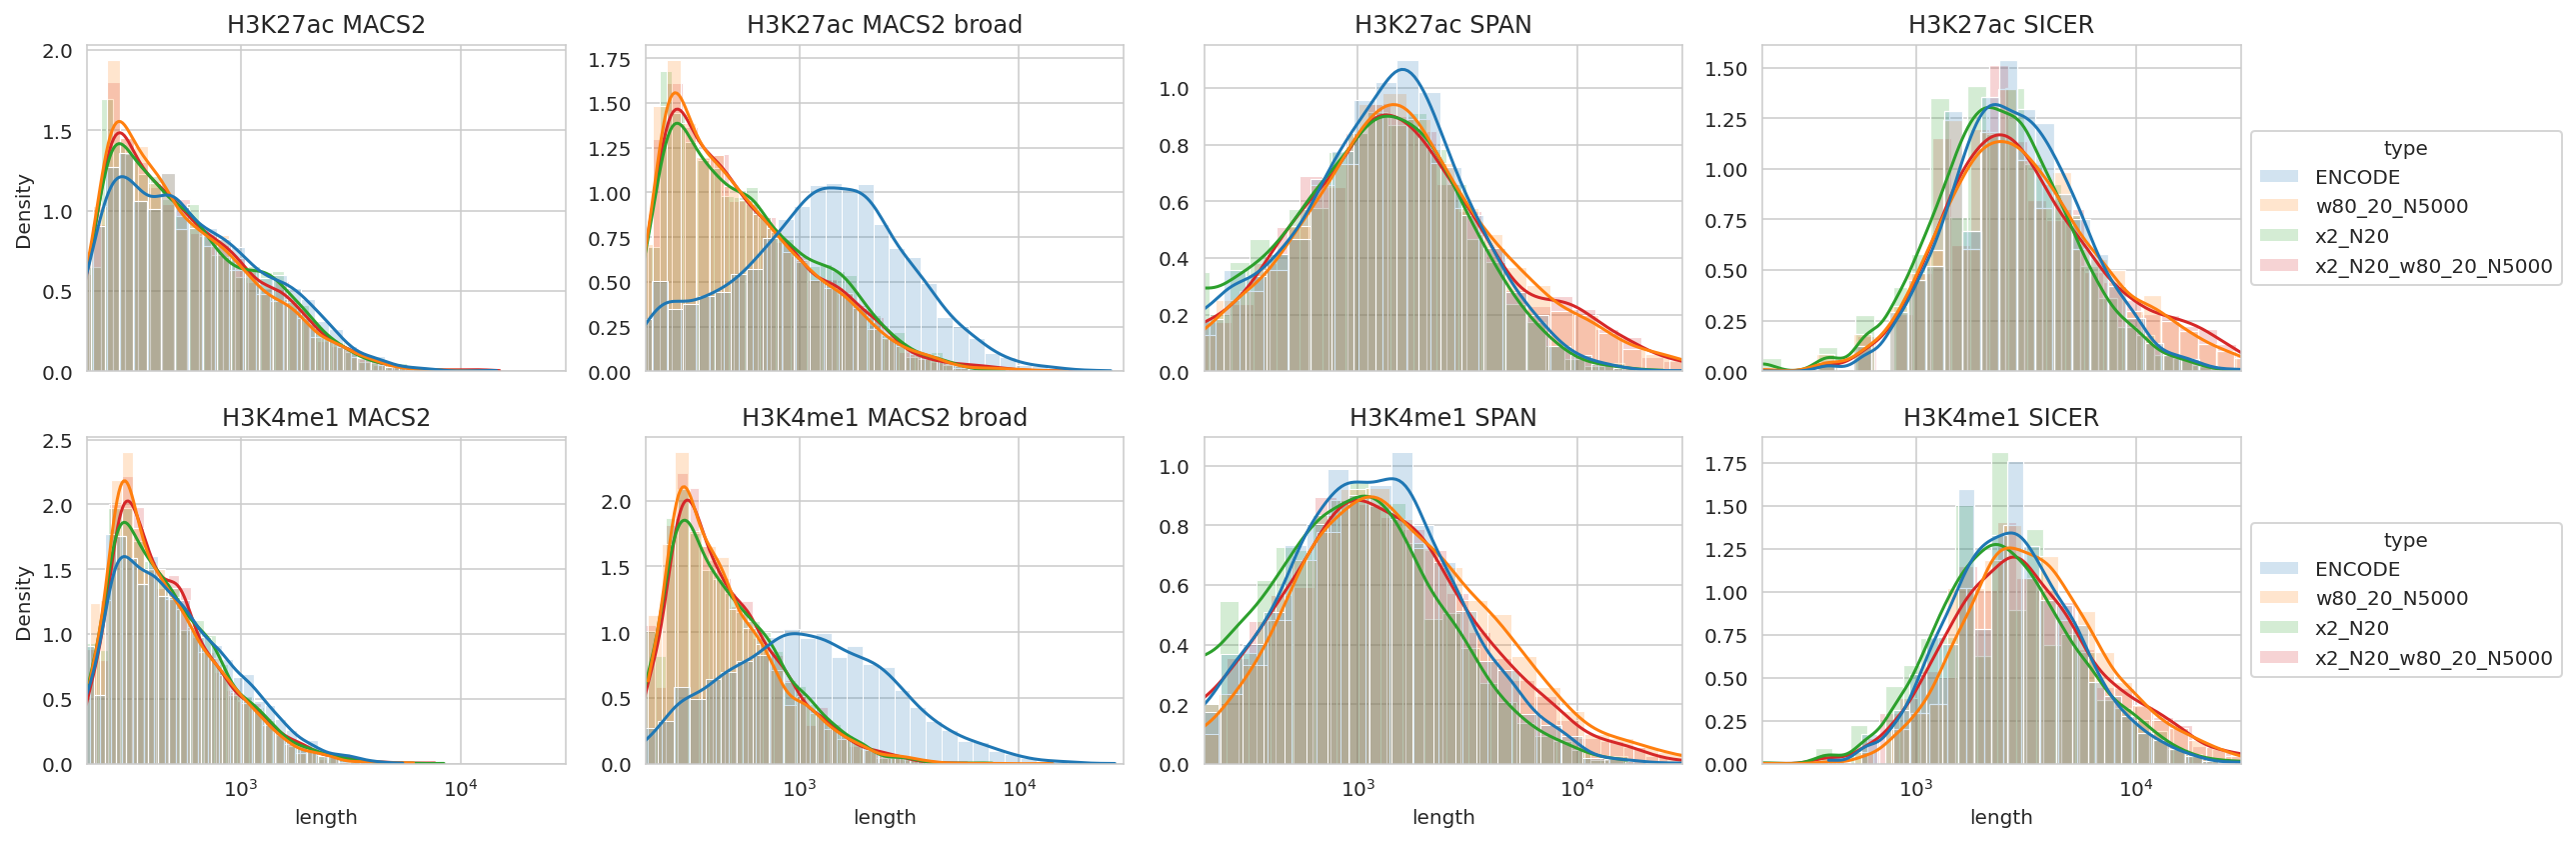

In [736]:
plt.figure(figsize=(18, 6))
CELLS = list(wiggle_mix_peaks['cell'].unique())
axs = [plt.subplot(2, len(TOOLS), i + 1) for i in range(2 * len(TOOLS))]

for i, (m, tool) in enumerate(product(['H3K27ac', 'H3K4me1'], TOOLS)):
    print(m, tool)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification']==m) &
                                    (t['tool'].isin([tool]))],
                             x='length', hue='type',
                             hue_order=list(sorted(t['type'].unique())),
                             ax=ax, stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2
                             )
    if (i + 1) % len(TOOLS) != 0:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if i % len(TOOLS) != 0:
        ax.set_ylabel(None)
    if i < len(TOOLS):
        # ax.set_xticks([], minor=False)
        g_results.axes.set_xticklabels([])
        ax.set_xlabel(None)
    ax.set_title(f'{m} {tool}')
    ax.set_xlim(2e2, 3e4)
plt.tight_layout()
plt.show()

H3K27ac MACS2
H3K27ac MACS2 broad
H3K27ac SPAN
H3K27ac SICER
H3K4me1 MACS2
H3K4me1 MACS2 broad
H3K4me1 SPAN
H3K4me1 SICER


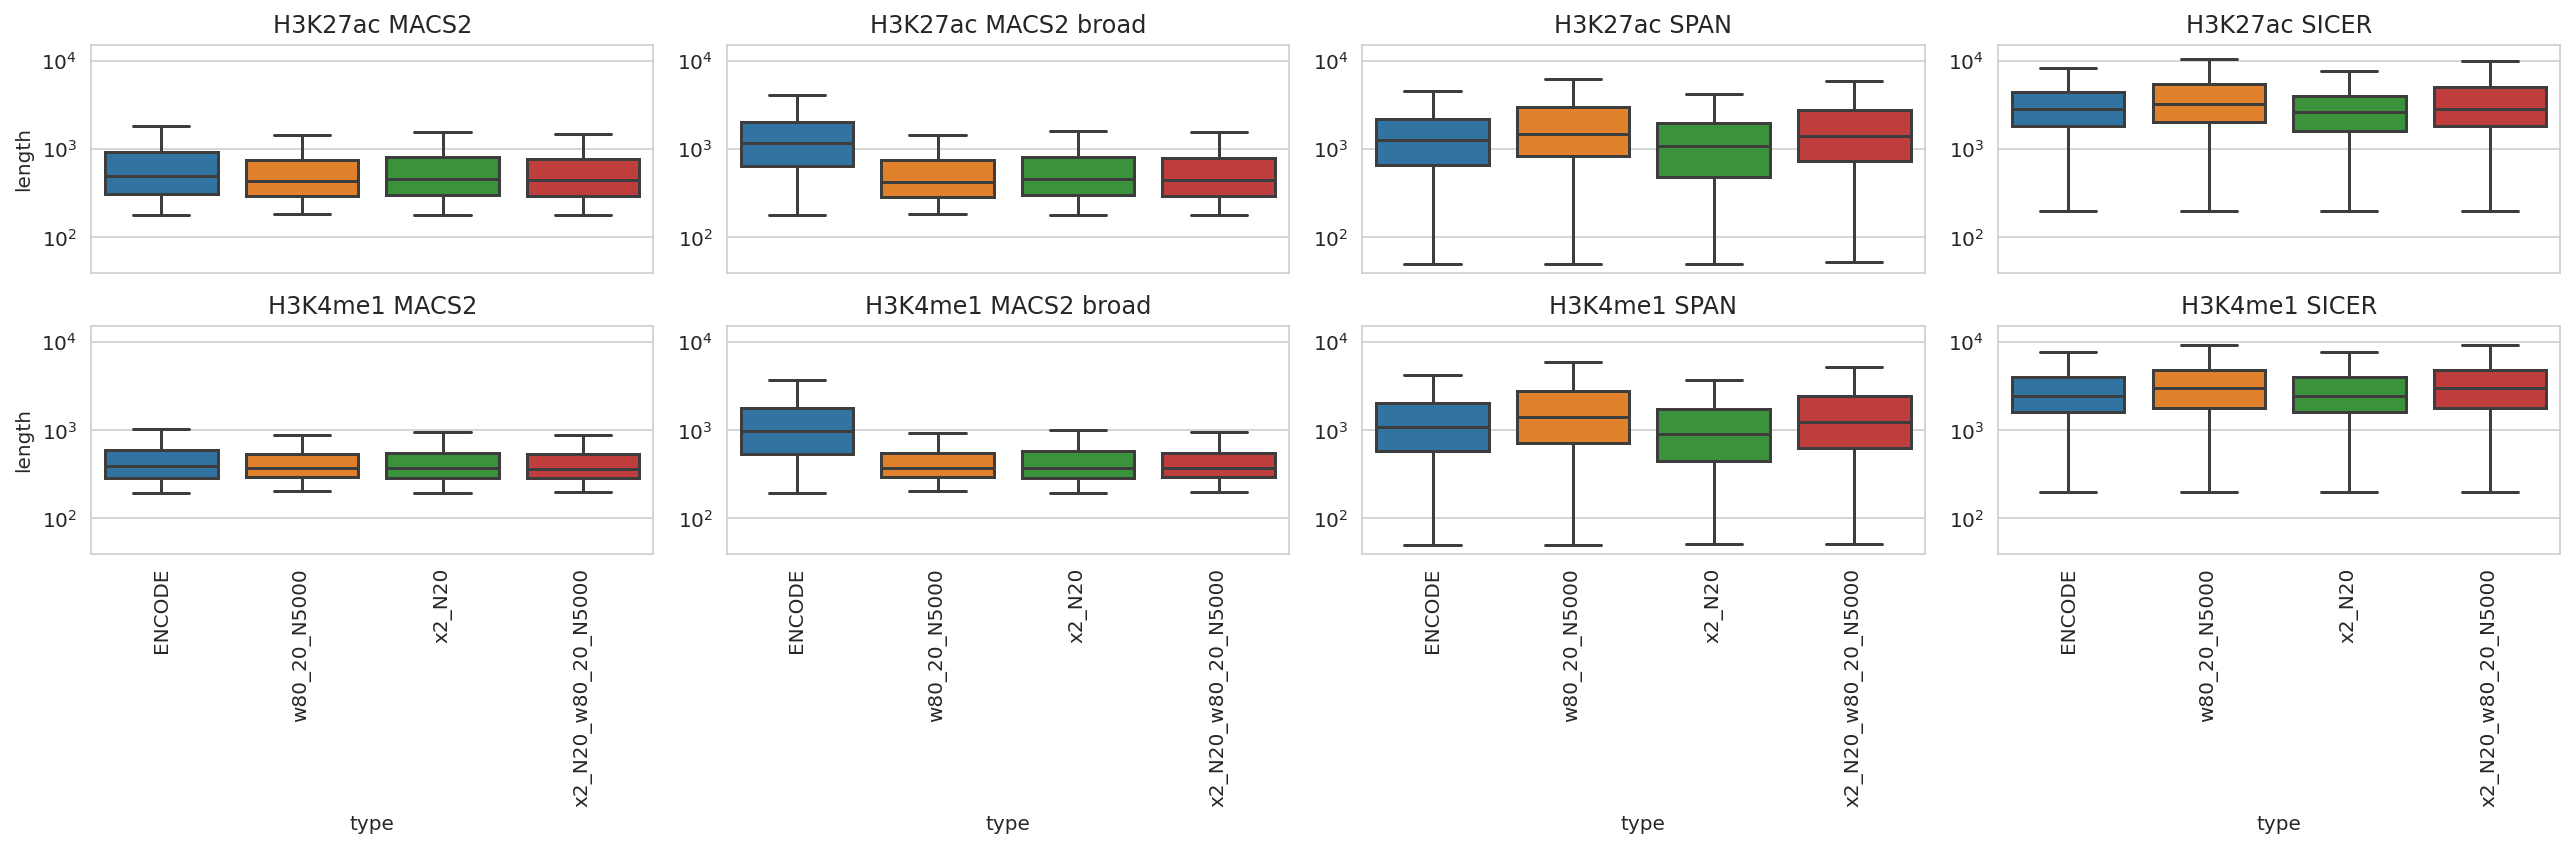

In [641]:
plt.figure(figsize=(18, 6))
TYPES = list(sorted(t['type'].unique()))
CELLS = list(wiggle_mix_peaks['cell'].unique())
axs = [plt.subplot(2, len(TOOLS), i + 1) for i in range(2 * len(TOOLS))]

for i, (m, tool) in enumerate(product(['H3K27ac', 'H3K4me1'], TOOLS)):
    print(m, tool)
    ax = axs[i]
    g_results = sns.boxplot(data=t[(t['modification']==m) &
                                    (t['tool'].isin([tool]))],
                             y='length', x='type',
                             showfliers=False,
                             order=TYPES,
                             ax=ax, 
                             )
    if i not in [0, len(TOOLS)]:
        ax.set_ylabel(None)
    if i < len(TOOLS):
        g_results.axes.set_xticklabels([])
        ax.set_xlabel(None)
    else:
        ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{m} {tool}')
    ax.set(yscale='log')
    ax.set_ylim(bottom=40, top=1.5e4)
plt.tight_layout()
plt.show()

## Compute union peaks

In [886]:
t2 = df_peaks[(df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])) &
              (df_peaks['dataset'] == 'Roadmap') &
              (df_peaks['replicate'] == '')].copy()
t2['scale'] = 2.5
t2['upscale'] = 1.0
t2['wiggle'] = 0.0
t2['type'] = 'Roadmap'

t3 = df_downsample[(df_downsample['reads'] == '10M') & 
                   (df_downsample['modification'].isin(['H3K27ac', 'H3K4me1']))].copy()
t3['scale'] = 2.2
t3['upscale'] = 0.5
t3['wiggle'] = 0.0
t3['type'] = 'Roadmap_10M'

wiggle_mix_original_all_peaks = pd.concat([t2, t3, wiggle_mix_original_peaks]).reset_index(drop=True)
wiggle_mix_original_all_peaks

file modification     cell  \
0    /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me1    TCell   
1    /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K4me1    BCell   
2    /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K27ac    TCell   
3    /home/jetbrains/data/2023_Immune/macs2/BCell_H...      H3K27ac    BCell   
4    /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K27ac    TCell   
..                                                 ...          ...      ...   
315  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
316  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
317  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    HepG2   
318  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
319  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     HSMM   

    replicate   peaks         tool  dataset  scale  upscale  wiggle  \
0              158205        MACS2  Roadmap    2.5      1.0     0.0   
1              141414        MACS2  Roadmap    2.5      1.0     0.0   
2               57350        MACS2  Roadmap    2.5      1.0     0.0   
3               45626        MACS2  Roadmap    2.5      1.0     0.0   
4               51740  MACS2 broad  Roadmap    2.5      1.0     0.0   
..        ...     ...          ...      ...    ...      ...     ...   
315      rep1   74982         SPAN      NaN    2.0      2.0  5000.0   
316      rep1   34906         SPAN      NaN    2.0      2.0  5000.0   
317      rep1   81440         SPAN      NaN    2.0      2.0  5000.0   
318      rep1   80085         SPAN      NaN    2.0      2.0     0.0   
319      rep1   46020         SPAN      NaN    2.0      2.0  5000.0   

                    type  quality reads  
0                Roadmap      NaN   NaN  
1                Roadmap      NaN   NaN  
2                Roadmap      NaN   NaN  
3                Roadmap      NaN   NaN  
4                Roadmap      NaN   NaN  
..                   ...      ...   ...  
315  x2_N20_w80_20_N5000      NaN   NaN  
316  x2_N20_w80_20_N5000      NaN   NaN  
317  x2_N20_w80_20_N5000      NaN   NaN  
318               x2_N20      NaN   NaN  
319  x2_N20_w80_20_N5000      NaN   NaN  

[320 rows x 13 columns]

In [818]:
! mkdir -p {WD}/union

for _, (m, c, r, ty) in tqdm(wiggle_mix_original_all_peaks[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows()):
    print(m, c, r, ty)
    t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['modification'] == m) &
                                      (wiggle_mix_original_all_peaks['cell'] == c) &
                                      (wiggle_mix_original_all_peaks['replicate'] == r) &
                                      (wiggle_mix_original_all_peaks['type'] == ty)]
    if len(t) == 0:
        continue
    # Prepare total overlap
    union_path = f'{WD}/union/{m}_{c}_{r}_{ty}.bed'
    print(union_path)
    if os.path.exists(union_path):
        continue
    try:
        files = t[t['tool'] == 'SPAN']['file']
        t_span = sorted_file(files.values[0]) if len(files) == 1 else ''
        files = t[t['tool'] == 'MACS2']['file']
        t_macs2 = sorted_file(files.values[0]) if len(files) == 1 else ''
        files = t[t['tool'] == 'MACS2 broad']['file']
        t_macs2broad = sorted_file(files.values[0]) if len(files) == 1 else ''
        files = t[t['tool'] == 'SICER']['file']
        t_sicer = sorted_file(files.values[0]) if len(files) == 1 else ''
        tf = tempfile.mktemp()
        ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
        ! bedtools merge -i {tf} > {union_path}
        ! rm {tf}
    except Exception as e:
        print(e)
        break

0it [00:00, ?it/s]

H3K4me1 TCell  Roadmap
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K4me1_TCell__Roadmap.bed
H3K4me1 BCell  Roadmap
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K4me1_BCell__Roadmap.bed
H3K27ac TCell  Roadmap
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_TCell__Roadmap.bed
H3K27ac BCell  Roadmap
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_BCell__Roadmap.bed
H3K4me1 BCell  Roadmap_10M
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K4me1_BCell__Roadmap_10M.bed
H3K4me1 TCell  Roadmap_10M
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K4me1_TCell__Roadmap_10M.bed
H3K27ac BCell  Roadmap_10M
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_BCell__Roadmap_10M.bed
H3K27ac TCell  Roadmap_10M
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_TCell__Roadmap_10M.bed
H3K27ac H1 rep1 ENCODE
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_H1_rep1_ENCODE.bed
H3K27ac HepG2 rep1 ENCODE
/home/jetbrains/data/202

## Find bigwigs

In [643]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}


def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [644]:
encode_bws = load_bws(GSE26320_PATH + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
encode_bws['dataset'] = 'ENCODE'
display(encode_bws.sample(3))

immune_bws = load_bws(IMMUNE_PATH + '/bw', MODIFICATIONS, IMMUNE_CELLS, [''], None)
immune_bws['dataset'] = 'Roadmap'
display(immune_bws.sample(3))

  0%|          | 0/103 [00:00<?, ?it/s]

file modification   cell  \
30  /home/jetbrains/data/2023_GSE26320/bw/GSM64642...      H3K4me3  Huvec   
83  /home/jetbrains/data/2023_GSE26320/bw/GSM64642...      H3K4me1  Huvec   
53  /home/jetbrains/data/2023_GSE26320/bw/GSM64639...      H3K27ac   HSMM   

   replicate dataset  
30      rep2  ENCODE  
83      rep1  ENCODE  
53      rep1  ENCODE

  0%|          | 0/17 [00:00<?, ?it/s]

file modification   cell  \
6  /home/jetbrains/data/2023_Immune/bw/TCell_H3K2...      H3K27ac  TCell   
7  /home/jetbrains/data/2023_Immune/bw/BCell_H3K4...      H3K4me1  BCell   
9  /home/jetbrains/data/2023_Immune/bw/TCell_H3K4...      H3K4me3  TCell   

  replicate  dataset  
6            Roadmap  
7            Roadmap  
9            Roadmap

In [645]:
immune_10m_bws = load_bws(IMMUNE_PATH + '_mln_control/bw', MODIFICATIONS, IMMUNE_CELLS, [''], None)
immune_10m_bws['dataset'] = 'Roadmap_10M'
display(immune_10m_bws.sample(3))

  0%|          | 0/5 [00:00<?, ?it/s]

file modification   cell  \
0  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1  BCell   
3  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  TCell   
1  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac  BCell   

  replicate      dataset  
0            Roadmap_10M  
3            Roadmap_10M  
1            Roadmap_10M

In [646]:
wiggle_bws = load_bws(WD + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
wiggle_bws['type'] = [re.sub('.*rep1_|\.bw', '', os.path.basename(f)) for f in wiggle_bws['file']]
wiggle_bws['upscale'] = [None if 'x' not in ty else float(re.sub('x|_N.*', '', ty)) for ty in wiggle_bws['type']]
wiggle_bws['wiggle'] = [None if 'w' not in ty else int(re.sub('.*_N', '', ty)) for ty in wiggle_bws['type']]

wiggle_bws.sample(5)

  0%|          | 0/63 [00:00<?, ?it/s]

file modification     cell  \
22  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac       H1   
15  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   
11  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HSMM   
39  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac     NHLF   
27  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  GM12878   

   replicate                 type  upscale  wiggle  
22      rep1         w80_20_N5000      NaN  5000.0  
15      rep1               x2_N20      2.0     NaN  
11      rep1  x2_N20_w80_20_N5000      2.0  5000.0  
39      rep1               x2_N20      2.0     NaN  
27      rep1  x2_N20_w80_20_N5000      2.0  5000.0

In [647]:
t = wiggle_bws.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
t['scale'] = t['upscale']
t2 = encode_bws[(encode_bws['modification'].isin(['H3K27ac', 'H3K4me1'])) & 
                (encode_bws['cell'].isin(CELLS)) & (encode_bws['replicate'] == 'rep1')].copy()
t2['scale'] = 0.5
t2['wiggle'] = 0.0
t2['type'] = 'ENCODE'

t3 = immune_bws[immune_bws['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t3['scale'] = 2.5
t3['wiggle'] = 0.0
t3['type'] = 'Roadmap'

t4 = immune_10m_bws[immune_10m_bws['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t4['scale'] = 2.2
t4['wiggle'] = 0.0
t4['type'] = 'Roadmap_10M'

all_bws = pd.concat([t, t2, t3, t4]).reset_index(drop=True)
all_bws.sample(5)

file modification   cell  \
4   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   NHLF   
52  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   HMEC   
7   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  Huvec   
59  /home/jetbrains/data/2023_GSE26320/bw/GSM64640...      H3K4me1   HSMM   
14  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   K562   

   replicate                 type  upscale  wiggle  scale dataset  
4       rep1         w80_20_N5000      1.0  5000.0    1.0     NaN  
52      rep1               x2_N20      2.0     0.0    2.0     NaN  
7       rep1               x2_N20      2.0     0.0    2.0     NaN  
59      rep1               ENCODE      NaN     0.0    0.5  ENCODE  
14      rep1  x2_N20_w80_20_N5000      2.0  5000.0    2.0     NaN

## Prepare homemade peaks

In [648]:
import math
import pyBigWig

def peak_calling(bw_path, chrom_sizes, blacklist=None, bin=1000, top_bins=5000):
    print('Prepare chromosome indexes')
    chr_indx = {}
    indx = 0
    for chr, chr_size in chrom_sizes.items():
        if '_' in chr:
            continue
        bins = int(math.floor(chr_size / bin))
        chr_indx[chr] = (indx, indx + bins)
        indx += bins
    chromosomes = list(chr_indx.keys())
    # print(chromosomes)
    # print(chr_indx)

    print('Compute binned coverage')    
    binned_coverage = np.zeros(indx)
    with pyBigWig.open(bw_path) as bw:
        for chr, (istart, iend) in chr_indx.items():
            binned_coverage[istart: iend] =\
                np.array([x or 0 for x in bw.stats(chr, 1, CHROM_SIZES[chr], nBins=iend - istart, exact=False, type='sum')])
    
    if blacklist is not None:
        print('Processing blacklisted regions')
        for chr, start, end in zip(blacklist['chr'], blacklist['start'], blacklist['end']):
            if chr not in chr_indx:
                continue
            offset = chr_indx[chr][0]
            for x in range(int(math.floor(start / bin)), int(math.ceil(end / bin)) + 1):
                binned_coverage[min(x - offset, len(binned_coverage) - 1)] = 0
    
    print('Total coverage', binned_coverage.sum())
    print('Split by chromosomes')
    chr_xs = [[] for _ in range(len(chr_indx))]  # Create new array for each chromosome index
    ichr = 0
    for x in np.sort(np.argpartition(binned_coverage, -top_bins)[-top_bins:]):
        while chr_indx[chromosomes[ichr]][1] < x:
            ichr += 1
        chr_xs[ichr].append(x)
    # print(chr_xs)

    print('Collect final peaks')
    peaks = []
    for ichr, xs in enumerate(chr_xs):
        chr = chromosomes[ichr]
        offset = chr_indx[chr][0]
        start = -1
        for i, x in enumerate(xs):
            if i == 0:
                start = x
            elif xs[i - 1] != x - 1:
                peaks.append((chr, (start - offset) * bin, (xs[i - 1] + 1 - offset) * bin))
                start = x
        peaks.append((chr, (start - offset) * bin, (xs[-1] + 1 - offset) * bin))
    return pd.DataFrame(peaks, columns=['chromosome', 'start', 'end'])

# BLACK LISTS:
https://github.com/Boyle-Lab/Blacklist/tree/master/lists

In [649]:
BLACKLIST_PATH = WD + '/hg38-blacklist.v2.bed'
blacklist_df = pd.read_csv(BLACKLIST_PATH, sep='\t', header=None)
blacklist_df.rename({0: 'chr', 1: 'start', 2: 'end'}, axis=1, inplace=True)
blacklist_df

chr     start       end                   3
0    chr10         0     45700     Low Mappability
1    chr10  38481300  38596500  High Signal Region
2    chr10  38782600  38967900  High Signal Region
3    chr10  39901300  41712900  High Signal Region
4    chr10  41838900  42107300  High Signal Region
..     ...       ...       ...                 ...
631   chrY   4343800   4345800  High Signal Region
632   chrY  10246200  11041200  High Signal Region
633   chrY  11072100  11335300  High Signal Region
634   chrY  11486600  11757800  High Signal Region
635   chrY  26637300  57227400  High Signal Region

[636 rows x 4 columns]

In [676]:
bw_path = '/home/jetbrains/data/2023_GSE26320/bw/GSM646394_HSMM_H3K27ac_rep1.bw'
bin=10_000
top_bins=10_000
chrom_sizes_2 = {'chr1': CHROM_SIZES['chr1'], 'chr2': CHROM_SIZES['chr2']}

# print('WITHOUT BLACKLIST')
# display(peak_calling(bw_path, chrom_sizes, bin=bin, top_bins=top_bins))
# 
print('WITH BLACKLIST')
display(peak_calling(bw_path, chrom_sizes_2, blacklist_df, bin, top_bins))

WITH BLACKLIST
Prepare chromosome indexes
Compute binned coverage
Processing blacklisted regions
Total coverage 13356937.7796233
Split by chromosomes
Collect final peaks


chromosome      start        end
0          chr1     810000     830000
1          chr1     940000     970000
2          chr1     990000    1020000
3          chr1    1150000    1160000
4          chr1    1230000    1240000
...         ...        ...        ...
4799       chr2  241480000  241510000
4800       chr2  241540000  241560000
4801       chr2  241600000  241610000
4802       chr2  241620000  241700000
4803       chr2  241720000  241740000

[4804 rows x 3 columns]

In [867]:
! mkdir -p {WD}/homemade

chrom_sizes_3 = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

for _, (m, c, r, ty) in tqdm(all_bws[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows()):
    print(m, c, r, ty)
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['type'] == ty)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    print(bw_path)
    peaks_path = f'{WD}/homemade/{m}_{c}_{r}_{ty}.bed'
    print(peaks_path)
    if os.path.exists(peaks_path):
        continue
    peaks = peak_calling(bw_path, chrom_sizes_3, blacklist_df, 5_000, 20_000)
    peaks.to_csv(peaks_path, sep='\t', header=False, index=None)

0it [00:00, ?it/s]

H3K4me1 HMEC rep1 x2_N20
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_HMEC_rep1_x2_N20.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade/H3K4me1_HMEC_rep1_x2_N20.bed
Prepare chromosome indexes
Compute binned coverage
Processing blacklisted regions
Total coverage 19670088.167737886
Split by chromosomes
Collect final peaks
H3K4me1 GM12878 rep1 x2_N20
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_GM12878_rep1_x2_N20.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade/H3K4me1_GM12878_rep1_x2_N20.bed
Prepare chromosome indexes
Compute binned coverage
Processing blacklisted regions
Total coverage 23239440.37350963
Split by chromosomes
Collect final peaks
H3K27ac HMEC rep1 w80_20_N5000
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K27ac_HMEC_rep1_w80_20_N5000.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade/H3K27ac_HMEC_rep1_w80_20_N5000.bed
Prepare chromosome indexes
Compute binned coverage
Processing blacklisted regions
Total coverage 20291

## Compare homemade peaks with others

In [868]:
homemade_compare = pd.DataFrame(columns=['modification', 'cell', 'replicate', 'type', 'tool',
                                         'tool_peaks', 'tool_len', 'homemade_peaks', 'homemade_len',
                                         'overlap1', 'overlap2', 'overlap_len'])

for _, (m, c, r, ty) in tqdm(wiggle_mix_original_all_peaks[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows()):
    print(m, c, r, ty)
    homemade_file = f'{WD}/homemade/{m}_{c}_{r}_{ty}.bed'
    if not os.path.exists(homemade_file):
        continue
    homemade_file = sorted_file(homemade_file)
    homemade_peaks = lines(homemade_file)
    homemade_len = bedl(homemade_file).sum()
    
    t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['modification'] == m) &
                                      (wiggle_mix_original_all_peaks['cell'] == c) &
                                      (wiggle_mix_original_all_peaks['replicate'] == r) &
                                      (wiggle_mix_original_all_peaks['type'] == ty)]
    if len(t) == 0:
        continue
    for tool in TOOLS:
        files = t[t['tool'] == tool]['file']
        if len(files) == 0:
            continue
        print(tool, files.values[0])
        tf = tempfile.mktemp()
        tf2 = tempfile.mktemp()
        # Filter first 3 chromosomes only
        t_file = pd.read_csv(sorted_file(files.values[0]), sep='\t', header=None)
        t_file[t_file[0].isin(['chr1', 'chr2', 'chr3'])].to_csv(tf, sep='\t', header=False, index=None)
        # ! T=$'\t'; grep -E "chr[123]$T" {t_file} > {tf}
        tool_peaks = lines(tf)
        tool_len = bedl(tf).sum()
        !bedtools intersect -a {homemade_file} -b {tf} -wa -u > {tf2}
        overlap2 = lines(tf2)
        !bedtools intersect -b {homemade_file} -a {tf} -wa -u > {tf2}
        overlap1 = lines(tf2)
        !bedtools intersect -a {homemade_file} -b {tf} -wo > {tf2}
        overlap_len = int(last_col(tf).sum())
        homemade_compare.loc[len(homemade_compare)] = \
            (m, c, r, ty, tool,
             tool_peaks, tool_len,
             homemade_peaks, homemade_len, overlap1, overlap2, overlap_len)
    
homemade_compare.sample(5)

0it [00:00, ?it/s]

H3K4me1 TCell  Roadmap
MACS2 /home/jetbrains/data/2023_Immune/macs2/TCell_H3K4me1_hg38_ENCFF737JXT_q0.05_peaks.narrowPeak
MACS2 broad /home/jetbrains/data/2023_Immune/macs2/TCell_H3K4me1_hg38_ENCFF737JXT_broad0.1_peaks.broadPeak
SPAN /home/jetbrains/data/2023_Immune/span/TCell_H3K4me1_hg38_ENCFF737JXT_100_0.05_3.peak
SICER /home/jetbrains/data/2023_Immune/sicer/TCell_H3K4me1_hg38_ENCFF737JXT-W200-G600-islands-summary-FDR0.01
H3K4me1 BCell  Roadmap
MACS2 /home/jetbrains/data/2023_Immune/macs2/BCell_H3K4me1_hg38_ENCFF584OXC_q0.05_peaks.narrowPeak
MACS2 broad /home/jetbrains/data/2023_Immune/macs2/BCell_H3K4me1_hg38_ENCFF584OXC_broad0.1_peaks.broadPeak
SPAN /home/jetbrains/data/2023_Immune/span/BCell_H3K4me1_hg38_ENCFF584OXC_100_0.05_3.peak
SICER /home/jetbrains/data/2023_Immune/sicer/BCell_H3K4me1_hg38_ENCFF584OXC-W200-G600-islands-summary-FDR0.01
H3K27ac TCell  Roadmap
MACS2 /home/jetbrains/data/2023_Immune/macs2/TCell_H3K27ac_hg38_ENCFF530DQB_q0.05_peaks.narrowPeak
MACS2 broad /home/je

modification     cell replicate                 type         tool  \
26       H3K27ac    BCell                    Roadmap_10M         SPAN   
254      H3K4me1       H1      rep1  x2_N20_w80_20_N5000         SPAN   
169      H3K27ac  GM12878      rep1               x2_N20  MACS2 broad   
16       H3K4me1    BCell                    Roadmap_10M        MACS2   
74       H3K4me1       H1      rep1               ENCODE         SPAN   

     tool_peaks  tool_len  homemade_peaks  homemade_len  overlap1  overlap2  \
26         4610   9427379           10523     100000000      4403      2915   
254       20550  44477121           10273     100000000     15573      9009   
169       12244   9825438            8366     100000000     11758      3582   
16        26480  19010649            8568     100000000     24683      6619   
74        10200  12904180           11368     100000000      9310      5542   

     overlap_len  
26        659047  
254       258364  
169        86581  
16       9328347  
74        123210

In [869]:
homemade_compare['jaccard'] = [
    d(o, p + g - o)
    for p, g, o in zip(homemade_compare['tool_len'], homemade_compare['homemade_len'], homemade_compare['overlap_len'])
]

homemade_compare['overlap1f'] = [
    d(o, t)
    for t, o in zip(homemade_compare['tool_peaks'], homemade_compare['overlap1'])
]
homemade_compare['overlap2f'] = [
    d(o, t)
    for t, o in zip(homemade_compare['homemade_peaks'], homemade_compare['overlap2'])
]

homemade_compare.sample(1)

modification cell replicate          type         tool  tool_peaks  \
145      H3K27ac   H1      rep1  w80_20_N5000  MACS2 broad        3218   

     tool_len  homemade_peaks  homemade_len  overlap1  overlap2  overlap_len  \
145   1274562           10346     100000000      3056      1663        20072   

      jaccard  overlap1f  overlap2f  
145  0.000198   0.949658   0.160738

H3K27ac
H3K4me1


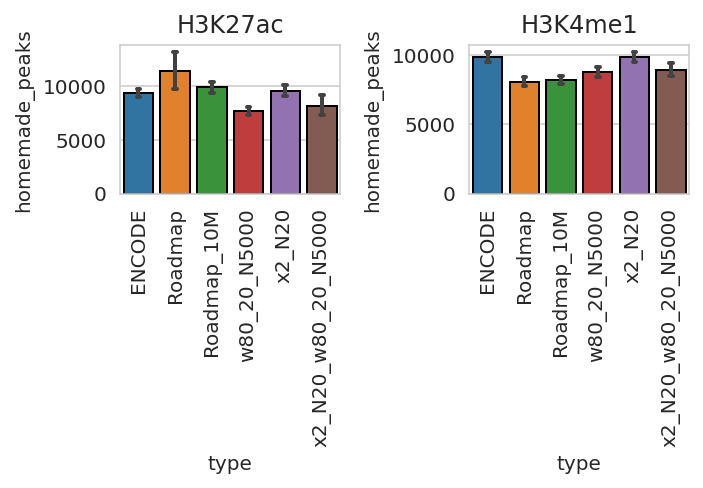

In [870]:
plt.figure(figsize=(5, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
                            x='type', y='homemade_peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
                            )
    ax.title.set_text(m)
    # if i < 1:
    #     ax.legend().set_visible(False)
    # else:
    #     sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


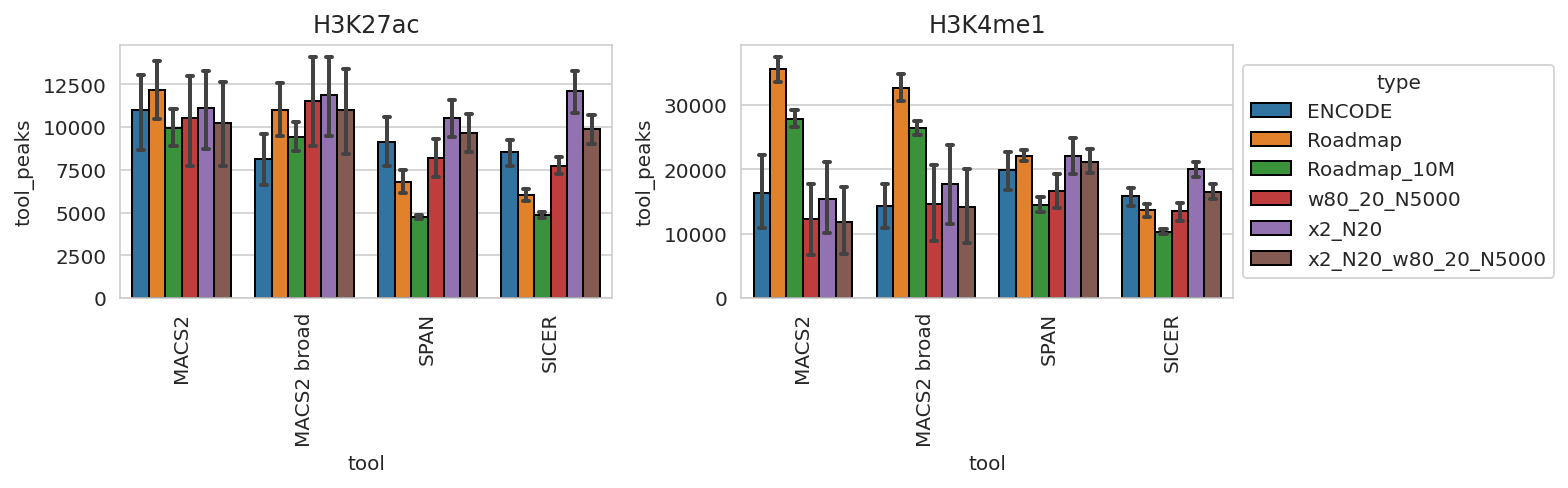

In [871]:
plt.figure(figsize=(11, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
                            x='tool', hue='type', y='tool_peaks', ax=ax,
                            capsize=.05, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            hue_order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


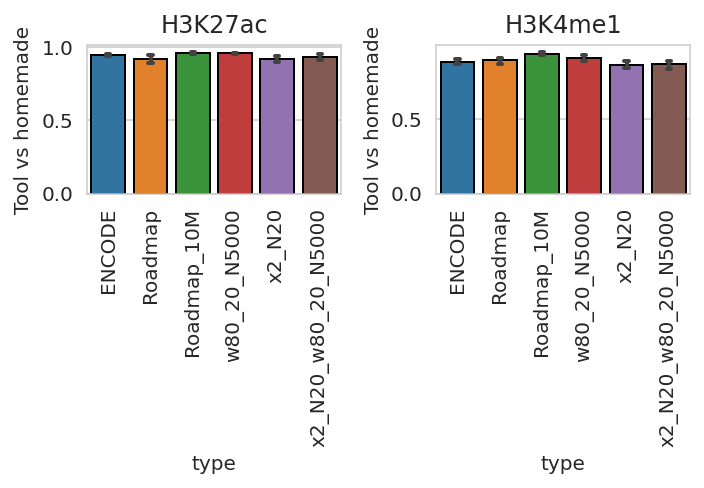

In [872]:
plt.figure(figsize=(5, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
                            x='type', y='overlap1f', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
                            )
    ax.title.set_text(m)
    ax.set_ylabel('Tool vs homemade')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


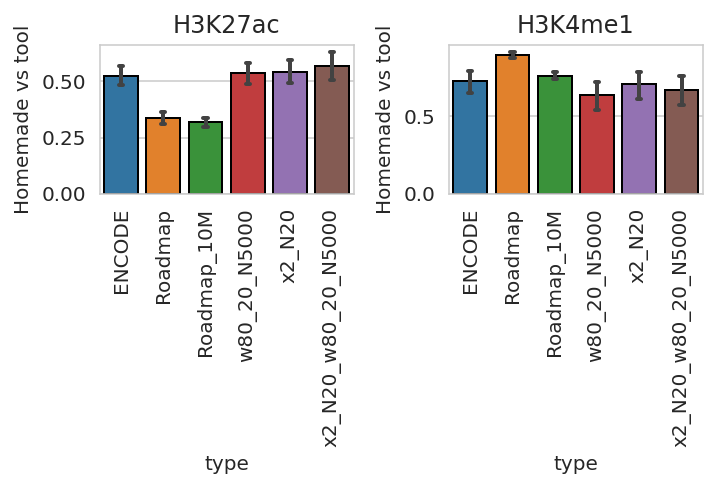

In [873]:
plt.figure(figsize=(5, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
                            x='type', y='overlap2f', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
                            )
    ax.title.set_text(m)
    ax.set_ylabel('Homemade vs tool')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


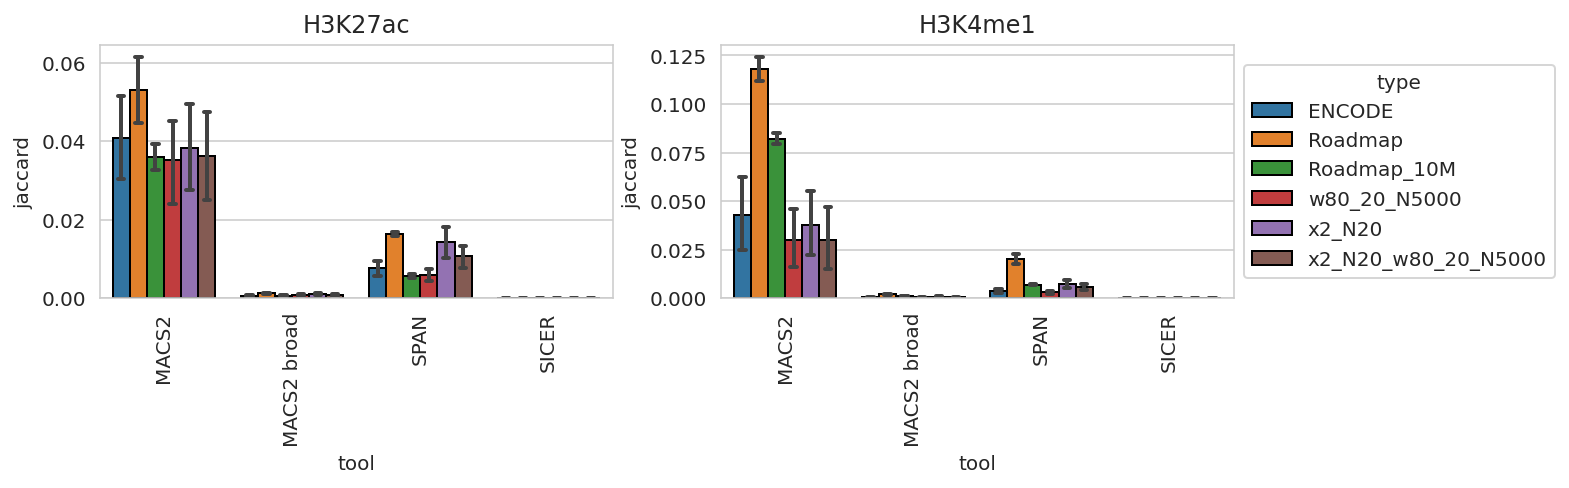

In [874]:
plt.figure(figsize=(11, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=homemade_compare[homemade_compare['modification'] == m],
                            x='tool', hue='type', y='jaccard', ax=ax,
                            capsize=.05, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            hue_order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'w80_20_N5000', 'x2_N20', 'x2_N20_w80_20_N5000'],
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

## Compute roughness

In [875]:
## Compute roughness of coverage withing peaks
LIMITED_TYPES = ['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N20', 'w80_20_N5000', 'x2_N20_w80_20_N5000']

from math import ceil
import pyBigWig

rows = []
bin = 50  # Should be bigger than used for upscaling (N20)!
# 50 is a resolution of bigwig files used in computations

for _, (m, c, r, ty) in tqdm(all_bws[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows()):
    if ty not in LIMITED_TYPES:
        continue
    print(m, c, r, ty)
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['type'] == ty)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    print(bw_path)
    # peaks_path = f'{WD}/union/{m}_{c}_{r}_{ty}.bed'
    peaks_path = f'{WD}/homemade/{m}_{c}_{r}_{ty}.bed'
    print(peaks_path)
    if not os.path.exists(peaks_path):
        print('No peaks file')
        continue
    try:
        t = pd.read_csv(peaks_path, sep='\t', header=None)
        t = t.sample(min(len(t), 1000))
        with pyBigWig.open(bw_path) as bw:
            # Resort top scored peaks by density and start with the most dense ones
            total_coverage = sum(
                bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            print('Total coverage', total_coverage)
            for chr, start, end in zip(t[0], t[1], t[2]):
                if chr in CHROM_SIZES:
                    # Normalize by total coverage
                    stats = [c / total_coverage for c in
                             bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True)]
                    rows.append(
                        (m, c, r, ty, f'{chr}:{start}-{end}', len(stats), np.mean(stats), np.std(stats), np.var(stats)))
    except Exception as e:
        print(e)
        pass  # Ignore

df_roughness = pd.DataFrame(rows,
                            columns=['modification', 'cell', 'replicate', 'type',  'position', 'bins', 'mean', 'std', 'var'])
del rows
df_roughness.sample(5)

0it [00:00, ?it/s]

H3K4me1 HMEC rep1 x2_N20
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_HMEC_rep1_x2_N20.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade/H3K4me1_HMEC_rep1_x2_N20.bed
Total coverage 79.6640191358577
H3K4me1 GM12878 rep1 x2_N20
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_GM12878_rep1_x2_N20.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade/H3K4me1_GM12878_rep1_x2_N20.bed
Total coverage 95.72068983154368
H3K27ac HMEC rep1 w80_20_N5000
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K27ac_HMEC_rep1_w80_20_N5000.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade/H3K27ac_HMEC_rep1_w80_20_N5000.bed
Total coverage 81.91852888283253
H3K4me1 HSMM rep1 x2_N20
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K4me1_HSMM_rep1_x2_N20.bw
/home/jetbrains/data/2023_GSE26320_wiggle_mix/homemade/H3K4me1_HSMM_rep1_x2_N20.bed
Total coverage 80.84010117115521
H3K27ac NHLF rep1 w80_20_N5000
/home/jetbrains/data/2023_GSE26320_wiggle_mix/bw/H3K27ac_NHLF_rep1_

modification     cell replicate                 type  \
6153       H3K4me1  GM12878      rep1         w80_20_N5000   
21404      H3K27ac  GM12878      rep1         w80_20_N5000   
62534      H3K27ac       H1      rep1               ENCODE   
25630      H3K27ac     HSMM      rep1  x2_N20_w80_20_N5000   
3907       H3K4me1     HSMM      rep1               x2_N20   

                       position  bins      mean       std           var  
6153   chr1:165375000-165380000   100  0.000825  0.000989  9.785923e-07  
21404  chr2:215875000-215880000   100  0.000350  0.000688  4.739743e-07  
62534      chr1:3980000-3985000   100  0.000487  0.000866  7.499025e-07  
25630  chr1:229620000-229630000   200  0.000522  0.000806  6.493939e-07  
3907     chr3:53940000-53945000   100  0.000712  0.001282  1.643526e-06

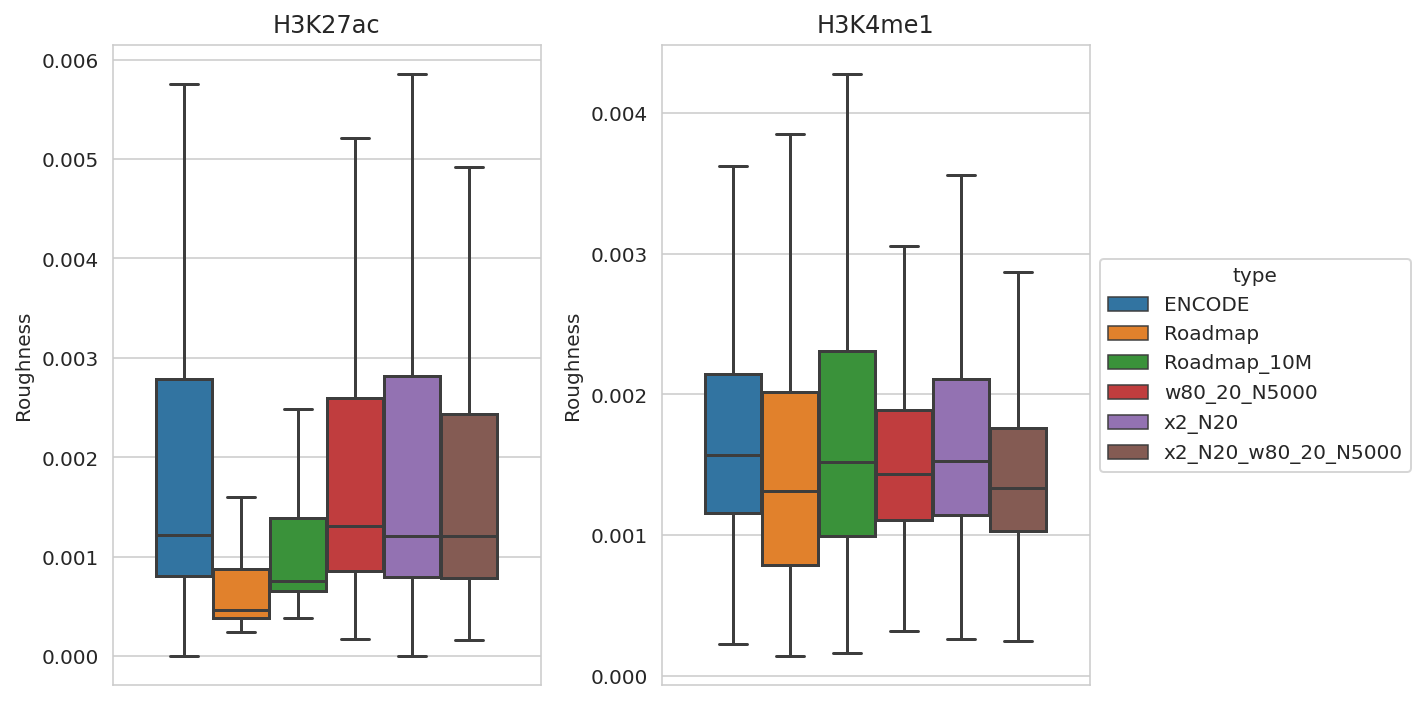

In [876]:
plt.figure(figsize=(10, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df_roughness[df_roughness['modification'] == m].copy()
    if m == 'H3K27ac':
        t = t[~t['cell'].isin(['H1'])]  ## Remove ENCODE having roughness than Roadmap
    if m == 'H3K4me1':
        t = t[~t['cell'].isin(['H1', 'GM12878', 'HSMM', 'NHLF', 'HMEC'])]  ## Remove ENCODE having roughness than Roadmap
    
    g_results = sns.boxplot(data=t,
                            x='modification', y='std', hue='type',
                            hue_order=sorted(df_roughness['type'].unique()),
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [877]:
df_roughness_aggr = df_roughness[
    ['modification', 'cell', 'replicate', 'type', 'var', 'std']
].groupby(['modification', 'cell', 'replicate', 'type']).agg('mean').reset_index()
df_roughness_aggr.sample(3)

modification     cell replicate                 type       var       std
31      H3K27ac     NHEK      rep1         w80_20_N5000  0.000008  0.002222
45      H3K4me1  GM12878      rep1  x2_N20_w80_20_N5000  0.000002  0.001169
30      H3K27ac     NHEK      rep1               ENCODE  0.000012  0.002509

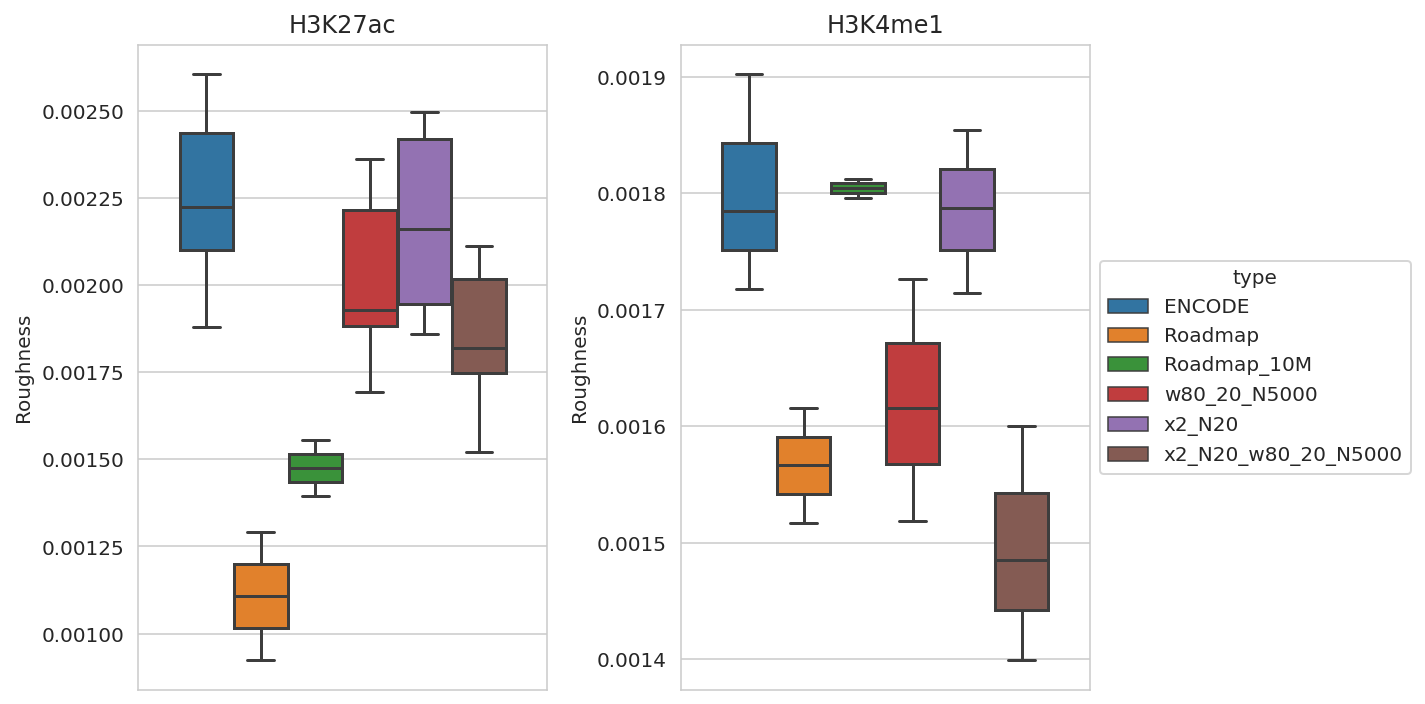

In [883]:
plt.figure(figsize=(10, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df_roughness_aggr[df_roughness_aggr['modification'] == m].copy()
    if m == 'H3K27ac':
        t = t[~t['cell'].isin(['H1'])]  ## Remove ENCODE having roughness than Roadmap
    if m == 'H3K4me1':
        t = t[~t['cell'].isin(['H1', 'GM12878', 'HSMM', 'NHLF', 'HMEC', 'HepG2'])]  ## Remove ENCODE having roughness than Roadmap
    
    g_results = sns.boxplot(data=t,
                            x='modification', y='std', hue='type',
                            hue_order=sorted(df_roughness_aggr['type'].unique()),
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [884]:
t = df_wiggle_bams.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
# t['scale'] = t['upscale']

t2 = df_bams[df_bams['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t2['type'] = t2['dataset']
t2['scale'] = [0.5 if ds == 'ENCODE' else 2.5 for ds in t2['dataset']]
t2['wiggle'] = 0.0

t3 = df_immune_10m_bams.copy()
t3['type'] = 'Roadmap_10M'
t3['scale'] = 2.2
t3['wiggle'] = 0.0

all_bams_df = pd.concat([t, t2, t3]).reset_index(drop=True)
all_bams_df

bam_file modification     cell  \
0   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    Huvec   
1   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1    HepG2   
2   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1     HMEC   
3   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1       H1   
4   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  GM12878   
..                                                ...          ...      ...   
91  /home/jetbrains/data/2023_Immune/bams/TCell_H3...      H3K27ac    TCell   
92  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1    BCell   
93  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K4me1    TCell   
94  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac    TCell   
95  /home/jetbrains/data/2023_Immune_mln_control/b...      H3K27ac    BCell   

   replicate     reads                 type  upscale  wiggle  dataset  scale  
0       rep1  20920470               x2_N20      2.0     0.0      NaN    NaN  
1       rep1  27414798               x2_N20      2.0     0.0      NaN    NaN  
2       rep1  32703832               x2_N20      2.0     0.0      NaN    NaN  
3       rep1   8443444         w80_20_N5000      1.0  5000.0      NaN    NaN  
4       rep1  22016315  x2_N20_w80_20_N5000      2.0  5000.0      NaN    NaN  
..       ...       ...                  ...      ...     ...      ...    ...  
91            30425955              Roadmap      NaN     0.0  Roadmap    2.5  
92             9998693          Roadmap_10M      NaN     0.0      NaN    2.2  
93             9998681          Roadmap_10M      NaN     0.0      NaN    2.2  
94            10002191          Roadmap_10M      NaN     0.0      NaN    2.2  
95             9999314          Roadmap_10M      NaN     0.0      NaN    2.2  

[96 rows x 10 columns]

In [892]:
# Additional annotation

reads = []
peaks = {tool: [] for tool in TOOLS}
for _, (m, c, r, ty) in df_roughness_aggr[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows():
    t = all_bams_df[(all_bams_df['modification'] == m) & 
                    (all_bams_df['cell'] == c) & 
                    (all_bams_df['replicate'] == r) & 
                    (all_bams_df['type'] == ty)]
    if len(t) == 0:
        reads.append(None)
    else:
        reads.append(t['reads'].values[0])
    for tool in TOOLS:
        t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['modification'] == m) &
                                          (wiggle_mix_original_all_peaks['cell'] == c) &
                                          (wiggle_mix_original_all_peaks['replicate'] == r) &
                                          (wiggle_mix_original_all_peaks['type'] == ty) &
                                          (wiggle_mix_original_all_peaks['tool'] == tool)]
        if len(t) == 0:
            peaks[tool].append(None)
        else:
            peaks[tool].append(t['peaks'].values[0])
        

df_roughness_aggr['reads'] = reads
for tool in TOOLS:
    df_roughness_aggr[tool] = peaks[tool]

df_roughness_aggr.sample(5)

modification   cell replicate                 type       var       std  \
58      H3K4me1  HepG2      rep1               ENCODE  0.000003  0.001555   
73      H3K4me1   NHEK      rep1  x2_N20_w80_20_N5000  0.000002  0.001485   
14      H3K27ac   HSMM      rep1               ENCODE  0.000009  0.002112   
67      H3K4me1   K562      rep1         w80_20_N5000  0.000003  0.001726   
30      H3K27ac   NHEK      rep1               ENCODE  0.000012  0.002509   

       reads  peaks  MACS2  MACS2 broad    SPAN  SICER  
58  13707399  87117  87117        67313   88821  69630  
73  17635031  94766  94766       104302  109370  75575  
14  11291330  57283  57283        44198   38858  36868  
67   9537694  96498  96498       106873   56151  45424  
30   9377615  63415  63415        44938   48853  40030

In [893]:
display(df_roughness_aggr[df_roughness_aggr['type'] == 'ENCODE'])
display(df_roughness_aggr[df_roughness_aggr['type'] == 'Roadmap'])

modification     cell replicate    type       var       std     reads  \
2       H3K27ac  GM12878      rep1  ENCODE  0.000008  0.002069   7049058   
6       H3K27ac       H1      rep1  ENCODE  0.000002  0.001000  13632742   
10      H3K27ac     HMEC      rep1  ENCODE  0.000010  0.002225  10940745   
14      H3K27ac     HSMM      rep1  ENCODE  0.000009  0.002112  11291330   
18      H3K27ac    HepG2      rep1  ENCODE  0.000016  0.002605   7474026   
22      H3K27ac    Huvec      rep1  ENCODE  0.000015  0.002412  12283487   
26      H3K27ac     K562      rep1  ENCODE  0.000012  0.002223  11704712   
30      H3K27ac     NHEK      rep1  ENCODE  0.000012  0.002509   9377615   
34      H3K27ac     NHLF      rep1  ENCODE  0.000005  0.001879   7915513   
42      H3K4me1  GM12878      rep1  ENCODE  0.000002  0.001394  11008158   
46      H3K4me1       H1      rep1  ENCODE  0.000002  0.001239   8443445   
50      H3K4me1     HMEC      rep1  ENCODE  0.000002  0.001345  16351916   
54      H3K4me1     HSMM      rep1  ENCODE  0.000002  0.001479   8080332   
58      H3K4me1    HepG2      rep1  ENCODE  0.000003  0.001555  13707399   
62      H3K4me1    Huvec      rep1  ENCODE  0.000004  0.001718  10460235   
66      H3K4me1     K562      rep1  ENCODE  0.000004  0.001902   9537695   
70      H3K4me1     NHEK      rep1  ENCODE  0.000004  0.001784   8817516   
74      H3K4me1     NHLF      rep1  ENCODE  0.000005  0.002148   4554228   

     peaks   MACS2  MACS2 broad    SPAN  SICER  
2    47290   47290        31476   34842  32861  
6    17497   17497        15680   27529  33696  
10   40609   40609        29088   47858  36689  
14   57283   57283        44198   38858  36868  
18   48652   48652        32654   25534  28360  
22   50367   50367        37737   42257  38747  
26   53699   53699        39486   26221  26929  
30   63415   63415        44938   48853  40030  
34   29697   29697        24128   40791  38037  
42   46817   46817        42927   85381  70985  
46   29669   29669        54953   42833  51468  
50   10256   10256        15699   98083  69082  
54   58144   58144        66078   68255  58438  
58   87117   87117        67313   88821  69630  
62   87943   87943        60955   75212  51605  
66  119713  119713        86449   71577  55839  
70  110303  110303        84110  107773  72654  
74   35453   35453        38075   72457  66313

modification   cell replicate     type       var       std     reads  \
0       H3K27ac  BCell            Roadmap  0.000006  0.001291  21067933   
38      H3K27ac  TCell            Roadmap  0.000003  0.000923  30425955   
40      H3K4me1  BCell            Roadmap  0.000003  0.001517  28811580   
78      H3K4me1  TCell            Roadmap  0.000004  0.001616  22687458   

     peaks   MACS2  MACS2 broad   SPAN  SICER  
0    45626   45626        41460  26454  24342  
38   57350   57350        51740  31192  26338  
40  141414  141414       127965  89375  62076  
78  158205  158205       145437  94649  53056

In [1008]:
df_roughness_aggr['v'] = [std * math.sqrt(reads / 1e6) for std, reads in zip(df_roughness_aggr['std'], df_roughness_aggr['reads'])] 

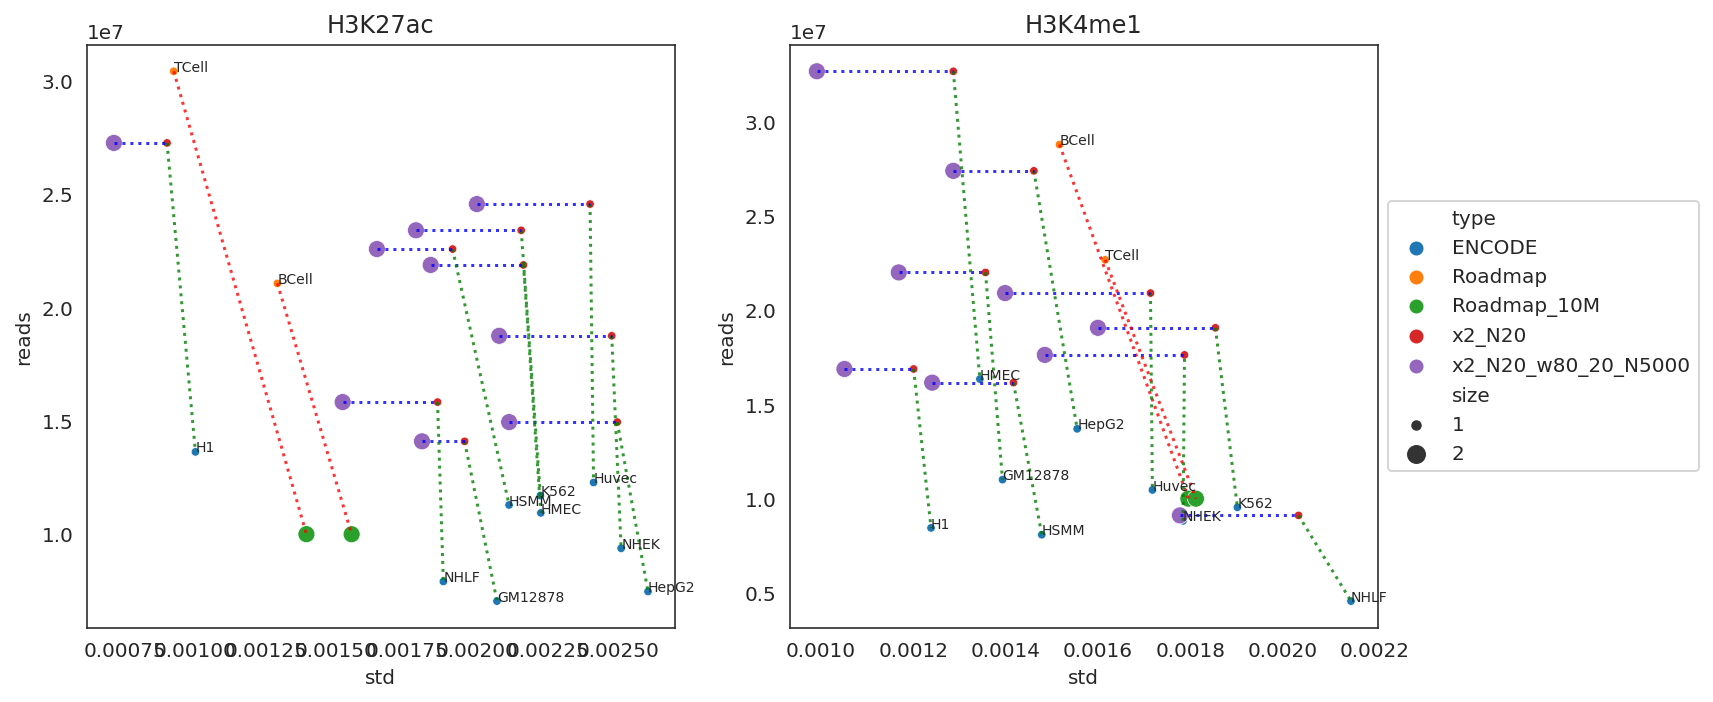

In [1014]:
X = 'std'
Y = 'reads'

sns.set_style("white")
plt.figure(figsize=(12, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df_roughness_aggr[(df_roughness_aggr['modification'] == m) & (df_roughness_aggr['type'] != 'w80_20_N5000')].copy()
    # if :
    #     t = t[~t['cell'].isin(['H1'])]  ## Remove ENCODE having roughness than Roadmap
    # if m == 'H3K4me1':
    #     t = t[~t['cell'].isin(['H1', 'GM12878', 'HSMM', 'NHLF', 'HMEC'])]  ## Remove ENCODE having roughness than Roadmap
    # t['size'] = [5 if ty == 'ENCODE' or ty == 'Roadmap' or ty == 'Roadmap_10M' else 1 for ty in t['type']]
    t['size'] = [2 if ty == 'x2_N20_w80_20_N5000' or ty == 'Roadmap_10M' else 1 for ty in t['type']]
    # t['size'] = [5 if  ty == 'ENCODE' and (m == 'H3K27ac' and c in ['H1'] or m == 'H3K4me1' and c in ['H1', 'GM12878', 'HSMM', 'HMEC', 'HepG2'])
    #              else 1 for c, ty in zip(t['cell'], t['type'])]
    
    scales = ['', 'x2_N20']
    wiggles = ['', 'w80_20_N5000']
    # scales = ['', 'x1.5_N100', 'x2_N100']
    # wiggles = ['', 'w80_20_N2000', 'w80_20_N5000']
    for c in t['cell'].unique():
        for (sc, wg) in product(scales, wiggles):
            if sc == '' and wg == '':
                continue
            if sc == '':
                s = 'ENCODE'
                e = wg
                color = 'blue'
            elif wg == '':
                s = 'ENCODE'
                e = sc
                color = 'green'
            else:
                s = sc
                e = f'{sc}_{wg}'
                color = 'blue'
            p1 = t[(t['cell'] == c) & (t['type'] == s)]
            p2 = t[(t['cell'] == c) & (t['type'] == e)]
            if len(p1) == 0 or len(p2) == 0:
                continue
            p1x = p1[X].values[0]
            p1y = p1[Y].values[0]
            p2x = p2[X].values[0]
            p2y = p2[Y].values[0]
            sns.lineplot(x=[p1x, p2x], y=[p1y, p2y], color=color, ax=ax, alpha=0.8, linestyle='dotted')
        p1 = t[(t['cell'] == c) & (t['type'] == 'Roadmap')]
        p2 = t[(t['cell'] == c) & (t['type'] == 'Roadmap_10M')]
        if len(p1) == 0 or len(p2) == 0:
            continue
        p1x = p1[X].values[0]
        p1y = p1[Y].values[0]
        p2x = p2[X].values[0]
        p2y = p2[Y].values[0]
        sns.lineplot(x=[p1x, p2x], y=[p1y, p2y], color='red', ax=ax, alpha=0.8, linestyle='dotted')
        
    sns.scatterplot(data=t,
                    x=X, y=Y, hue='type', ax=ax, size='size',
                    hue_order=sorted(filter(lambda ty: ty!='w80_20_N5000', df_roughness_aggr['type'].unique())))
    for x, y, cell, ty in zip(t[X], t[Y], t['cell'], t['type']):
        if ty == 'Roadmap' or ty == 'ENCODE':
            ax.text(x, y, cell, fontsize = 7)


    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()
sns.set_style("whitegrid")

In [1016]:
rows = []
for _, row in tqdm(df_roughness_aggr.iterrows()):
    m, c, r, ty = row['modification'], row['cell'], row['replicate'], row['type'] 
    if ty == 'ENCODE' or ty == 'Roadmap':
        rows.append([m, c, r, ty, 0, 0, 0, 0, 0, 0, 0, row['std']])
        continue
    offset = 'Roadmap' if ty == 'Roadmap_10M' else 'ENCODE'
    t = df_roughness_aggr[(df_roughness_aggr['modification'] == m) &
                          (df_roughness_aggr['cell'] == c) &
                          (df_roughness_aggr['replicate'] == r) &
                          (df_roughness_aggr['type'] == offset)]
    if len(t) == 0:
        continue
    rows.append([m, c, r, ty] + [row[col] - t[col].values[0] for col in ['std', 'var', 'reads'] + TOOLS] + [t['std'].values[0]])
df_roughness_aggr_z = pd.DataFrame(rows, 
                                   columns=['modification', 'cell', 'replicate', 'type', 'std', 'var', 'reads'] + TOOLS + ['roughness'])
df_roughness_aggr_z.sample(5)

0it [00:00, ?it/s]

modification  cell replicate                 type       std           var  \
9       H3K27ac    H1      rep1  x2_N20_w80_20_N5000 -0.000289 -8.765926e-07   
51      H3K4me1  HMEC      rep1         w80_20_N5000 -0.000162 -5.412048e-07   
30      H3K27ac  NHEK      rep1               ENCODE  0.000000  0.000000e+00   
77      H3K4me1  NHLF      rep1  x2_N20_w80_20_N5000 -0.000371 -1.663661e-06   
17      H3K27ac  HSMM      rep1  x2_N20_w80_20_N5000 -0.000469 -4.372484e-06   

       reads  MACS2  MACS2 broad   SPAN  SICER  roughness  
9   13632741  -5653        -3006   7137  10129   0.001000  
51        -1  -6787       -10799 -13276 -10520   0.001345  
30         0      0            0      0      0   0.002509  
77   4554227 -21225       -10172  -1983  -3561   0.002148  
17  11291329  -4948        12302   7162   8519   0.002112

In [1017]:
df_roughness_aggr_z[df_roughness_aggr_z['type'] == 'Roadmap']

modification   cell replicate     type  std  var  reads  MACS2  \
0       H3K27ac  BCell            Roadmap  0.0  0.0      0      0   
38      H3K27ac  TCell            Roadmap  0.0  0.0      0      0   
40      H3K4me1  BCell            Roadmap  0.0  0.0      0      0   
78      H3K4me1  TCell            Roadmap  0.0  0.0      0      0   

    MACS2 broad  SPAN  SICER  roughness  
0             0     0      0   0.001291  
38            0     0      0   0.000923  
40            0     0      0   0.001517  
78            0     0      0   0.001616

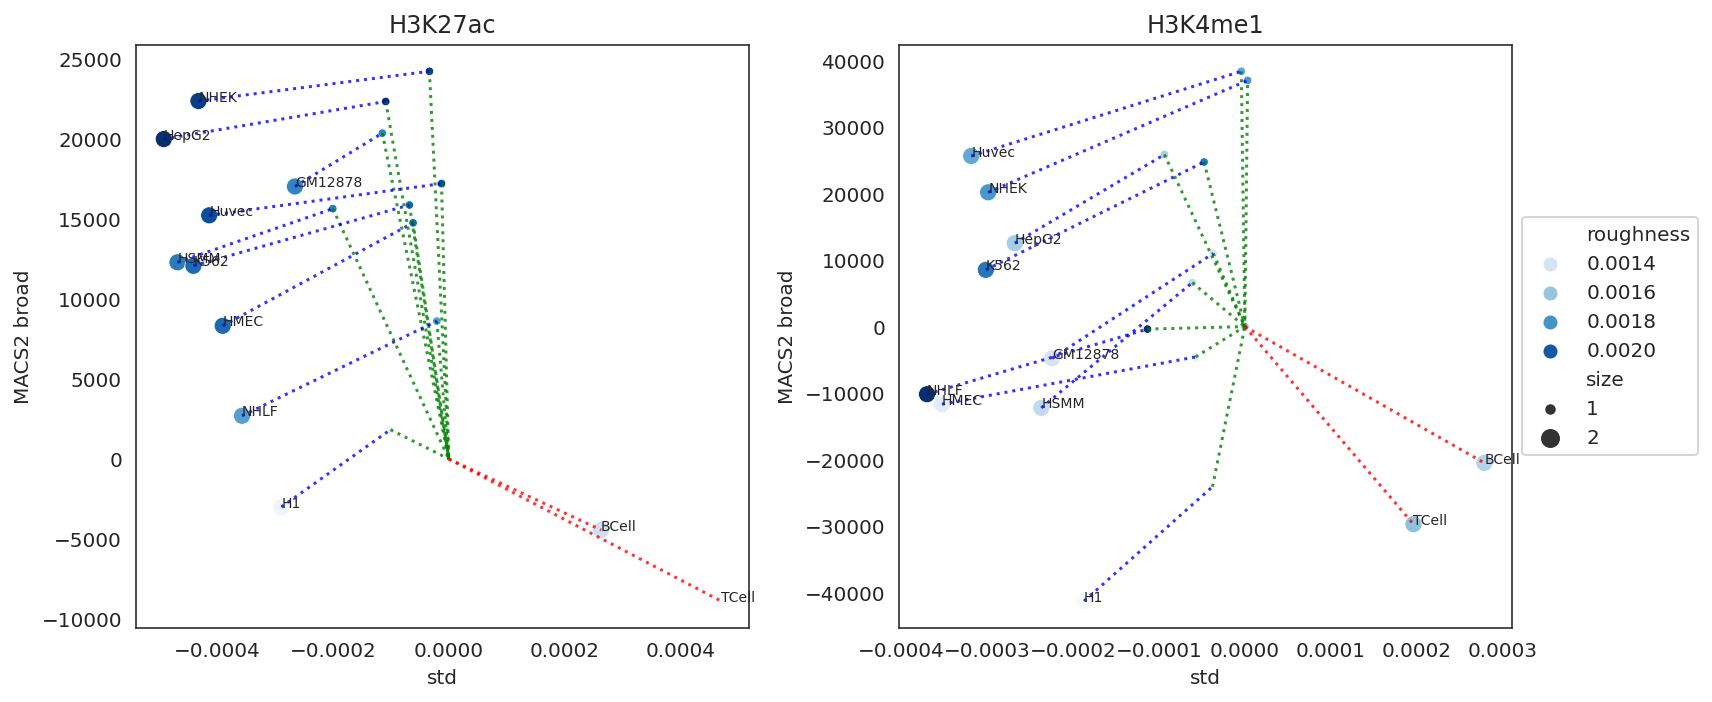

In [1039]:
X = 'std'
Y = 'MACS2 broad'

sns.set_style("white")
plt.figure(figsize=(12, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df_roughness_aggr_z[(df_roughness_aggr_z['modification'] == m) & (df_roughness_aggr_z['type'] != 'w80_20_N5000')].copy()
    t['size'] = [2 if ty in ['x2_N20_w80_20_N5000', 'Roadmap_10M']  else 1 for ty in t['type']]
    # t['size'] = [2 if ty == 'ENCODE' or ty == 'Roadmap' or ty == 'Roadmap_10M' else 1 for ty in t['type']]

    scales = ['', 'x2_N20']
    wiggles = ['', 'w80_20_N5000']
    for c in t['cell'].unique():
        for (sc, wg) in product(scales, wiggles):
            if sc == '' and wg == '':
                continue
            if sc == '':
                s = 'ENCODE'
                e = wg
                color = 'blue'
            elif wg == '':
                s = 'ENCODE'
                e = sc
                color = 'green'
            else:
                s = sc
                e = f'{sc}_{wg}'
                color = 'blue'
            p1 = t[(t['cell'] == c) & (t['type'] == s)]
            p2 = t[(t['cell'] == c) & (t['type'] == e)]
            if len(p1) == 0 or len(p2) == 0:
                continue
            p1x = p1[X].values[0]
            p1y = p1[Y].values[0]
            p2x = p2[X].values[0]
            p2y = p2[Y].values[0]
            sns.lineplot(x=[p1x, p2x], y=[p1y, p2y], color=color, ax=ax, alpha=0.8, linestyle='dotted')
        p1 = t[(t['cell'] == c) & (t['type'] == 'Roadmap')]
        p2 = t[(t['cell'] == c) & (t['type'] == 'Roadmap_10M')]
        if len(p1) == 0 or len(p2) == 0:
            continue
        p1x = p1[X].values[0]
        p1y = p1[Y].values[0]
        p2x = p2[X].values[0]
        p2y = p2[Y].values[0]
        sns.lineplot(x=[p1x, p2x], y=[p1y, p2y], color='red', ax=ax, alpha=0.8, linestyle='dotted')

    sns.scatterplot(data=t,
                    x=X, y=Y, 
                    hue='roughness', palette='Blues',
                    # hue='type',
                    # hue_order=sorted(filter(lambda ty: ty != 'x2_N20', df_roughness_aggr['type'].unique())),
                    ax=ax, size='size',
                    )
    for x, y, cell, ty in zip(t[X], t[Y], t['cell'], t['type']):
        if (ty == 'x2_N20_w80_20_N5000' or ty == 'Roadmap_10M') and (math.fabs(x) > 1e-3 or math.fabs(y) > 1e-3):
            ax.text(x, y, cell, fontsize = 7)


    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()
sns.set_style("whitegrid")

H3K27ac MACS2
H3K27ac MACS2 broad
H3K27ac SPAN
H3K27ac SICER
H3K4me1 MACS2
H3K4me1 MACS2 broad
H3K4me1 SPAN
H3K4me1 SICER


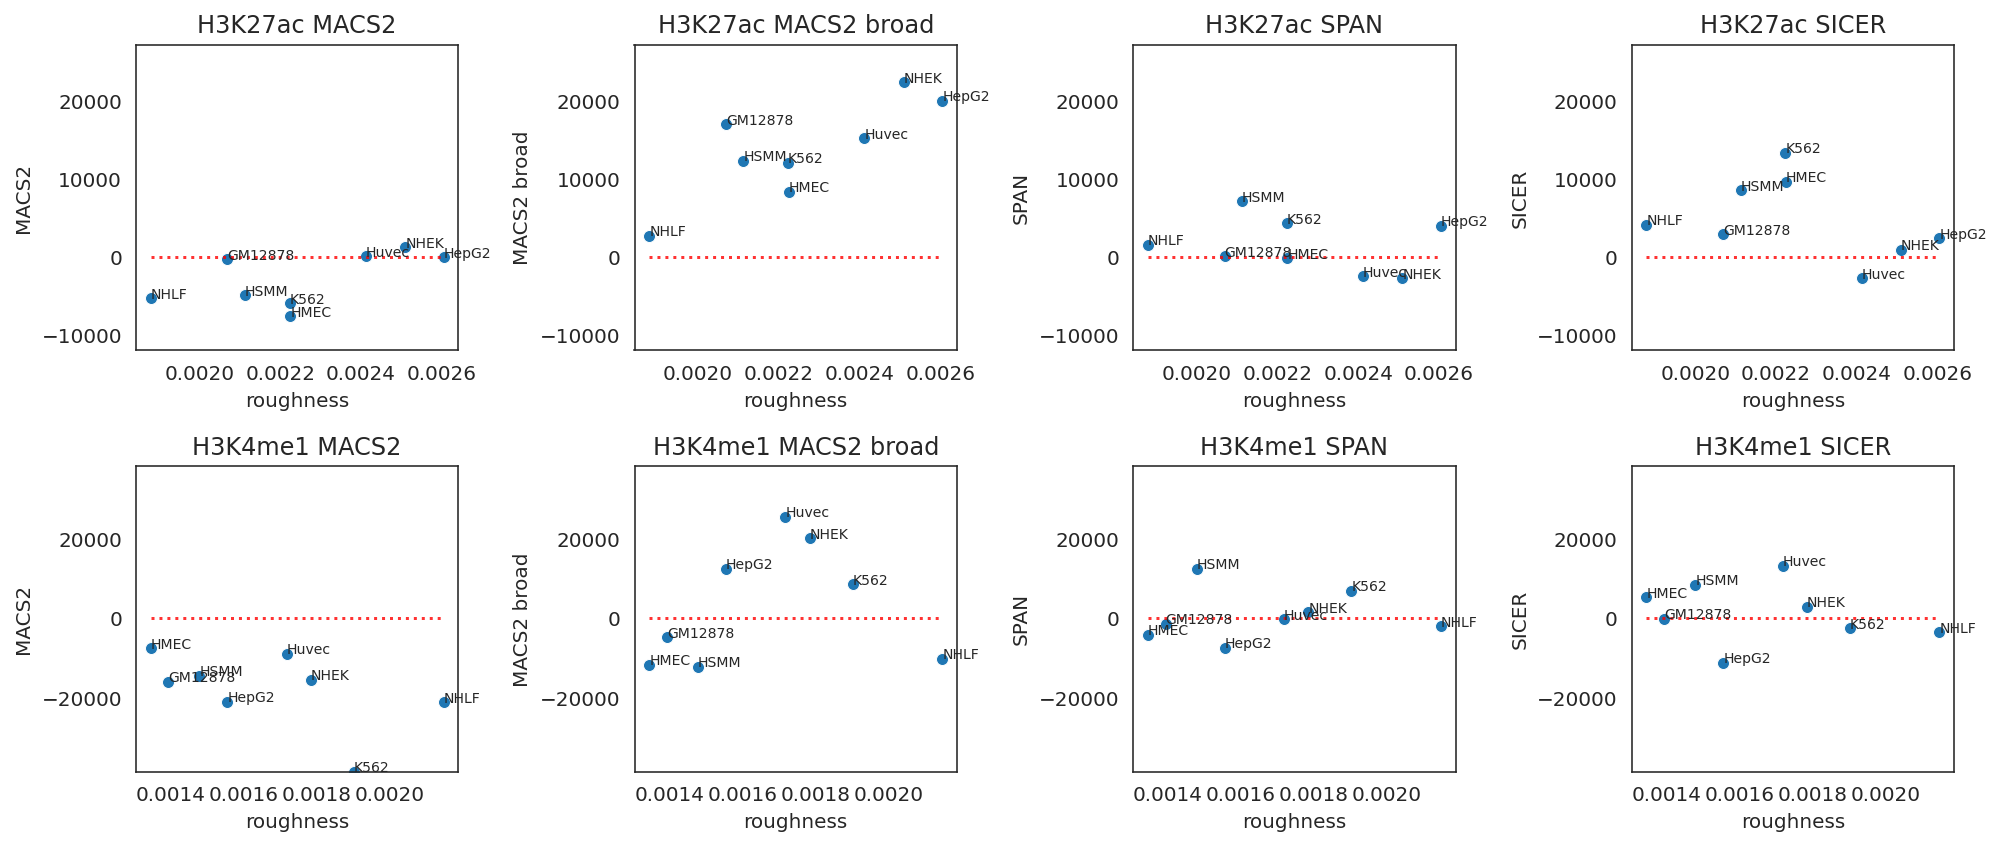

In [1053]:
sns.set_style("white")
plt.figure(figsize=(14, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
for i, (m, tool) in enumerate(product(['H3K27ac', 'H3K4me1'], TOOLS)):
    print(m, tool)
    ax = axs[i]
    t = df_roughness_aggr_z[(df_roughness_aggr_z['modification'] == m) &
                            (df_roughness_aggr_z['cell'] != 'H1') &
                            (df_roughness_aggr_z['type'] == 'x2_N20_w80_20_N5000')].copy()
    t2 = df_roughness_aggr_z[(df_roughness_aggr_z['modification'] == m) &
                             (df_roughness_aggr_z['cell'] != 'H1')]
    sns.scatterplot(data=t,
                    x='roughness', y=tool,
                    ax=ax)
    for x, y, cell in zip(t['roughness'], t[tool], t['cell']):
        ax.text(x, y, cell, fontsize = 7)

    sns.lineplot(x=[t['roughness'].min(), t['roughness'].max()], y=[0, 0], color='red', ax=ax, alpha=0.8, linestyle='dotted')
        

    ax.title.set_text(f'{m} {tool}')
    # if i == 1:
    #     sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # else:
    #     ax.legend().set_visible(False)
    ax.set_ylim(min(0, np.min(t2[TOOLS].min())), max(0, np.max(t2[TOOLS].max())))

plt.tight_layout()
plt.show()
sns.set_style("whitegrid")

# OLD CODE

In [ ]:
df_peaks['name'] = df_peaks['tool']
df_peaks['type'] = 'original'

In [45]:
wiggle_mix_peaks['name'] = wiggle_mix_peaks['tool']
wiggle_mix_peaks['type'] = 'base'

mix_rows = ['mix' in os.path.basename(f) for f in wiggle_mix_peaks['file']]
wiggle_rows = ['wiggle' in os.path.basename(f) for f in wiggle_mix_peaks['file']]
wiggle_mix_peaks.loc[mix_rows, 'name'] = wiggle_mix_peaks[mix_rows]['name'] + ' mix'
wiggle_mix_peaks.loc[mix_rows, 'type'] = 'mix'
wiggle_mix_peaks.loc[wiggle_rows, 'name'] = wiggle_mix_peaks[wiggle_rows]['name'] + ' wiggle'
wiggle_mix_peaks.loc[wiggle_rows, 'type'] = 'wiggle'

wiggle_mix_peaks.sample(3)

  0%|          | 0/253 [00:00<?, ?it/s]

MACS2 32


  0%|          | 0/253 [00:00<?, ?it/s]

MACS2 broad 32


  0%|          | 0/36 [00:00<?, ?it/s]

SICER 32


  0%|          | 0/37 [00:00<?, ?it/s]

SPAN 32


file modification   cell  \
0    /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HMEC   
83   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   HSMM   
114  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  Huvec   

    replicate  peaks   tool          name    type  
0        rep1   3416  MACS2     MACS2 mix     mix  
83       rep1  64875  SICER  SICER wiggle  wiggle  
114      rep1  81721   SPAN   SPAN wiggle  wiggle

In [51]:
all_wiggle_mix_peaks = pd.concat([df_peaks[(df_peaks['dataset'] != 'Roadmap') &
                                           (df_peaks['replicate'] != 'rep2') &
                                           df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])], 
                                  wiggle_mix_peaks]).reset_index(drop=True)
all_wiggle_mix_peaks.sample(3)

file modification  cell  \
49   /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K4me1    H1   
151  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  NHLF   
177  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1  HSMM   

    replicate  peaks   tool dataset          name      type  
49       rep1  51468  SICER  ENCODE         SICER  original  
151      rep1  41100  SICER     NaN  SICER wiggle    wiggle  
177      rep1  96790   SPAN     NaN   SPAN wiggle    wiggle

In [52]:
# # Remove outliers
# display(all_wiggle_mix_peaks[(all_wiggle_mix_peaks['type'] == 'wiggle') &
#                              ((all_wiggle_mix_peaks['peaks'] < 20_000) | (all_wiggle_mix_peaks['peaks'] > 100_000))])
# all_wiggle_mix_peaks = all_wiggle_mix_peaks[
#                                             (all_wiggle_mix_peaks['peaks'] >= 20_000) & 
#                                             (all_wiggle_mix_peaks['peaks'] <= 100_000)].copy()

H3K27ac
H3K4me1


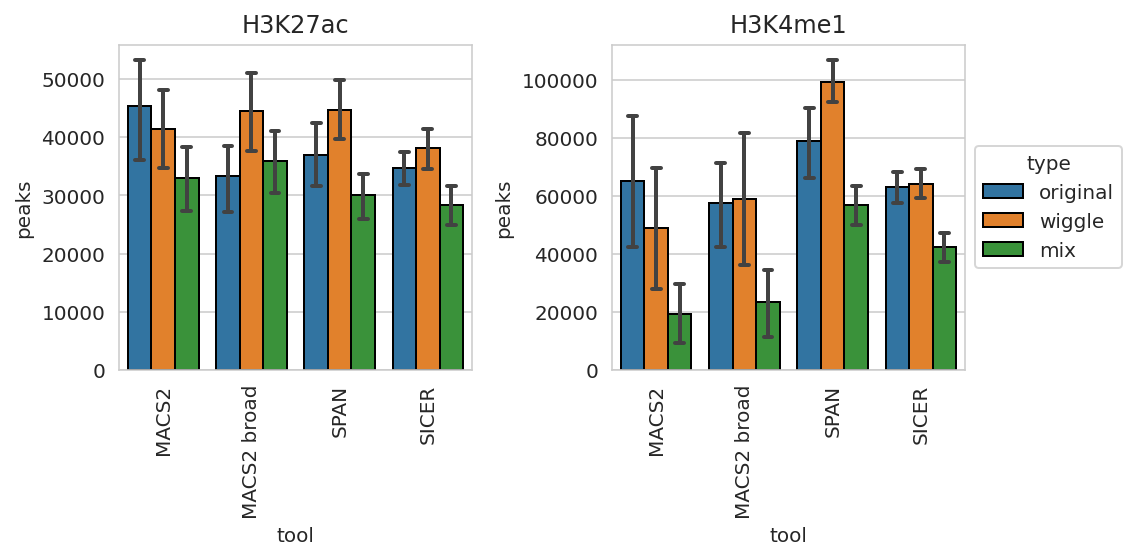

In [53]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]


for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[all_wiggle_mix_peaks['modification'] == m],
                            x='tool', hue='type', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            hue_order=['original', 'wiggle', 'mix']
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


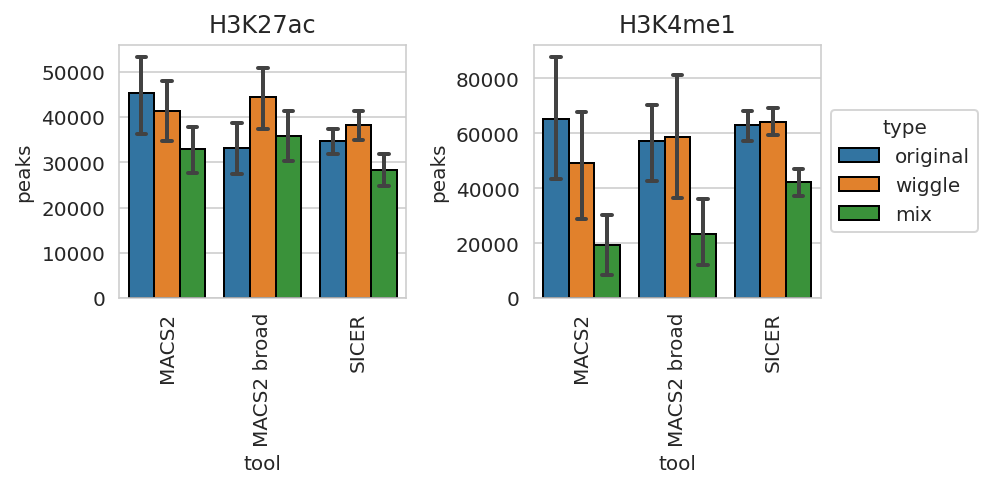

In [54]:
plt.figure(figsize=(7, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]


for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[all_wiggle_mix_peaks['modification'] == m],
                            x='tool', hue='type', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['original', 'wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

wiggle
H3K27ac
H3K4me1


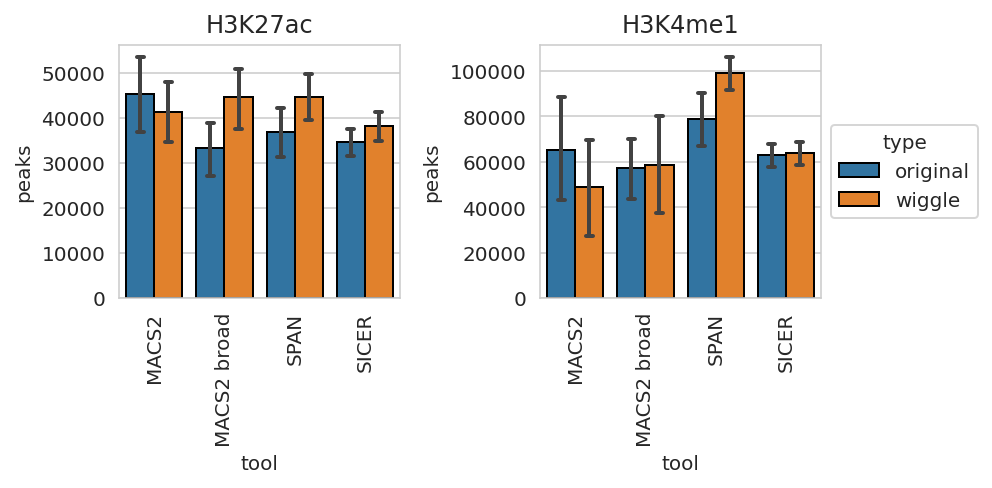

mix
H3K27ac
H3K4me1


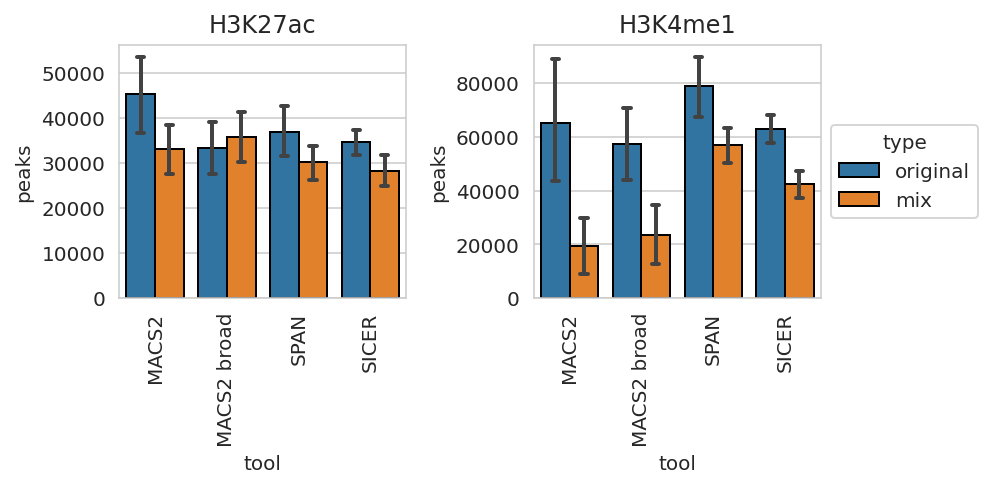

In [55]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(7, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & 
                                                          (all_wiggle_mix_peaks['type'].isin(['original', ty]))],
                                x='tool', hue='type', y='peaks', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                hue_order=['original', ty],
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                # order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

wiggle
H3K27ac
H3K4me1


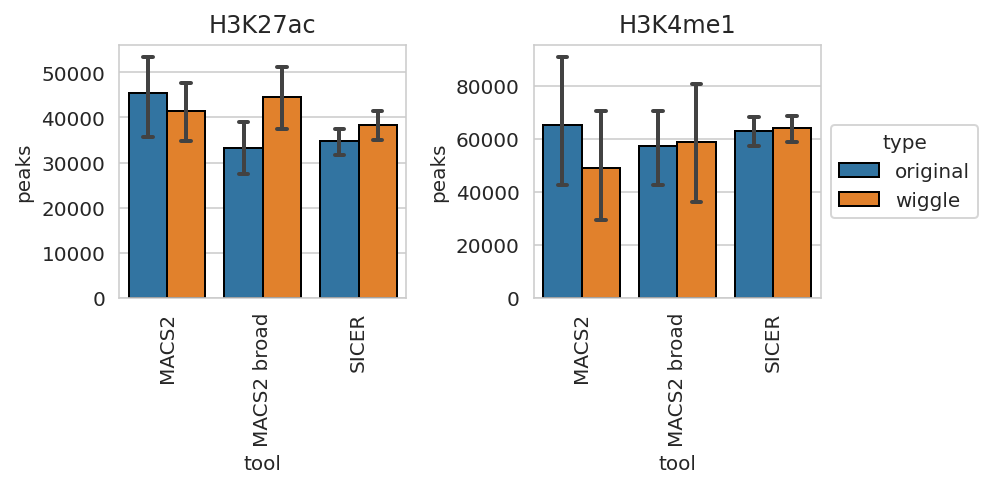

mix
H3K27ac
H3K4me1


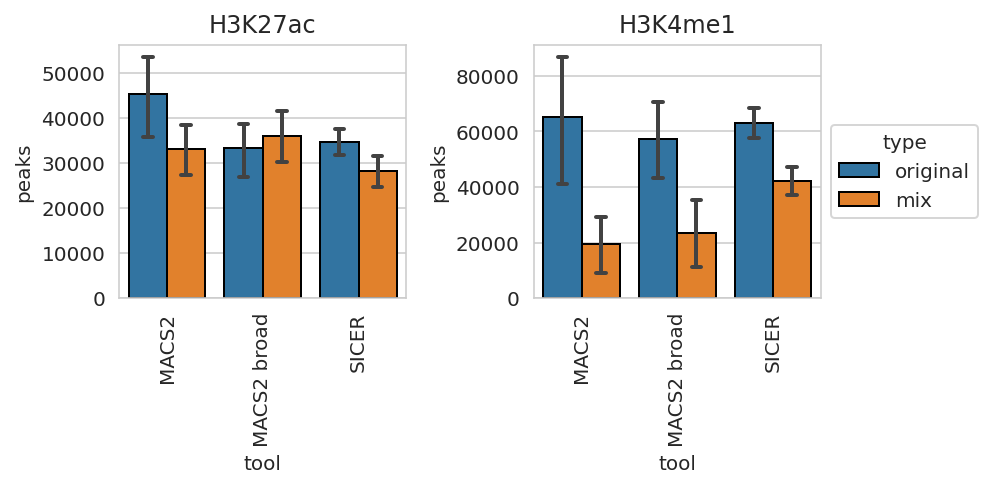

In [56]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(7, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & 
                                                          (all_wiggle_mix_peaks['type'].isin(['original', ty]))],
                                x='tool', hue='type', y='peaks', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                hue_order=['original', ty],
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

In [57]:
all_wiggle_mix_peaks_fc = pd.DataFrame(columns=['modification', 'cell', 'replicate', 'tool',
                                             'peaks_original', 'type', 'peaks', 'fold-change'])
t = all_wiggle_mix_peaks[all_wiggle_mix_peaks['dataset'] == 'ENCODE']
for m, c, r, to, p in tqdm(zip(t['modification'], t['cell'], t['replicate'], t['tool'], t['peaks'])):
    print(m, c, r, to, p)
    for ty in ['wiggle', 'mix']:
        tty = all_wiggle_mix_peaks[(all_wiggle_mix_peaks['type'] == ty) &
                            (all_wiggle_mix_peaks['modification'] == m) &
                            (all_wiggle_mix_peaks['cell'] == c) &
                            (all_wiggle_mix_peaks['replicate'] == r) &
                            (all_wiggle_mix_peaks['tool'] == to)]
        if len(tty) == 0:
            continue
        pty = tty['peaks'].values[0]
        all_wiggle_mix_peaks_fc.loc[len(all_wiggle_mix_peaks_fc)] = (m, c, r, to, p, ty, pty, d(pty, p))
all_wiggle_mix_peaks_fc.sample(3)

0it [00:00, ?it/s]

H3K27ac H1 rep1 MACS2 17497
H3K27ac HepG2 rep1 MACS2 48652
H3K4me1 HMEC rep1 MACS2 10256
H3K27ac K562 rep1 MACS2 53699
H3K4me1 HSMM rep1 MACS2 58144
H3K4me1 NHEK rep1 MACS2 110303
H3K4me1 NHLF rep1 MACS2 35453
H3K4me1 GM12878 rep1 MACS2 46817
H3K27ac Huvec rep1 MACS2 50367
H3K27ac HSMM rep1 MACS2 57283
H3K4me1 H1 rep1 MACS2 29669
H3K27ac GM12878 rep1 MACS2 47290
H3K27ac HMEC rep1 MACS2 40609
H3K4me1 Huvec rep1 MACS2 87943
H3K4me1 K562 rep1 MACS2 119713
H3K27ac NHLF rep1 MACS2 29697
H3K4me1 HepG2 rep1 MACS2 87117
H3K27ac NHEK rep1 MACS2 63415
H3K4me1 Huvec rep1 MACS2 broad 60955
H3K27ac HSMM rep1 MACS2 broad 44198
H3K27ac NHEK rep1 MACS2 broad 44938
H3K4me1 NHEK rep1 MACS2 broad 84110
H3K27ac K562 rep1 MACS2 broad 39486
H3K27ac Huvec rep1 MACS2 broad 37737
H3K4me1 GM12878 rep1 MACS2 broad 42927
H3K27ac H1 rep1 MACS2 broad 15680
H3K4me1 K562 rep1 MACS2 broad 86449
H3K27ac HMEC rep1 MACS2 broad 29088
H3K4me1 HMEC rep1 MACS2 broad 15699
H3K4me1 HSMM rep1 MACS2 broad 66078
H3K4me1 NHLF rep1

modification  cell replicate   tool  peaks_original    type   peaks  \
124      H3K4me1  HSMM      rep1   SPAN           68255  wiggle   96790   
114      H3K4me1  HMEC      rep1   SPAN           98083  wiggle  105382   
88       H3K4me1  NHLF      rep1  SICER           66313  wiggle   60259   

     fold-change  
124     1.418065  
114     1.074417  
88      0.908706

wiggle
H3K27ac
H3K4me1


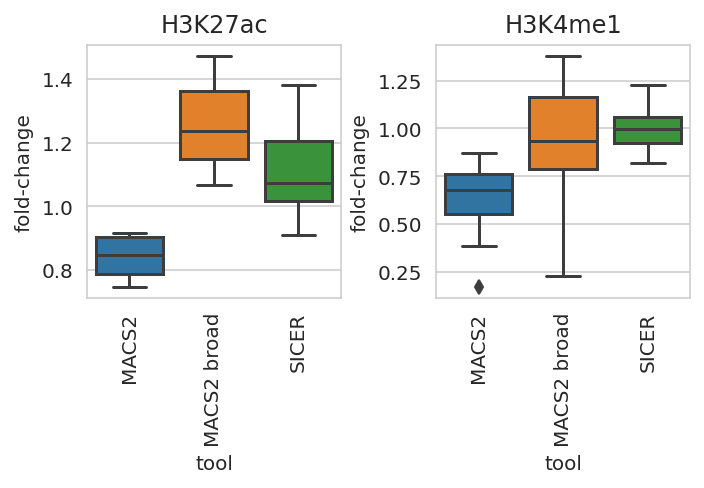

mix
H3K27ac
H3K4me1


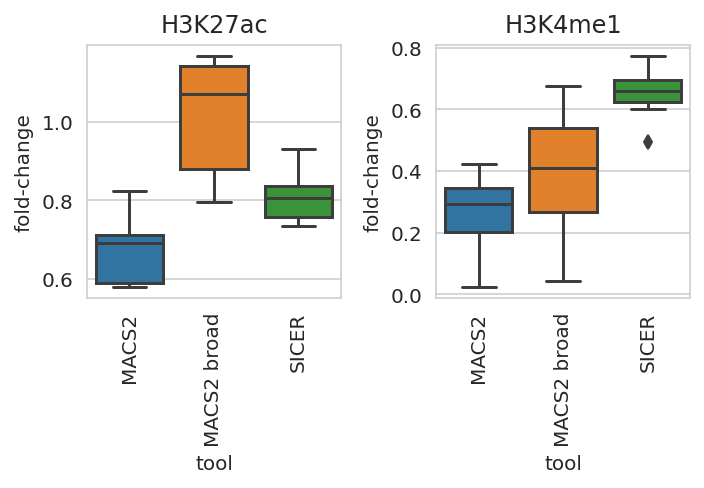

In [58]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(5, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.boxplot(data=all_wiggle_mix_peaks_fc[
            (all_wiggle_mix_peaks_fc['modification'] == m) & 
            (all_wiggle_mix_peaks_fc['type']==ty)],
                                x='tool', y='fold-change', ax=ax,
                                # capsize=.1, errwidth=2, edgecolor="black",
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        # if i < 1:
        #     ax.legend().set_visible(False)
        # else:
        #     sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, )
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

H3K27ac
H3K4me1


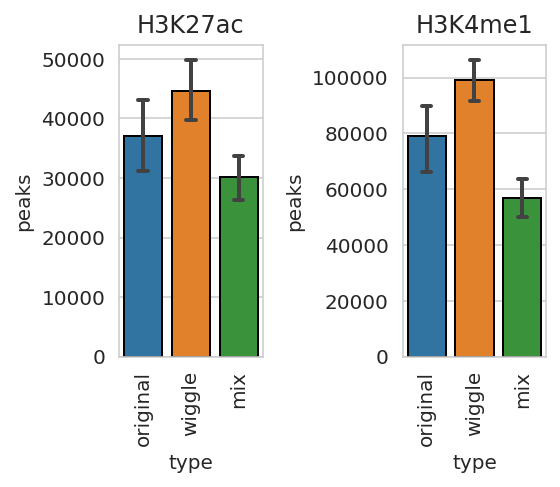

In [59]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) & 
                                                      (all_wiggle_mix_peaks['tool'] == 'SPAN')],
                            x='type',  y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['original', 'wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


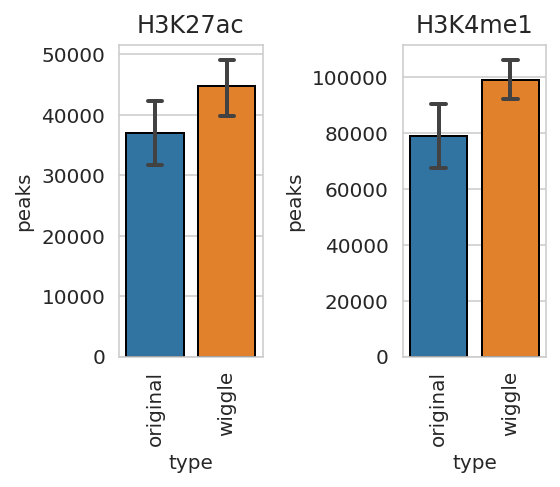

In [60]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=all_wiggle_mix_peaks[(all_wiggle_mix_peaks['modification'] == m) &
                                                      (all_wiggle_mix_peaks['tool'] == 'SPAN') &
                                                      (all_wiggle_mix_peaks['type'].isin(['original', 'wiggle']))],
                            x='type',  y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['original', 'wiggle'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # order=['MACS2', 'MACS2 broad', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [61]:
print('Load lengths')
ts = []
for ds, m, c, r, ty, file, tool in tqdm(zip(
        all_wiggle_mix_peaks['dataset'],
        all_wiggle_mix_peaks['modification'],
        all_wiggle_mix_peaks['cell'],
        all_wiggle_mix_peaks['replicate'],
        all_wiggle_mix_peaks['type'], all_wiggle_mix_peaks['file'], all_wiggle_mix_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = ds
    t['modification'] = m
    t['cell'] = c
    t['replicate'] = r
    t['type'] = ty
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length dataset modification     cell replicate      type         tool
789752     1286     NaN      H3K4me1     HSMM      rep1    wiggle        MACS2
506416     4199  ENCODE      H3K4me1     NHLF      rep1  original        SICER
905596      311     NaN      H3K4me1    Huvec      rep1       mix        MACS2
893346      375     NaN      H3K4me1     K562      rep1    wiggle        MACS2
1040025     320     NaN      H3K4me1     NHLF      rep1       mix  MACS2 broad
1129462     221     NaN      H3K4me1     K562      rep1       mix  MACS2 broad
627348      373  ENCODE      H3K4me1  GM12878      rep1  original         SPAN
1114084     347     NaN      H3K27ac     NHLF      rep1    wiggle  MACS2 broad
1223495     294     NaN      H3K4me1    Huvec      rep1       mix  MACS2 broad
588364     1264  ENCODE      H3K4me1    HepG2      rep1  original         SPAN

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


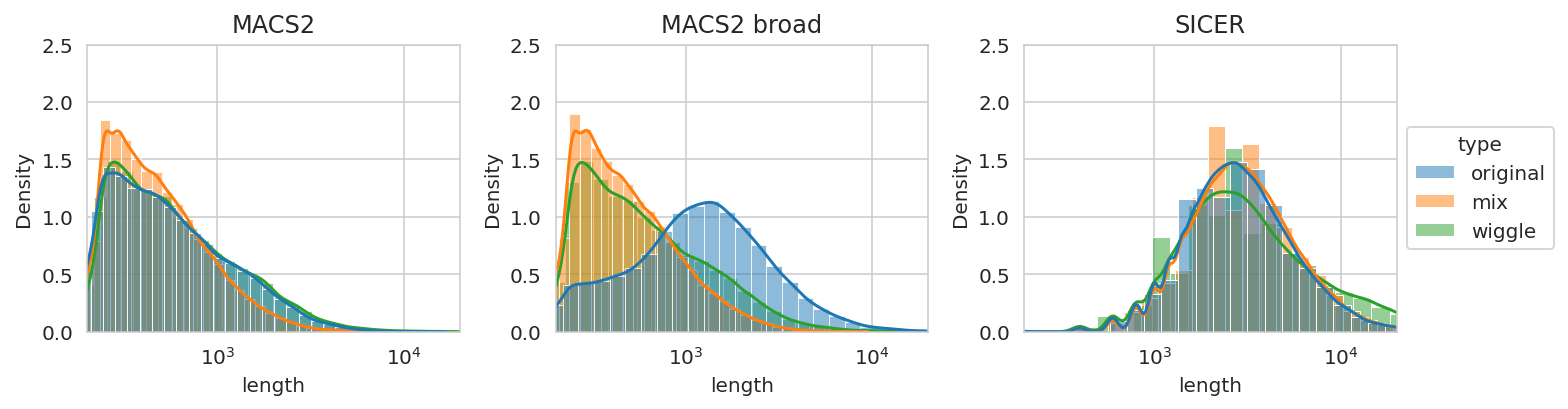

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


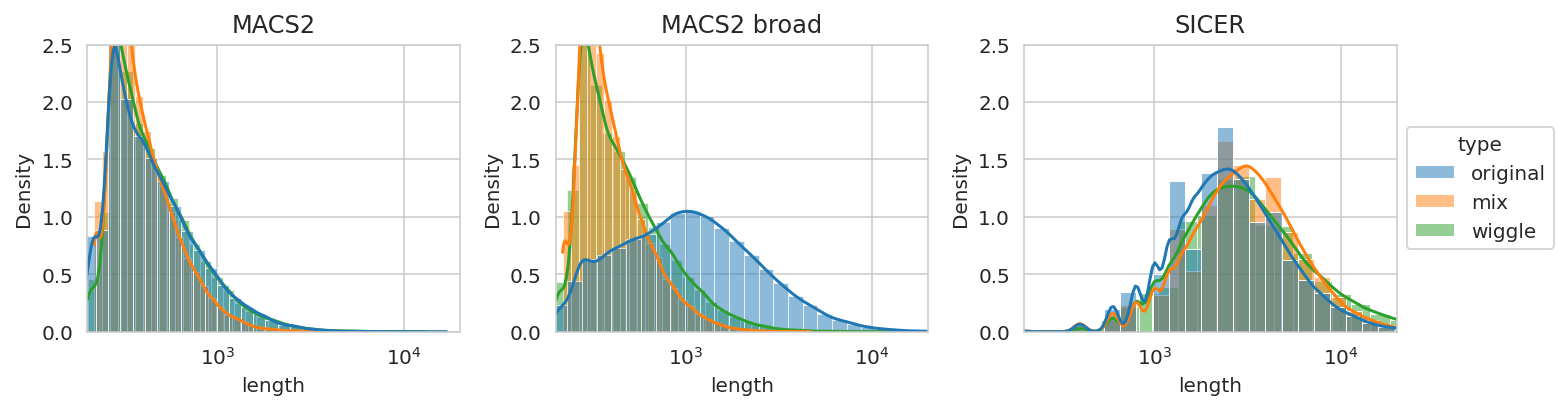

In [62]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(11, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='type', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        
    plt.tight_layout()
    plt.show()


wiggle
H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


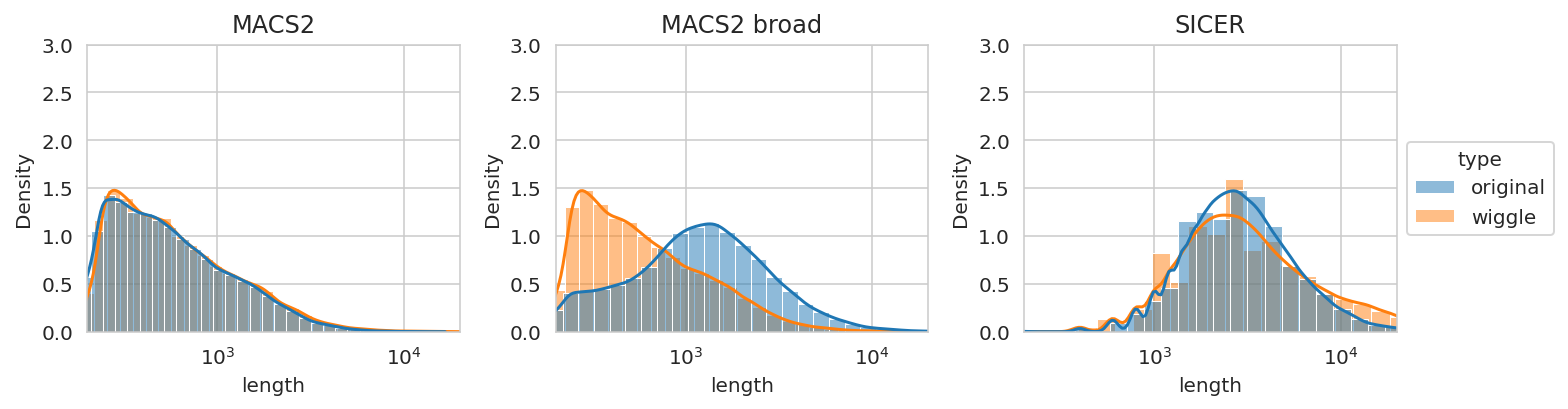

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


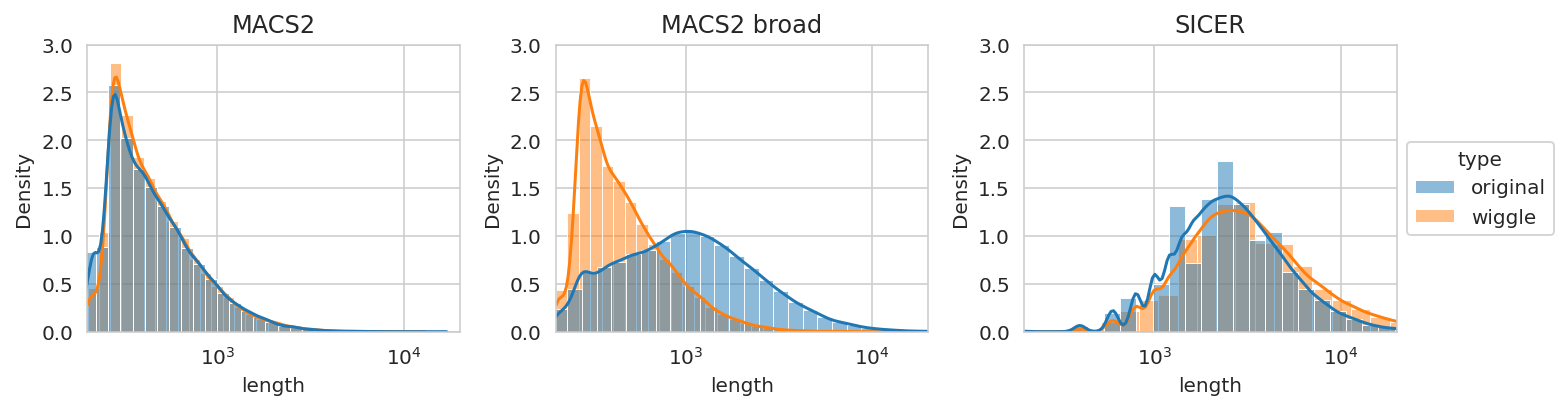

mix
H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


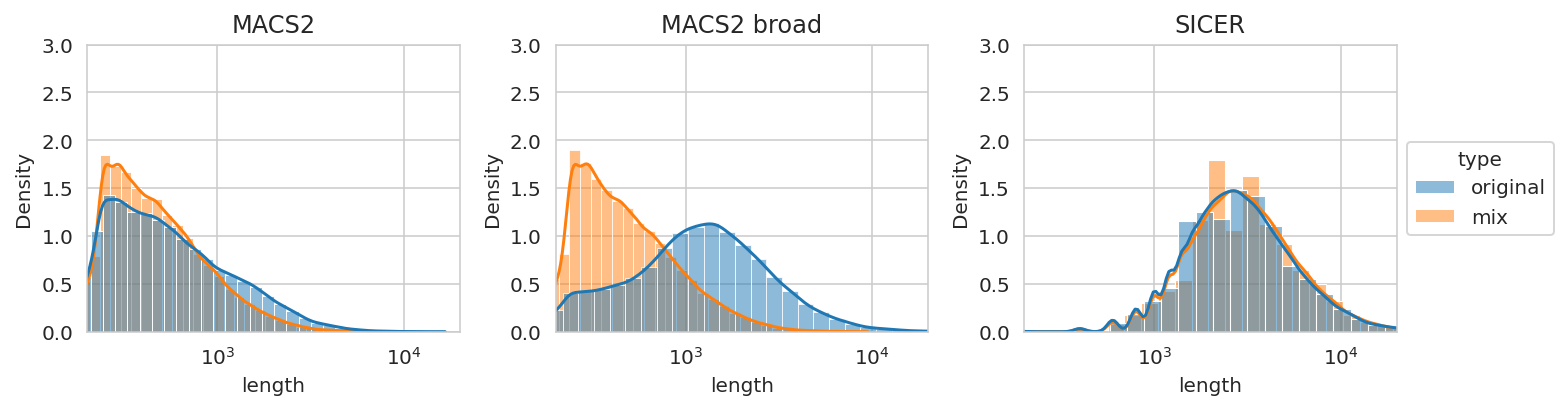

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


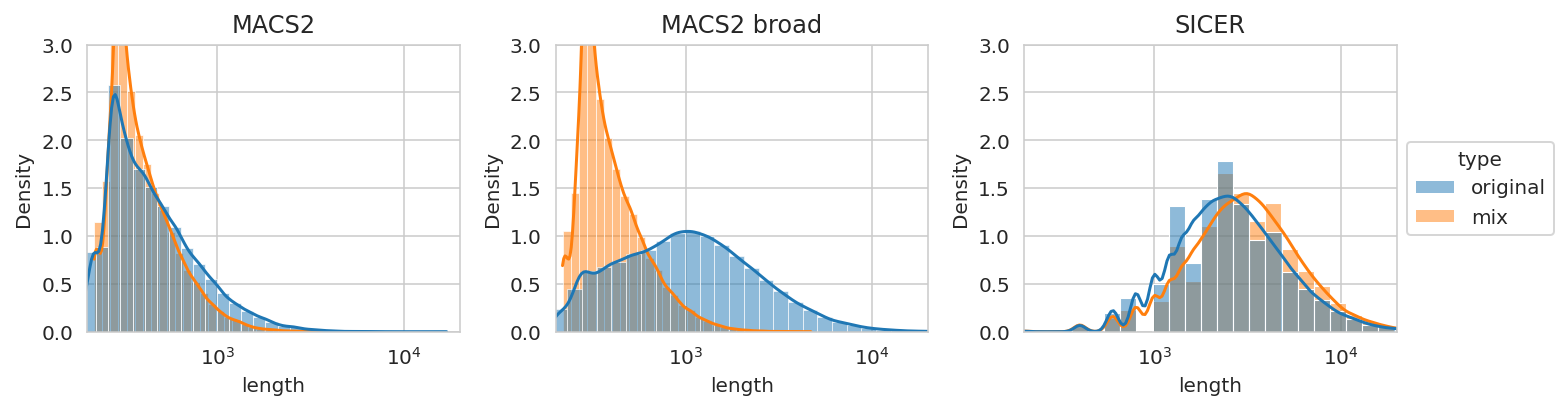

In [63]:
for ty in ['wiggle', 'mix']:
    print(ty)
    for m in ['H3K27ac', 'H3K4me1']:
        print(m)
        plt.figure(figsize=(11, 3))
        axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
        for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
            ax = axs[i]
            g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool) & (t['type'].isin(['original', ty]))],
                                     x='length', hue='type', ax=ax,
                                     stat='density', common_bins=False, common_norm=False,
                                     bins=30, kde=True, log_scale=True, alpha=0.5,
                                     )
            g_results.set(xscale='log')
            g_results.set_ylim(0, 3)
            g_results.set_xlim(200, 2e4)
            ax.title.set_text(f'{tool}')
            if i < 2:
                ax.legend().set_visible(False)
            else:
                sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

        plt.tight_layout()
        plt.show()

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


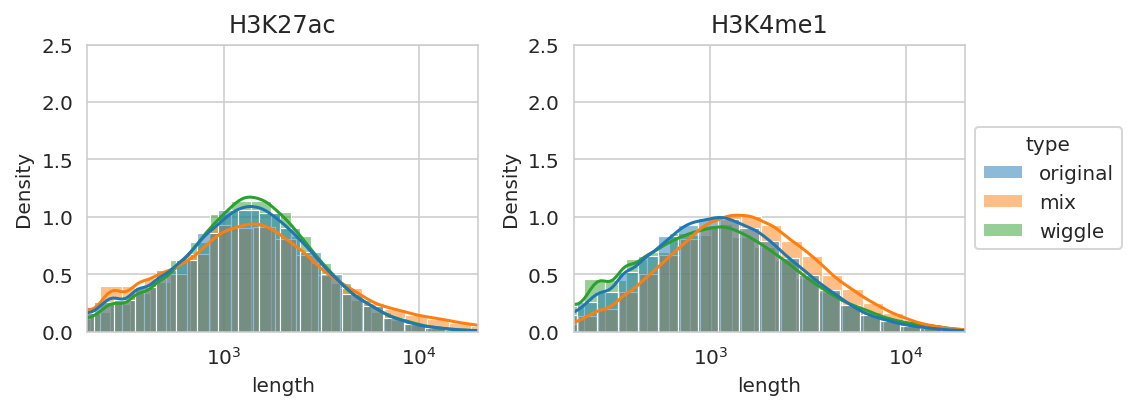

In [64]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='type', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


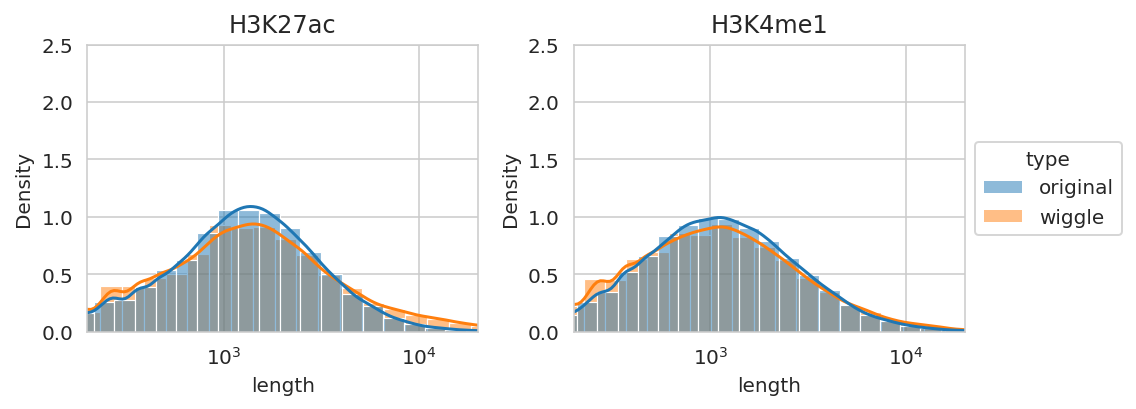

In [65]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & 
                                    (t['tool'] == 'SPAN') & 
                                    (t['type'].isin(['original', 'wiggle']))],
                             x='length', hue='type', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


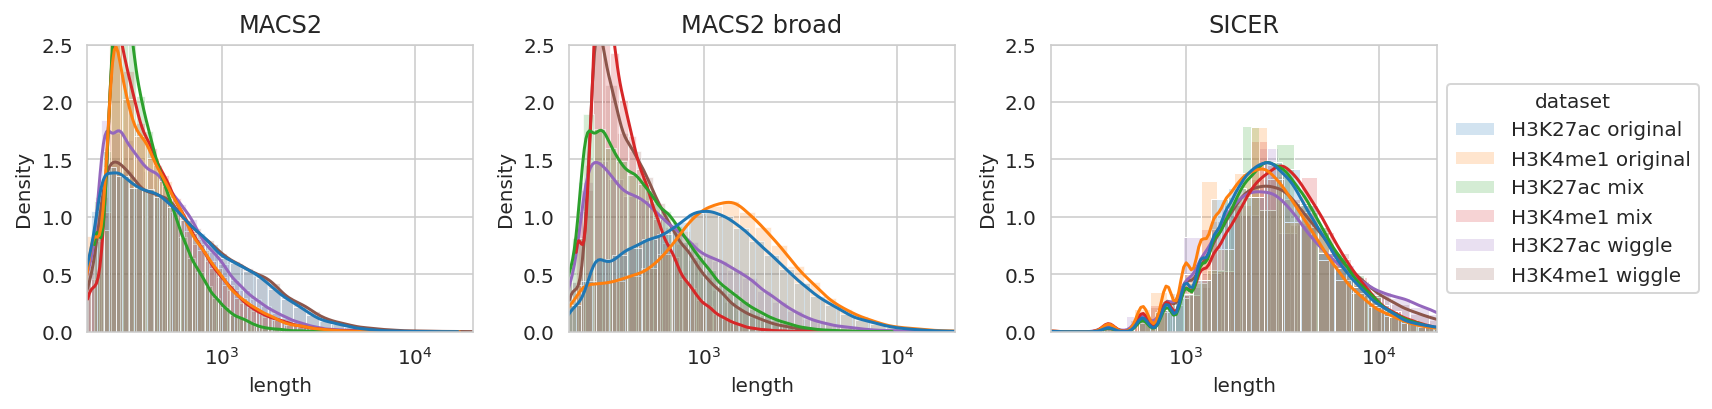

In [66]:
t['dataset'] = t['modification'] + ' ' + t['type']

plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(data=t[t['tool'] == tool],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 2:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


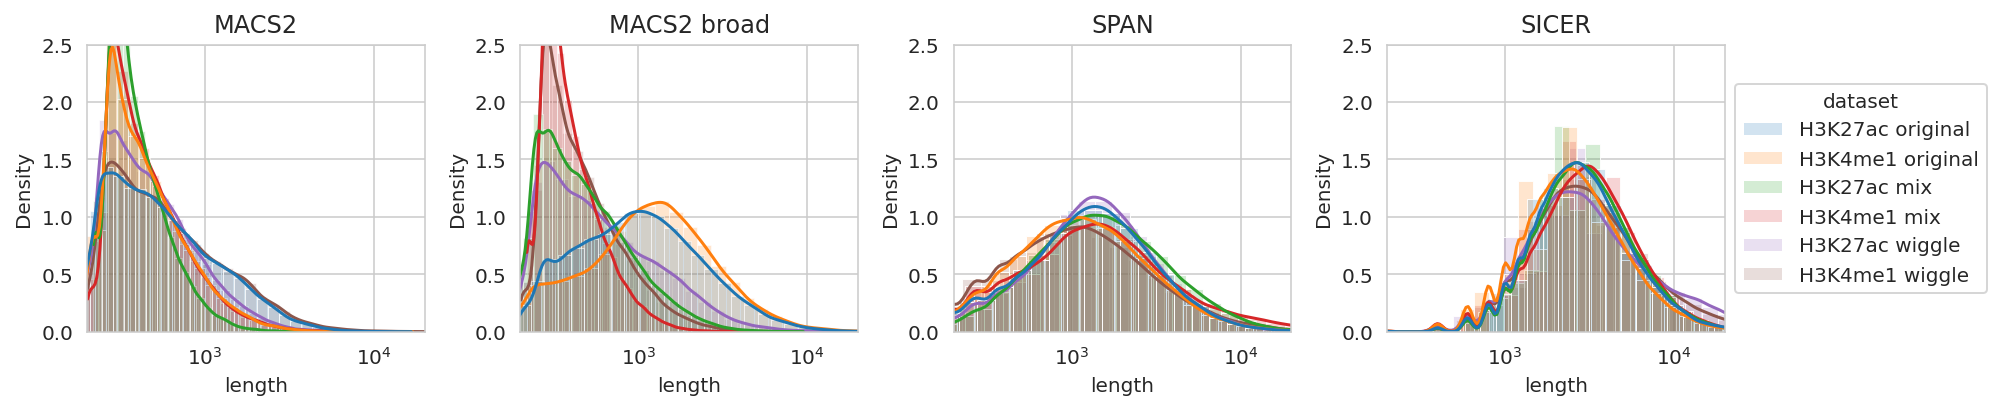

In [67]:
t['dataset'] = t['modification'] + ' ' + t['type']

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SPAN', 'SICER']):
    ax = axs[i]
    g_results = sns.histplot(data=t[t['tool'] == tool],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 3:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [68]:
t_aggr = t[
    ['dataset', 'modification', 'cell', 'replicate', 'type', 'tool', 'length']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'type', 'tool']).agg('mean').reset_index()
t_aggr.sample(3)

dataset modification     cell replicate    type   tool     length
170  H3K4me1 wiggle      H3K4me1  GM12878      rep1  wiggle  SICER  4152.3600
131     H3K4me1 mix      H3K4me1     NHLF      rep1     mix   SPAN  2891.1168
178  H3K4me1 wiggle      H3K4me1     HSMM      rep1  wiggle  SICER  4034.9600

wiggle
H3K27ac
H3K4me1


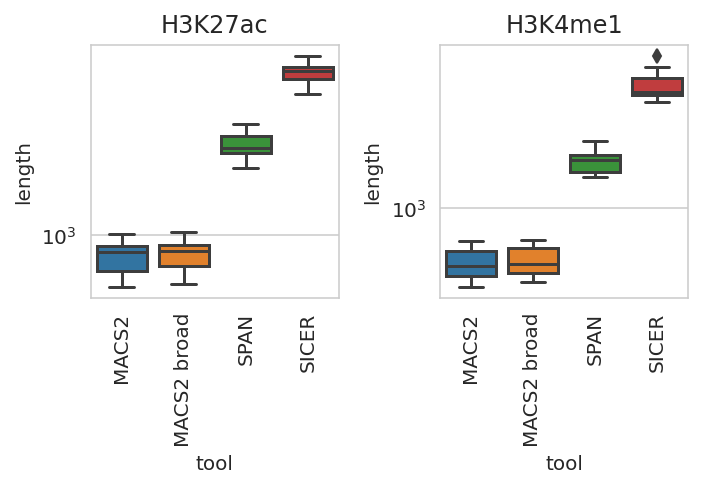

mix
H3K27ac
H3K4me1


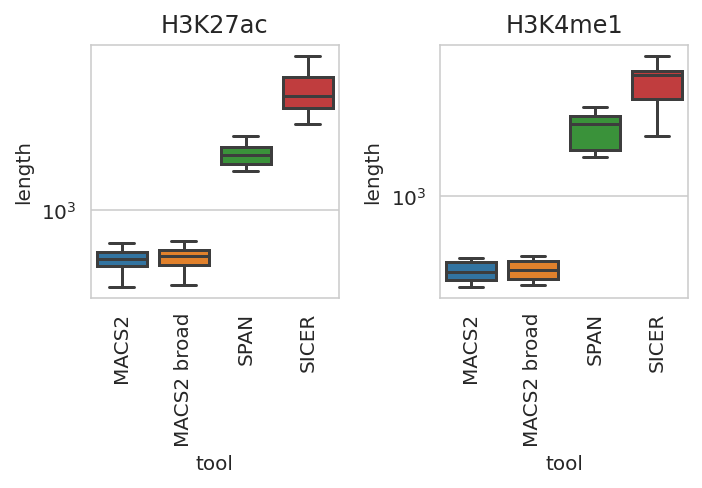

In [69]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(5, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.boxplot(data=t_aggr[
            (t_aggr['modification'] == m) &
            (t_aggr['type']==ty)],
                                x='tool', y='length', ax=ax,
                                # capsize=.1, errwidth=2, edgecolor="black",
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                # order=['MACS2', 'MACS2 broad', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        ax.set(yscale='log')
        # if i < 1:
        #     ax.legend().set_visible(False)
        # else:
        #     sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, )
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

## Prepare union peaks

In [70]:
all_wiggle_mix_roadmap_peaks = pd.concat([
    df_peaks[(df_peaks['replicate'] != 'rep2') &
             df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])], 
    wiggle_mix_peaks]).reset_index(drop=True)
all_wiggle_mix_roadmap_peaks['dataset'] = [ds if ty == 'original' else ty for ds, ty in zip(all_wiggle_mix_roadmap_peaks['dataset'], all_wiggle_mix_roadmap_peaks['type'])]
all_wiggle_mix_roadmap_peaks.sample(3)

file modification   cell  \
9    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac   HSMM   
182  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   K562   
1    /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac  HepG2   

    replicate  peaks   tool dataset          name      type  
9        rep1  57283  MACS2  ENCODE         MACS2  original  
182      rep1  37200  SICER  wiggle  SICER wiggle    wiggle  
1        rep1  48652  MACS2  ENCODE         MACS2  original

In [72]:
# Remove outliers
display(all_wiggle_mix_roadmap_peaks[(all_wiggle_mix_roadmap_peaks['peaks'] < 20_000) | 
                                     (all_wiggle_mix_roadmap_peaks['peaks'] > 100_000)])
all_wiggle_mix_roadmap_peaks = all_wiggle_mix_roadmap_peaks[
    (all_wiggle_mix_roadmap_peaks['peaks'] >= 20_000) & 
    (all_wiggle_mix_roadmap_peaks['peaks'] <= 100_000)].copy()

Empty DataFrame
Columns: [file, modification, cell, replicate, peaks, tool, dataset, name, type]
Index: []

In [73]:
! mkdir -p {WD}/union

for m, ds in tqdm(product(['H3K27ac', 'H3K4me1'], ['ENCODE', 'wiggle', 'mix', 'Roadmap'])):
    print('---')
    print(m, ds)
    tmdt = all_wiggle_mix_roadmap_peaks[(all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                        (all_wiggle_mix_roadmap_peaks['dataset'] == ds)]
    if len(tmdt) == 0:
        continue
    for _, (c, r) in tmdt[['cell', 'replicate']].drop_duplicates().iterrows():
        t = tmdt[(tmdt['cell'] == c) & (tmdt['replicate'] == r)]
        if len(t) == 0:
            continue
        print(c, r)
        # Prepare total overlap
        union_path = f'{WD}/union/{m}_{c}_{r}_{ds}.bed'
        if os.path.exists(union_path):
            continue
        try:
            files = t[t['tool'] == 'SPAN']['file']
            t_span = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'MACS2']['file']
            t_macs2 = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'MACS2 broad']['file']
            t_macs2broad = sorted_file(files.values[0]) if len(files) == 1 else ''
            files = t[t['tool'] == 'SICER']['file']
            t_sicer = sorted_file(files.values[0]) if len(files) == 1 else ''
            tf = tempfile.mktemp()
            ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
            ! bedtools merge -i {tf} > {union_path}
            print(union_path)
        except Exception as e:
            print(e)
            break
            pass

0it [00:00, ?it/s]

---
H3K27ac ENCODE
HepG2 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep1_ENCODE.bed
K562 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_K562_rep1_ENCODE.bed
Huvec rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_Huvec_rep1_ENCODE.bed
HSMM rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HSMM_rep1_ENCODE.bed
GM12878 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_GM12878_rep1_ENCODE.bed
HMEC rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HMEC_rep1_ENCODE.bed
NHLF rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_NHLF_rep1_ENCODE.bed
NHEK rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_NHEK_rep1_ENCODE.bed
H1 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_H1_rep1_ENCODE.bed
---
H3K27ac wiggle
HSMM rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HSMM_rep1_wiggle.bed
Huvec rep1
/home/jetbrains/data/2023_GSE26320_

In [74]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}

In [75]:
def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [76]:
encode_bws = load_bws(GSE26320_PATH + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
encode_bws['dataset'] = 'ENCODE'
encode_bws.sample(3)

  0%|          | 0/103 [00:00<?, ?it/s]

file modification     cell  \
24  /home/jetbrains/data/2023_GSE26320/bw/GSM64649...      Control     NHLF   
61  /home/jetbrains/data/2023_GSE26320/bw/GSM64631...      H3K27ac  GM12878   
25  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...     H3K36me3  GM12878   

   replicate dataset  
24      rep2  ENCODE  
61      rep2  ENCODE  
25      rep1  ENCODE

In [77]:
immune_bws = load_bws(IMMUNE_PATH + '/bw', MODIFICATIONS, IMMUNE_CELLS, [''], 'Control')
immune_bws['dataset'] = 'Roadmap'
immune_bws.sample(3)

  0%|          | 0/17 [00:00<?, ?it/s]

file modification   cell  \
7  /home/jetbrains/data/2023_Immune/bw/TCell_H3K2...      H3K27ac  TCell   
0  /home/jetbrains/data/2023_Immune/bw/BCell_H3K3...     H3K36me3  BCell   
1  /home/jetbrains/data/2023_Immune/bw/BCell_H3K2...     H3K27me3  BCell   

  replicate  dataset  
7            Roadmap  
0            Roadmap  
1            Roadmap

In [80]:
mix_wiggle_bws = load_bws(WD + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
mix_wiggle_bws['dataset'] = ['wiggle' if 'wiggle.bw' in f else 'mix' for f in mix_wiggle_bws['file']] 
mix_wiggle_bws.sample(3)

  0%|          | 0/32 [00:00<?, ?it/s]

file modification   cell  \
11  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K4me1   K562   
17  /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac   HSMM   
6   /home/jetbrains/data/2023_GSE26320_wiggle_mix/...      H3K27ac  Huvec   

   replicate dataset  
11      rep1  wiggle  
17      rep1     mix  
6       rep1  wiggle

In [81]:
df_bws = pd.concat([encode_bws, immune_bws, mix_wiggle_bws]).reset_index(drop=True)
df_bws.sample(3)

file modification   cell  \
13  /home/jetbrains/data/2023_GSE26320/bw/GSM64635...     H3K36me3  HepG2   
33  /home/jetbrains/data/2023_GSE26320/bw/GSM64643...      Control  Huvec   
8   /home/jetbrains/data/2023_GSE26320/bw/GSM64648...      H3K4me1   NHLF   

   replicate dataset  
13      rep1  ENCODE  
33      rep2  ENCODE  
8       rep1  ENCODE

## Compute roughness of coverage withing peaks

In [82]:
from math import ceil
import pyBigWig

rows = []
bin = 100

t = all_wiggle_mix_roadmap_peaks[['dataset', 'modification', 'cell', 'replicate']].drop_duplicates()
for dt, m, c, r in tqdm(zip(t['dataset'], t['modification'], t['cell'], t['replicate'])):
    if m == 'Control':
        continue
    print(dt, m, c, r)
    union_path = f'{WD}/union/{m}_{c}_{r}_{dt}.bed'
    print(union_path)
    if not os.path.exists(union_path):
        print('-')
        continue
    try:
        bw_path = df_bws[(df_bws['dataset'] == dt) &
                         (df_bws['modification'] == m) & (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        print(bw_path)
        t = pd.read_csv(union_path, sep='\t', header=None)
        t = t.sample(min(len(t), 1000))
        with pyBigWig.open(bw_path) as bw:
            # Resort top scored peaks by density and start with the most dense ones
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            print('Total coverage', total_coverage)
            for chr, start, end in zip(t[0], t[1], t[2]):
                if chr in CHROM_SIZES:
                    # Normalize by total coverage
                    stats = [c / total_coverage for c in bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True)]
                    rows.append((dt, m, c, r, f'{chr}:{start}-{end}',  len(stats), np.mean(stats), np.std(stats), np.var(stats)))
    except Exception as e:
        print(e)
        break
        pass  # Ignore

df_roughness = pd.DataFrame(rows, columns=['datatype', 'modification', 'cell', 'replicate', 'position', 'bins', 'mean', 'std', 'var'])
del rows
df_roughness.sample(5)

0it [00:00, ?it/s]

ENCODE H3K27ac HepG2 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_HepG2_rep1_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646355_HepG2_H3K27ac_rep1.bw
Total coverage 79.22861050548816
ENCODE H3K27ac K562 rep1
/home/jetbrains/data/2023_GSE26320_wiggle_mix/union/H3K27ac_K562_rep1_ENCODE.bed
/home/jetbrains/data/2023_GSE26320/bw/GSM646434_K562_H3K27ac_rep1.bw
Total coverage 79.31672214434862


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_roughness[df_roughness['modification'] == m],
                            x='modification', y='var', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_roughness[df_roughness['modification'] == m],
                            x='modification', y='std', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_roughness[df_roughness['modification'] == m],
                            x='modification', y='std', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
df_roughness_aggr = df_roughness[
    ['datatype', 'modification', 'cell', 'replicate', 'var', 'std']
].groupby(['datatype', 'modification', 'cell', 'replicate']).agg('mean').reset_index()
df_roughness_aggr.sample(3)

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_roughness_aggr[df_roughness_aggr['modification'] == m],
                            x='modification', y='std', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.set_ylabel('Roughness')
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
all_wiggle_mix_roadmap_peaks[(all_wiggle_mix_roadmap_peaks['type']=='wiggle') &
                             (all_wiggle_mix_roadmap_peaks['modification'] == 'H3K4me1') & 
                             (all_wiggle_mix_roadmap_peaks['peaks'] < 20_000)]

## Compute signal/control ratio within peaks

In [ ]:
from math import ceil
import pyBigWig

ratios = []

t = all_wiggle_mix_roadmap_peaks[['dataset', 'modification', 'cell', 'replicate']].drop_duplicates()
for dt, m, c, r in tqdm(zip(t['dataset'], t['modification'], t['cell'], t['replicate'])):
    if m == 'Control':
        continue
    print(dt, m, c, r)
    union_path = f'{WD}/union/{m}_{c}_{r}_{dt}.bed'
    print(union_path)
    control_dt = 'Roadmap' if dt == 'Roadmap' else 'ENCODE'
    try:
        bw_path = df_bws[(df_bws['dataset'] == dt) &
                         (df_bws['modification'] == m) & (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        print(bw_path)
        bwc_path = df_bws[(df_bws['dataset'] == control_dt) &
                          (df_bws['modification'] == 'Control') & (df_bws['cell'] == c) &
                          (df_bws['replicate'] == r)]['file'].values[0]
        print(bwc_path)
        t = pd.read_csv(union_path, sep='\t', header=None)
        t = t.sample(min(len(t), 1000))
        with pyBigWig.open(bw_path) as bw:
            # Resort top scored peaks by density and start with the most dense ones
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            print('Total signal coverage', total_coverage)
            with pyBigWig.open(bwc_path) as bwc:
                # Resort top scored peaks by density and start with the most dense ones
                total_coveragec = sum(bwc.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
                print('Total control coverage', total_coveragec)

                for chr, start, end in zip(t[0], t[1], t[2]):
                    if chr in CHROM_SIZES:
                        # Normalize by total coverage
                        signal = bw.stats(chr, start, end, exact=True, type='sum')[0] / total_coverage
                        noise = bwc.stats(chr, start, end, exact=True, type='sum')[0] / total_coveragec
                        ratios.append((dt, m, c, r, f'{chr}:{start}-{end}', (signal + 1e-10) / (noise + 1e-10)))
    except:
        pass  # Ignore

df_signal_to_control = pd.DataFrame(ratios, columns=['datatype', 'modification', 'cell', 'replicate', 'position', 'signal_to_control'])
del ratios
df_signal_to_control.sample(5)

In [ ]:
plt.figure(figsize=(6, 5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=df_signal_to_control[df_signal_to_control['modification'] == m], x='modification', y='signal_to_control', hue='datatype',
                            hue_order=['ENCODE', 'wiggle', 'mix', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

# Signal-to-noise ratio

In [ ]:
# TODO

# Jaccard vs original peaks

In [ ]:
bench_df = pd.DataFrame(
    columns=['dataset', 'modification', 'cell', 'replicate', 'name', 'type',
             'original_peaks', 'original_peaks_len',
             'peaks', 'peaks_len', 'overlap1', 'overlap2', 'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for ds, m, c, r, tool in tqdm(
        [('ENCODE', m, c, r, tool) for m, c, r, tool in product(['H3K27ac', 'H3K4me1'], GSE26320_CELLS, GSE26320_REPS, TOOLS)] +
        [('Roadmap', m, c, r, tool) for m, c, r, tool in product(['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, [''], TOOLS)]
):
    print(ds, m, c, r, tool)
    t = all_wiggle_mix_roadmap_peaks[
        # (all_wiggle_mix_roadmap_peaks['dataset'] == ds) &
                                     (all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                     (all_wiggle_mix_roadmap_peaks['cell'] == c) &
                                     (all_wiggle_mix_roadmap_peaks['replicate'] == r) &
                                     (all_wiggle_mix_roadmap_peaks['tool'] == tool) &
                                     (all_wiggle_mix_roadmap_peaks['type'] == 'original')]
    if len(t) == 0:
        print('-')
        continue
    original_file = sorted_file(t['file'].values[0])
    original_peaks = lines(original_file)
    original_peaks_len = int(bedl(original_file).sum())
    for ty in ['wiggle', 'mix']:
        t = all_wiggle_mix_roadmap_peaks[
            # (all_wiggle_mix_roadmap_peaks['dataset'] == ds) &
                                         (all_wiggle_mix_roadmap_peaks['modification'] == m) &
                                         (all_wiggle_mix_roadmap_peaks['cell'] == c) &
                                         (all_wiggle_mix_roadmap_peaks['replicate'] == r) &
                                         (all_wiggle_mix_roadmap_peaks['tool'] == tool) &
                                         (all_wiggle_mix_roadmap_peaks['type'] == ty)]
        if len(t) == 0:
            print(ty, '--')
            continue
        file = sorted_file(t['file'].values[0])
        peaks = lines(file)
        peaks_len = int(bedl(file).sum())
        !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
        overlap1 = lines(tf)
        !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
        overlap2 = lines(tf)
        !bedtools intersect -a {original_file} -b {file} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        bench_df.loc[len(bench_df)] = \
            (ds, m, c, r, tool, ty,
             original_peaks, original_peaks_len,
             peaks, peaks_len, overlap1, overlap2, overlap_len)

display(bench_df.sample(3))


In [ ]:
bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['original_peaks_len'], bench_df['peaks_len'], bench_df['overlap_len'])
]
bench_df.sample(1)


In [ ]:
plt.figure(figsize=(7, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['modification'] == m],
                            x='name', hue='type', y='jaccard', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            hue_order=['wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
for ty in ['wiggle', 'mix']:
    print(ty)
    plt.figure(figsize=(6, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        g_results = sns.barplot(data=bench_df[(bench_df['type'] == ty) & (bench_df['modification'] == m)],
                                x='name', hue='type', y='jaccard', ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                # hue_order=['wiggle', 'mix'],
                                # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                # palette=TOOLS_PALETTE,
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

## Coverage roughness (std) in peaks region example

In [ ]:
xs = [3,6,20,13,7,15,12,15,7,2]
print(sum(xs), np.var(xs))

ys = [3,8,17,14,8,13,12,16,6,3]
print(sum(ys), np.var(ys))

In [ ]:
diff_bench_df = pd.DataFrame(
    columns=['dataset', 'modification', 'cell', 'replicate', 'name', 'peaks', 'peakslen', 'averagelen'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for ds, m, c, r in tqdm(
        [('ENCODE', m, c, r) for m, c, r in product(MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)] +
        [('Roadmap', m, c, r) for m, c, r in product(MODIFICATIONS, IMMUNE_CELLS, [''])]
):
    # Process single tool information
    span_file = None
    for tool in TOOLS:
        print(ds, m, c, r, tool)
        t = df_peaks[
            (df_peaks['dataset'] == ds) &
            (df_peaks['modification'] == m) &
            (df_peaks['cell'] == c) &
            (df_peaks['replicate'] == r) &
            (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        file = sorted_file(t['file'].values[0])
        peaks = lines(file)
        peaks_len = bedl(file).sum()
        average_len = d(peaks_len,  peaks)
        diff_bench_df.loc[len(diff_bench_df)] = (ds, m, c, r, tool, peaks, peaks_len, average_len) 
        if tool == 'SPAN':
            span_file = file
            
    # Processing SPAN difference
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_peaks[
            (df_peaks['dataset'] == ds) &
            (df_peaks['modification'] == m) &
            (df_peaks['cell'] == c) &
            (df_peaks['replicate'] == r) &
            (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            ! bedtools intersect {args} -e -f 0.5 -F 0.5 -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = bedl(tf).sum()
            average_len = d(peaks_len,  peaks)
            diff_bench_df.loc[len(diff_bench_df)] = (ds, m, c, r, name, peaks, peaks_len, average_len)
    
    # Processing exclusive peaks        
    for tool in TOOLS:
        t = df_peaks[
            (df_peaks['dataset'] == ds) &
            (df_peaks['modification'] == m) &
            (df_peaks['cell'] == c) &
            (df_peaks['replicate'] == r) &
            (df_peaks['tool'] == tool)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        other_tool_files = []
        for ot in TOOLS:
            if ot == tool:
                continue
            t = df_peaks[
                (df_peaks['dataset'] == ds) &
                (df_peaks['modification'] == m) &
                (df_peaks['cell'] == c) &
                (df_peaks['replicate'] == r) &
                (df_peaks['tool'] == ot)]
            if len(t) == 0:
                continue
            other_tool_files.append(sorted_file(t['file'].values[0]))
        other_tool_files_str = ' '.join(other_tool_files)

        ! bedtools multiinter -i {other_tool_files_str} > {tf}
        ! bedtools merge -i {tf} > {tf2}
        ! bedtools intersect -a {peaks_file} -b {tf2} -e -f 0.5 -F 0.5 -wa -v > {tf}
        peaks = lines(tf)
        peaks_len = bedl(tf).sum()
        average_len = d(peaks_len,  peaks)
        diff_bench_df.loc[len(diff_bench_df)] = (ds, m, c, r, f'{tool} only', peaks, peaks_len, average_len)

display(diff_bench_df.sample(3))

In [ ]:
diff_bench_df.to_csv(os.path.expanduser('~/data/datasets.csv'), index=False)

In [ ]:
plt.figure(figsize=(20, 8))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.barplot(data=diff_bench_df[(diff_bench_df['dataset'] == ds) &
                                               (diff_bench_df['modification']==m) &
                                               (diff_bench_df['peaks'] > 0)],
                            x='name', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    if i == 0:
        ax.set_ylabel('Peaks')
    else:
        ax.set_ylabel(None)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 8))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.barplot(data=diff_bench_df[(diff_bench_df['dataset'] == ds) &
                                               (diff_bench_df['modification']==m) &
                                               (diff_bench_df['peaks'] > 0)],
                            x='name', y='peakslen',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    if i == 0:
        ax.set_ylabel('Basepairs')
    else:
        ax.set_ylabel(None)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 8))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.boxplot(data=diff_bench_df[(diff_bench_df['dataset'] == ds) & 
                                               (diff_bench_df['modification']==m) & 
                                               (diff_bench_df['peaks'] > 0)],
                            x='name', y='averagelen',
                            ax=ax,
                            # log_scale=True,
                            # capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ]
                            )
    # ax.set(yscale='log')
    # ax.set_ylim(bottom=1e2)
    if i == 0:
        ax.set_ylabel('Average length')
    else:
        ax.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)
    
plt.tight_layout()
plt.show()

## Compute signal / control coverage RPKM

In [ ]:
tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

def load_rpkms(path, bw, bwc, total_coverage, total_coveragec, n=1000):
    if lines(path) == 0:
        return []
    t = pd.read_csv(path, sep='\t', header=None)
    t = t.sample(min(len(t), n))
    
    for chr, start, end in zip(t[0], t[1], t[2]):
        if chr in CHROM_SIZES:
            # Normalize by total coverage
            signal = bw.stats(chr, start, end, exact=False, type='sum')[0] / total_coverage
            noise = bwc.stats(chr, start, end, exact=False, type='sum')[0] / total_coveragec
            yield f'{chr}:{start}-{end}', d(signal, (end - start) / 1e3), d(noise, (end - start) / 1e3)

def rpkms_to_df(rpkm_gen, ds, mod, cell, rep, name):
    positions = []
    rpkms = []
    rpkmcs = []
    for p, r, rc in rpkm_gen:
        positions.append(p)
        rpkms.append(r)
        rpkmcs.append(rc)
    t = pd.DataFrame(data={'position': positions * 3, 
                            'RPKM': rpkms + rpkmcs + [d(r, rc) for r, rc in zip(rpkms, rpkmcs)], 
                            'type': ['signal'] * len(positions) + ['control'] * len(positions) + ['signal_to_control'] * len(positions)})
    t['dataset'] = ds
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['name'] = name
    return t

ts = []

for ds, m, c, r in tqdm(
        [('ENCODE', m, c, r) for m, c, r in product(MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)] +
        [('Roadmap', m, c, r) for m, c, r in product(MODIFICATIONS, IMMUNE_CELLS, [''])]
):
    try:
        bw_path = df_bws[(df_bws['dataset'] == ds) &
                         (df_bws['modification'] == m) &
                         (df_bws['cell'] == c) &
                         (df_bws['replicate'] == r)]['file'].values[0]
        bwc_path = df_bws[(df_bws['dataset'] == ds) &
                          (df_bws['modification'] == 'Control') &
                          (df_bws['cell'] == c) &
                          (df_bws['replicate'] == r)]['file'].values[0]
    
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            with pyBigWig.open(bwc_path) as bwc:
                print(ds, m, c, r, 'Total signal coverage', total_coverage)
                total_coveragec = sum(bwc.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
                print(ds, m, c, r, 'Total control coverage', total_coveragec)
                print('Process single tool information')
                span_file = None
                for tool in TOOLS:
                    # print(ds, m, c, r, tool)
                    t = df_peaks[
                        (df_peaks['dataset'] == ds) &
                        (df_peaks['modification'] == m) &
                        (df_peaks['cell'] == c) &
                        (df_peaks['replicate'] == r) &
                        (df_peaks['tool'] == tool)]
                    if len(t) == 0:
                        continue
                    file = sorted_file(t['file'].values[0])
                    ts.append(rpkms_to_df(load_rpkms(file, bw, bwc, total_coverage, total_coveragec), ds, m, c, r, tool))
                    if tool == 'SPAN':
                        span_file = file

                print('Processing SPAN difference')
                for tool in TOOLS:
                    if tool == 'SPAN':
                        continue
                    t = df_peaks[
                        (df_peaks['dataset'] == ds) &
                        (df_peaks['modification'] == m) &
                        (df_peaks['cell'] == c) &
                        (df_peaks['replicate'] == r) &
                        (df_peaks['tool'] == tool)]
                    if len(t) == 0:
                        continue
                    peaks_file = sorted_file(t['file'].values[0])
                    for name, args in [
                        (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                        (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
                    ]:
                        ! bedtools intersect {args} -e -f 0.5 -F 0.5 -wa -v > {tf}
                        ts.append(rpkms_to_df(load_rpkms(tf, bw, bwc, total_coverage, total_coveragec), ds, m, c, r, name))

                print('Processing exclusive peaks')        
                for tool in TOOLS:
                    t = df_peaks[
                        (df_peaks['dataset'] == ds) &
                        (df_peaks['modification'] == m) &
                        (df_peaks['cell'] == c) &
                        (df_peaks['replicate'] == r) &
                        (df_peaks['tool'] == tool)]
                    if len(t) == 0:
                        continue
                    peaks_file = sorted_file(t['file'].values[0])
                    other_tool_files = []
                    for ot in TOOLS:
                        if ot == tool:
                            continue
                        t = df_peaks[
                            (df_peaks['dataset'] == ds) &
                            (df_peaks['modification'] == m) &
                            (df_peaks['cell'] == c) &
                            (df_peaks['replicate'] == r) &
                            (df_peaks['tool'] == ot)]
                        if len(t) == 0:
                            continue
                        other_tool_files.append(sorted_file(t['file'].values[0]))
                    other_tool_files_str = ' '.join(other_tool_files)

                    ! bedtools multiinter -i {other_tool_files_str} > {tf}
                    ! bedtools merge -i {tf} > {tf2}
                    ! bedtools intersect -a {peaks_file} -b {tf2} -e -f 0.5 -F 0.5 -wa -v > {tf}
                    ts.append(rpkms_to_df(load_rpkms(tf, bw, bwc, total_coverage, total_coveragec), ds, m, c, r, f'{tool} only'))
    except:
        continue

diff_bench_coverage_df = pd.concat(ts).reset_index(drop=True)
del ts
display(diff_bench_coverage_df.sample(3))

In [ ]:
plt.figure(figsize=(24, 10))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.boxplot(data=diff_bench_coverage_df[(diff_bench_coverage_df['type'] != 'signal_to_control') & 
                                                        (diff_bench_coverage_df['dataset'] == ds) &
                                                        (diff_bench_coverage_df['modification']==m)],
                            x='name', y='RPKM', hue='type',
                            ax=ax,
                            showfliers=False,
                            # log_scale=True,
                            # capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ],
                            )
    # ax.set(yscale='log')
    # ax.set_ylim(bottom=1e2)
    if i == 0:
        ax.set_ylabel('RPKM')
    else:
        ax.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(24, 10))
axs = [plt.subplot(2, 5, i + 1) for i in range(10)]
for i, (ds, m) in tqdm(enumerate(
        [('ENCODE', m) for m in MODIFICATIONS] +
        [('Roadmap', m) for m in MODIFICATIONS])
):
    ax = axs[i]
    ax.title.set_text(f'{ds} {m}')
    g_results = sns.boxplot(data=diff_bench_coverage_df[(diff_bench_coverage_df['type'] == 'signal_to_control') & 
                                                        (diff_bench_coverage_df['dataset'] == ds) &
                                                        (diff_bench_coverage_df['modification']==m) &
                                                        (diff_bench_coverage_df['RPKM']<1000)],
                            x='name', y='RPKM', 
                            ax=ax,
                            showfliers=False,
                            # log_scale=True,
                            # capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   'MACS2 only', 'MACS2 broad only', 'SPAN only', 'SICER only',
                                   ],
                            )
    # ax.set(yscale='log')
    # ax.set_ylim(bottom=1e2)
    if i == 0:
        ax.set_ylabel('Signal / control')
    else:
        ax.set_ylabel(None)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# END